# Dependencies loading

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy
import numba
from catboost import CatBoostClassifier, cv, Pool
import optuna
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve)
from sklearn.inspection import permutation_importance
import shap

import warnings
warnings.filterwarnings('ignore')  # Suppress warning

# Data loading

In [99]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train_fe.csv")
X_test = pd.read_csv(f"{base_url}/X_test_fe.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 20) (8639, 20)
(34554, 1) (8639, 1)


In [100]:
X_train

,age,job,marital,education,balance,housing,loan,contact,duration,pdays,previous,poutcome,contact_date,customer_value_score,estimated_income,balance_per_contact,age_balance_ratio,age_bin,previous_bin,last_contact_days_bin
0,55,blue-collar,married,secondary,16873,0,0,cellular,4.369448,-1,0,other,1-jun,16873,33873,16873.0,301.303571,Senior,none,no contact
1,34,technician,married,secondary,4,1,0,cellular,4.663439,263,1,failure,2-feb,8,22004,2.0,0.114286,Middle-aged,low,long ago
2,40,admin.,married,secondary,451,1,1,unknown,5.552960,-1,0,other,29-may,451,22451,451.0,11.000000,Middle-aged,none,no contact
3,29,services,single,secondary,-142,1,0,unknown,4.948760,-1,0,other,16-may,-142,16858,-142.0,-4.733333,Young,none,no contact
4,51,technician,divorced,secondary,131,1,0,cellular,5.267858,-1,0,other,18-nov,131,22131,131.0,2.519231,Senior,none,no contact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34549,60,retired,married,secondary,2060,0,0,cellular,4.912655,95,4,failure,29-jun,10300,14060,412.0,33.770492,Senior,medium,long ago
34550,32,management,single,tertiary,0,0,0,cellular,4.060443,-1,0,other,19-nov,0,28000,0.0,0.000000,Middle-aged,none,no contact
34551,38,blue-collar,married,primary,0,0,0,unknown,5.347108,-1,0,other,13-may,0,16000,0.0,0.000000,Middle-aged,none,no contact
34552,30,admin.,single,secondary,154,1,0,cellular,3.218876,-1,0,other,21-nov,154,22154,154.0,4.967742,Young,none,no contact


# Model

In [102]:
category_cols = ['job', 'marital', 'education', 'contact', 'contact_date', 
                 'poutcome','age_bin','previous_bin','last_contact_days_bin']

# initialize the model
cat_model = CatBoostClassifier()

# fit the model
cat_model.fit(X_train, y_train,cat_features=category_cols, verbose=10)

# and make predictions
y_pred = cat_model.predict(X_test)

Learning rate set to 0.04676
0:	learn: 0.6404704	total: 15.2ms	remaining: 15.2s
10:	learn: 0.3651209	total: 182ms	remaining: 16.4s
20:	learn: 0.2612279	total: 327ms	remaining: 15.2s
30:	learn: 0.2279422	total: 447ms	remaining: 14s
40:	learn: 0.2135944	total: 582ms	remaining: 13.6s
50:	learn: 0.2051601	total: 707ms	remaining: 13.2s
60:	learn: 0.2008718	total: 842ms	remaining: 13s
70:	learn: 0.1974622	total: 972ms	remaining: 12.7s
80:	learn: 0.1954383	total: 1.1s	remaining: 12.5s
90:	learn: 0.1938059	total: 1.23s	remaining: 12.3s
100:	learn: 0.1925976	total: 1.36s	remaining: 12.2s
110:	learn: 0.1913385	total: 1.5s	remaining: 12s
120:	learn: 0.1905186	total: 1.63s	remaining: 11.8s
130:	learn: 0.1896212	total: 1.76s	remaining: 11.7s
140:	learn: 0.1888286	total: 1.91s	remaining: 11.6s
150:	learn: 0.1880739	total: 2.04s	remaining: 11.5s
160:	learn: 0.1874297	total: 2.16s	remaining: 11.3s
170:	learn: 0.1867368	total: 2.29s	remaining: 11.1s
180:	learn: 0.1861888	total: 2.42s	remaining: 11s
190

## Model Evaluation

### Accuracy:

In [105]:
# lets start with accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.9098275263340665

The model did well with 91% accuracy, which is a great start. Next, we should look at other things like precision and recall, especially for the smaller class, to make sure it handles imbalances properly.

### Classification Report:

In [108]:
# prediction probabilities
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# classification report
report = classification_report(y_test, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.93      0.97      0.95      7635
         Yes       0.65      0.49      0.56      1004

    accuracy                           0.91      8639
   macro avg       0.79      0.73      0.75      8639
weighted avg       0.90      0.91      0.90      8639



The model performs strongly for non-subscribers (class 0), achieving high precision and recall. While it struggles with identifying subscribers (class 1), showing lower recall and F1-score, it still outperformed other models for the smaller class. Despite an overall accuracy of 91%, there’s room to further improve class 1 predictions for better balance.

### ROC AUC score:

In [111]:
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Test AUC: {auc_score:.4f}")

Test AUC: 0.9355


The Test AUC score of 0.9355 shows that the model performs better than the other models in distinguishing between classes. While the other models also performed very well, this one showed an even stronger ability to correctly rank positive and negative instances, reflecting very nice overall performance.

### Consusion Matrix:

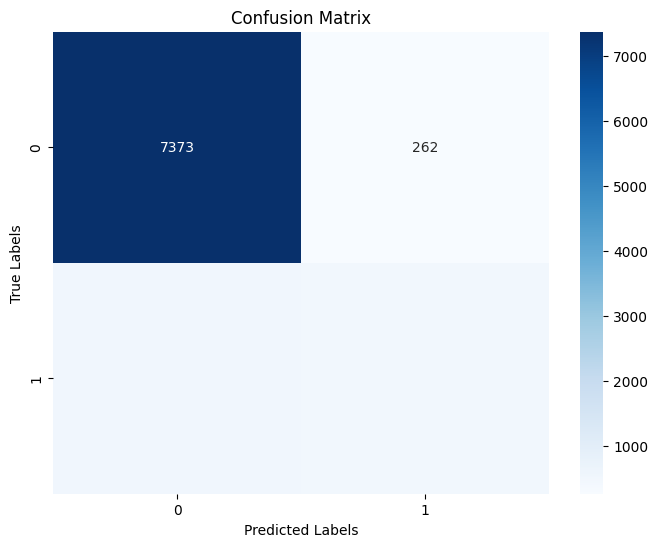

In [114]:
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows once again that the model is great at predicting non-subscribers (class 0) but struggles to identify subscribers (class 1) accurately.

### ROC curve:

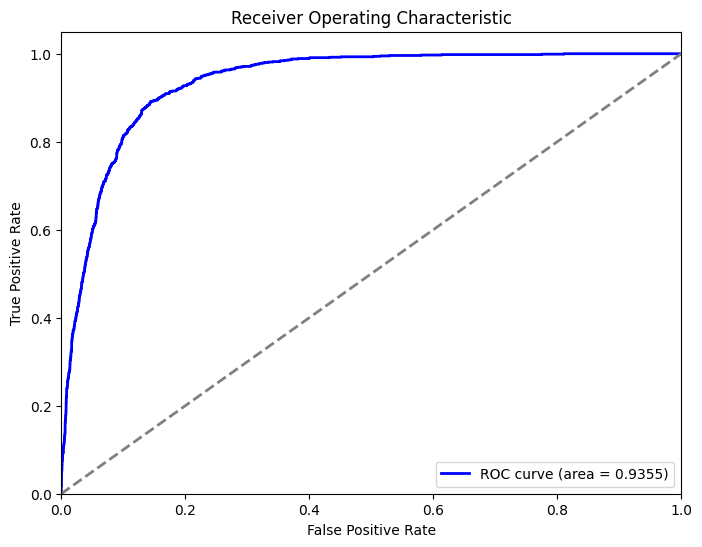

In [117]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve shows the model performs well overall, with an AUC score of 0.9355, 
outperforming its peers. However, it still struggles to fully capture subscribers 
due to the imbalance, favoring non-subscribers. We'll see if hyperparameters like 'scale_pos_weight' and 'subsample' can help balance the data and improve performance.

## Hyperparameter tunning

In [120]:
# objective function
def objective(trial):
    # defining hyperparameters to optimize
    params = {
        "iterations": trial.suggest_int("iterations", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.05, log=True),
        "depth": trial.suggest_int("depth", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.1, 0.9),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 1500),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 4),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 50, 150),
        "random_seed": 56
    }
    
    # lets initialize the CatBoost model
    cat_model = CatBoostClassifier(**params, eval_metric="F1", custom_metric="F1")

    # and train the model with early stopping
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=category_cols, 
                  early_stopping_rounds=30, 
                  verbose=1)

    # return the best F1-score from the validation set
    return max(cat_model.evals_result_["validation"]["F1"])

# create an Optuna study for maximizing F1-score
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=56))
study.optimize(objective, n_trials=100)

# get the best hyperparameters
best_params = study.best_trial.params

# train the final model with the best parameters
cat_model = CatBoostClassifier(**best_params, cat_features=category_cols, eval_metric="F1", custom_metric="F1", verbose=100)
cat_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=10)

[I 2025-01-05 11:44:30,103] A new study created in memory with name: no-name-f95dcd7e-dc05-4416-9690-0217b076b85a


0:	learn: 0.5364247	test: 0.5316376	best: 0.5316376 (0)	total: 11ms	remaining: 3.27s
1:	learn: 0.5553269	test: 0.5386611	best: 0.5386611 (1)	total: 22.2ms	remaining: 3.28s
2:	learn: 0.5564929	test: 0.5387229	best: 0.5387229 (2)	total: 30.9ms	remaining: 3.02s
3:	learn: 0.5539463	test: 0.5303473	best: 0.5387229 (2)	total: 38.9ms	remaining: 2.85s
4:	learn: 0.3180838	test: 0.3180509	best: 0.5387229 (2)	total: 46.6ms	remaining: 2.72s
5:	learn: 0.4186807	test: 0.4084672	best: 0.5387229 (2)	total: 55ms	remaining: 2.67s
6:	learn: 0.4187229	test: 0.4084672	best: 0.5387229 (2)	total: 60.8ms	remaining: 2.52s
7:	learn: 0.3576616	test: 0.3507928	best: 0.5387229 (2)	total: 69.3ms	remaining: 2.5s
8:	learn: 0.4157168	test: 0.4003693	best: 0.5387229 (2)	total: 78.2ms	remaining: 2.5s
9:	learn: 0.4537122	test: 0.4385496	best: 0.5387229 (2)	total: 85.1ms	remaining: 2.44s
10:	learn: 0.4834421	test: 0.4754772	best: 0.5387229 (2)	total: 93.8ms	remaining: 2.44s
11:	learn: 0.5139530	test: 0.5036129	best: 0.538

[I 2025-01-05 11:44:30,428] Trial 0 finished with value: 0.5387228555208933 and parameters: {'iterations': 297, 'learning_rate': 0.000794089959919587, 'depth': 5, 'subsample': 0.2571123337716197, 'colsample_bylevel': 0.3835571717128189, 'min_data_in_leaf': 1314, 'scale_pos_weight': 1.743548660533783, 'l2_leaf_reg': 95.86113251462137}. Best is trial 0 with value: 0.5387228555208933.


25:	learn: 0.5419798	test: 0.5237202	best: 0.5387229 (2)	total: 212ms	remaining: 2.21s
26:	learn: 0.5434632	test: 0.5213620	best: 0.5387229 (2)	total: 221ms	remaining: 2.21s
27:	learn: 0.5453930	test: 0.5247706	best: 0.5387229 (2)	total: 230ms	remaining: 2.21s
28:	learn: 0.5449708	test: 0.5247706	best: 0.5387229 (2)	total: 238ms	remaining: 2.2s
29:	learn: 0.5155154	test: 0.5025133	best: 0.5387229 (2)	total: 246ms	remaining: 2.19s
30:	learn: 0.5259025	test: 0.5145905	best: 0.5387229 (2)	total: 254ms	remaining: 2.18s
31:	learn: 0.5332908	test: 0.5129430	best: 0.5387229 (2)	total: 261ms	remaining: 2.16s
32:	learn: 0.5291055	test: 0.5129330	best: 0.5387229 (2)	total: 269ms	remaining: 2.15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5387228555
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.6536803	test: 0.6554249	best: 0.6554249 (0)	total: 6.7ms	remaining: 1.8s
1:	learn: 0.6308185	test: 0.6194504	best: 0.6554249 (0)	total: 12.7ms	remaining: 1.7s


[I 2025-01-05 11:44:30,637] Trial 1 finished with value: 0.6554248617178818 and parameters: {'iterations': 270, 'learning_rate': 0.0011404452445980956, 'depth': 2, 'subsample': 0.17207608819501702, 'colsample_bylevel': 0.7673741999390672, 'min_data_in_leaf': 596, 'scale_pos_weight': 2.942635246291841, 'l2_leaf_reg': 104.95039883673454}. Best is trial 1 with value: 0.6554248617178818.


18:	learn: 0.6473584	test: 0.6397248	best: 0.6554249 (0)	total: 106ms	remaining: 1.41s
19:	learn: 0.6473584	test: 0.6397248	best: 0.6554249 (0)	total: 113ms	remaining: 1.41s
20:	learn: 0.6473762	test: 0.6401385	best: 0.6554249 (0)	total: 118ms	remaining: 1.4s
21:	learn: 0.6494089	test: 0.6459065	best: 0.6554249 (0)	total: 124ms	remaining: 1.4s
22:	learn: 0.6499540	test: 0.6459463	best: 0.6554249 (0)	total: 129ms	remaining: 1.39s
23:	learn: 0.6476629	test: 0.6403450	best: 0.6554249 (0)	total: 134ms	remaining: 1.37s
24:	learn: 0.6496674	test: 0.6461232	best: 0.6554249 (0)	total: 140ms	remaining: 1.37s
25:	learn: 0.6502124	test: 0.6461624	best: 0.6554249 (0)	total: 146ms	remaining: 1.37s
26:	learn: 0.6502157	test: 0.6461624	best: 0.6554249 (0)	total: 151ms	remaining: 1.36s
27:	learn: 0.6499540	test: 0.6459463	best: 0.6554249 (0)	total: 156ms	remaining: 1.35s
28:	learn: 0.6499540	test: 0.6459463	best: 0.6554249 (0)	total: 161ms	remaining: 1.34s
29:	learn: 0.6502157	test: 0.6461624	best: 0.

[I 2025-01-05 11:44:31,044] Trial 2 finished with value: 0.2923916895682759 and parameters: {'iterations': 263, 'learning_rate': 0.0005200959638824134, 'depth': 3, 'subsample': 0.8047083059959043, 'colsample_bylevel': 0.689086163962588, 'min_data_in_leaf': 1213, 'scale_pos_weight': 1.1070159068138863, 'l2_leaf_reg': 51.97312289425127}. Best is trial 1 with value: 0.6554248617178818.


31:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 313ms	remaining: 2.26s
32:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 321ms	remaining: 2.24s
33:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 329ms	remaining: 2.21s
34:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 336ms	remaining: 2.19s
35:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 343ms	remaining: 2.16s
36:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 351ms	remaining: 2.14s
37:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 358ms	remaining: 2.12s
38:	learn: 0.2870581	test: 0.2886909	best: 0.2923917 (8)	total: 365ms	remaining: 2.1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2923916896
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 0.6197713	test: 0.6107252	best: 0.6107252 (0)	total: 7.89ms	remaining: 1.03s
1:	learn: 0.6243363	test: 0.6095241	best: 0.6107252 (0)	total: 16.2ms	remaining: 1.0

[I 2025-01-05 11:44:31,464] Trial 3 finished with value: 0.6512401145810107 and parameters: {'iterations': 132, 'learning_rate': 0.0033079962259074656, 'depth': 5, 'subsample': 0.6836543102559196, 'colsample_bylevel': 0.8921528957456525, 'min_data_in_leaf': 1464, 'scale_pos_weight': 2.650586004836901, 'l2_leaf_reg': 148.82616712174436}. Best is trial 1 with value: 0.6554248617178818.


45:	learn: 0.6466505	test: 0.6411285	best: 0.6512401 (24)	total: 317ms	remaining: 593ms
46:	learn: 0.6464729	test: 0.6424697	best: 0.6512401 (24)	total: 325ms	remaining: 588ms
47:	learn: 0.6462741	test: 0.6414209	best: 0.6512401 (24)	total: 332ms	remaining: 580ms
48:	learn: 0.6465573	test: 0.6420760	best: 0.6512401 (24)	total: 337ms	remaining: 571ms
49:	learn: 0.6465873	test: 0.6426010	best: 0.6512401 (24)	total: 345ms	remaining: 566ms
50:	learn: 0.6466686	test: 0.6426010	best: 0.6512401 (24)	total: 352ms	remaining: 559ms
51:	learn: 0.6454554	test: 0.6399149	best: 0.6512401 (24)	total: 359ms	remaining: 552ms
52:	learn: 0.6451680	test: 0.6388751	best: 0.6512401 (24)	total: 366ms	remaining: 546ms
53:	learn: 0.6445166	test: 0.6376080	best: 0.6512401 (24)	total: 373ms	remaining: 538ms
54:	learn: 0.6457652	test: 0.6386977	best: 0.6512401 (24)	total: 379ms	remaining: 530ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6512401146
bestIteration = 24

Shrink model to first

[I 2025-01-05 11:44:31,786] Trial 4 finished with value: 0.33724903402020506 and parameters: {'iterations': 177, 'learning_rate': 0.0008790737600073079, 'depth': 6, 'subsample': 0.26334572425815655, 'colsample_bylevel': 0.42093320026964887, 'min_data_in_leaf': 972, 'scale_pos_weight': 1.4134821176956298, 'l2_leaf_reg': 122.52027196117112}. Best is trial 1 with value: 0.6554248617178818.


16:	learn: 0.3419146	test: 0.3372490	best: 0.3372490 (16)	total: 105ms	remaining: 984ms
17:	learn: 0.3510990	test: 0.3314201	best: 0.3372490 (16)	total: 111ms	remaining: 981ms
18:	learn: 0.3400063	test: 0.3236473	best: 0.3372490 (16)	total: 117ms	remaining: 977ms
19:	learn: 0.3419020	test: 0.3236473	best: 0.3372490 (16)	total: 123ms	remaining: 965ms
20:	learn: 0.3183133	test: 0.3136136	best: 0.3372490 (16)	total: 128ms	remaining: 950ms
21:	learn: 0.3187516	test: 0.3099824	best: 0.3372490 (16)	total: 136ms	remaining: 956ms
22:	learn: 0.3188113	test: 0.3084373	best: 0.3372490 (16)	total: 142ms	remaining: 949ms
23:	learn: 0.3205195	test: 0.3080960	best: 0.3372490 (16)	total: 147ms	remaining: 940ms
24:	learn: 0.3254602	test: 0.3173952	best: 0.3372490 (16)	total: 155ms	remaining: 942ms
25:	learn: 0.3117400	test: 0.3036474	best: 0.3372490 (16)	total: 160ms	remaining: 932ms
26:	learn: 0.3135522	test: 0.3036474	best: 0.3372490 (16)	total: 167ms	remaining: 925ms
27:	learn: 0.3153145	test: 0.304

[I 2025-01-05 11:44:32,058] Trial 5 finished with value: 0.6763978304450952 and parameters: {'iterations': 197, 'learning_rate': 0.0002645198163124592, 'depth': 5, 'subsample': 0.2322705436682073, 'colsample_bylevel': 0.6954700511703551, 'min_data_in_leaf': 759, 'scale_pos_weight': 3.256729296943689, 'l2_leaf_reg': 62.89241766703567}. Best is trial 5 with value: 0.6763978304450952.


32:	learn: 0.6693450	test: 0.6721913	best: 0.6763978 (4)	total: 212ms	remaining: 1.05s
33:	learn: 0.6693710	test: 0.6721913	best: 0.6763978 (4)	total: 217ms	remaining: 1.04s
34:	learn: 0.6701214	test: 0.6730531	best: 0.6763978 (4)	total: 223ms	remaining: 1.03s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6763978304
bestIteration = 4

Shrink model to first 5 iterations.
0:	learn: 0.6477401	test: 0.6524285	best: 0.6524285 (0)	total: 7.96ms	remaining: 438ms
1:	learn: 0.6275635	test: 0.6219397	best: 0.6524285 (0)	total: 14.7ms	remaining: 398ms
2:	learn: 0.6290168	test: 0.6248608	best: 0.6524285 (0)	total: 21.6ms	remaining: 381ms
3:	learn: 0.6144828	test: 0.6067992	best: 0.6524285 (0)	total: 28.3ms	remaining: 368ms
4:	learn: 0.6299844	test: 0.6275668	best: 0.6524285 (0)	total: 34.7ms	remaining: 354ms
5:	learn: 0.6386627	test: 0.6410380	best: 0.6524285 (0)	total: 41.4ms	remaining: 345ms
6:	learn: 0.6414857	test: 0.6427680	best: 0.6524285 (0)	total: 48.8ms	remaining: 34

[I 2025-01-05 11:44:32,307] Trial 6 finished with value: 0.6524284798398065 and parameters: {'iterations': 56, 'learning_rate': 0.00029963134289401073, 'depth': 6, 'subsample': 0.32585102011095685, 'colsample_bylevel': 0.7610405528766852, 'min_data_in_leaf': 872, 'scale_pos_weight': 2.4069443508502344, 'l2_leaf_reg': 68.83884783417278}. Best is trial 5 with value: 0.6763978304450952.


21:	learn: 0.6342473	test: 0.6264051	best: 0.6524285 (0)	total: 152ms	remaining: 235ms
22:	learn: 0.6337456	test: 0.6221764	best: 0.6524285 (0)	total: 158ms	remaining: 227ms
23:	learn: 0.6343127	test: 0.6242947	best: 0.6524285 (0)	total: 165ms	remaining: 220ms
24:	learn: 0.6337952	test: 0.6256552	best: 0.6524285 (0)	total: 172ms	remaining: 213ms
25:	learn: 0.6343259	test: 0.6271542	best: 0.6524285 (0)	total: 179ms	remaining: 207ms
26:	learn: 0.6352219	test: 0.6276182	best: 0.6524285 (0)	total: 185ms	remaining: 198ms
27:	learn: 0.6354563	test: 0.6270505	best: 0.6524285 (0)	total: 191ms	remaining: 191ms
28:	learn: 0.6345419	test: 0.6297153	best: 0.6524285 (0)	total: 197ms	remaining: 184ms
29:	learn: 0.6341022	test: 0.6251048	best: 0.6524285 (0)	total: 204ms	remaining: 177ms
30:	learn: 0.6338808	test: 0.6227935	best: 0.6524285 (0)	total: 210ms	remaining: 169ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6524284798
bestIteration = 0

Shrink model to first 1 iteratio

[I 2025-01-05 11:44:32,526] Trial 7 finished with value: 0.5501029608150656 and parameters: {'iterations': 88, 'learning_rate': 0.00010102593677629169, 'depth': 3, 'subsample': 0.13105037454322802, 'colsample_bylevel': 0.6866614061434033, 'min_data_in_leaf': 1179, 'scale_pos_weight': 1.4382804090597494, 'l2_leaf_reg': 103.52733224737403}. Best is trial 5 with value: 0.6763978304450952.


19:	learn: 0.3964391	test: 0.3832440	best: 0.5501030 (3)	total: 107ms	remaining: 365ms
20:	learn: 0.4320249	test: 0.4238479	best: 0.5501030 (3)	total: 112ms	remaining: 358ms
21:	learn: 0.4357352	test: 0.4237171	best: 0.5501030 (3)	total: 117ms	remaining: 352ms
22:	learn: 0.4371727	test: 0.4267302	best: 0.5501030 (3)	total: 123ms	remaining: 347ms
23:	learn: 0.4485216	test: 0.4363875	best: 0.5501030 (3)	total: 129ms	remaining: 345ms
24:	learn: 0.4376509	test: 0.4277986	best: 0.5501030 (3)	total: 134ms	remaining: 338ms
25:	learn: 0.4482640	test: 0.4344941	best: 0.5501030 (3)	total: 140ms	remaining: 334ms
26:	learn: 0.4487788	test: 0.4361846	best: 0.5501030 (3)	total: 145ms	remaining: 327ms
27:	learn: 0.4495994	test: 0.4370269	best: 0.5501030 (3)	total: 150ms	remaining: 321ms
28:	learn: 0.4498570	test: 0.4370269	best: 0.5501030 (3)	total: 156ms	remaining: 317ms
29:	learn: 0.4524547	test: 0.4412102	best: 0.5501030 (3)	total: 160ms	remaining: 310ms
30:	learn: 0.4939821	test: 0.4839781	best: 

[I 2025-01-05 11:44:35,842] Trial 8 finished with value: 0.6171908366201466 and parameters: {'iterations': 291, 'learning_rate': 0.009801308734907041, 'depth': 6, 'subsample': 0.36191483662395385, 'colsample_bylevel': 0.7789648597673167, 'min_data_in_leaf': 1374, 'scale_pos_weight': 1.4522030839507494, 'l2_leaf_reg': 51.74136268104411}. Best is trial 5 with value: 0.6763978304450952.


281:	learn: 0.6342887	test: 0.6171908	best: 0.6171908 (255)	total: 3.18s	remaining: 102ms
282:	learn: 0.6341080	test: 0.6162419	best: 0.6171908 (255)	total: 3.2s	remaining: 90.3ms
283:	learn: 0.6346729	test: 0.6160051	best: 0.6171908 (255)	total: 3.21s	remaining: 79.1ms
284:	learn: 0.6344244	test: 0.6160051	best: 0.6171908 (255)	total: 3.22s	remaining: 67.8ms
285:	learn: 0.6353047	test: 0.6157685	best: 0.6171908 (255)	total: 3.24s	remaining: 56.6ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6171908366
bestIteration = 255

Shrink model to first 256 iterations.
0:	learn: 0.6351207	test: 0.6342904	best: 0.6342904 (0)	total: 5.73ms	remaining: 905ms
1:	learn: 0.5742328	test: 0.5725666	best: 0.6342904 (0)	total: 11.3ms	remaining: 889ms
2:	learn: 0.5761010	test: 0.5757051	best: 0.6342904 (0)	total: 17.3ms	remaining: 900ms
3:	learn: 0.3954878	test: 0.3738978	best: 0.6342904 (0)	total: 22.6ms	remaining: 875ms
4:	learn: 0.2826323	test: 0.2677141	best: 0.6342904 (0)	total

[I 2025-01-05 11:44:36,029] Trial 9 finished with value: 0.6342903508182748 and parameters: {'iterations': 159, 'learning_rate': 0.0012253842807744982, 'depth': 3, 'subsample': 0.12853030924828693, 'colsample_bylevel': 0.27762893353297846, 'min_data_in_leaf': 864, 'scale_pos_weight': 2.58295586526667, 'l2_leaf_reg': 125.38577312415731}. Best is trial 5 with value: 0.6763978304450952.


20:	learn: 0.3360505	test: 0.3260234	best: 0.6342904 (0)	total: 102ms	remaining: 672ms
21:	learn: 0.3290197	test: 0.3156043	best: 0.6342904 (0)	total: 107ms	remaining: 664ms
22:	learn: 0.3419143	test: 0.3252302	best: 0.6342904 (0)	total: 111ms	remaining: 656ms
23:	learn: 0.3412156	test: 0.3313806	best: 0.6342904 (0)	total: 115ms	remaining: 646ms
24:	learn: 0.3447202	test: 0.3344907	best: 0.6342904 (0)	total: 119ms	remaining: 640ms
25:	learn: 0.3573724	test: 0.3481908	best: 0.6342904 (0)	total: 124ms	remaining: 634ms
26:	learn: 0.3476948	test: 0.3401533	best: 0.6342904 (0)	total: 128ms	remaining: 627ms
27:	learn: 0.3566670	test: 0.3496706	best: 0.6342904 (0)	total: 133ms	remaining: 622ms
28:	learn: 0.3682381	test: 0.3599657	best: 0.6342904 (0)	total: 138ms	remaining: 617ms
29:	learn: 0.3574978	test: 0.3471245	best: 0.6342904 (0)	total: 142ms	remaining: 612ms
30:	learn: 0.3648386	test: 0.3593291	best: 0.6342904 (0)	total: 147ms	remaining: 606ms
Stopped by overfitting detector  (30 iterat

[I 2025-01-05 11:44:36,215] Trial 10 finished with value: 0.42265076563432125 and parameters: {'iterations': 201, 'learning_rate': 0.03993592253217247, 'depth': 1, 'subsample': 0.5139889669258991, 'colsample_bylevel': 0.13371951142243232, 'min_data_in_leaf': 508, 'scale_pos_weight': 3.8830411198319754, 'l2_leaf_reg': 79.419984518225}. Best is trial 5 with value: 0.6763978304450952.


23:	learn: 0.3023019	test: 0.3020493	best: 0.4226508 (0)	total: 97.4ms	remaining: 718ms
24:	learn: 0.3022058	test: 0.3034494	best: 0.4226508 (0)	total: 102ms	remaining: 718ms
25:	learn: 0.3021897	test: 0.3034494	best: 0.4226508 (0)	total: 106ms	remaining: 714ms
26:	learn: 0.3021897	test: 0.3034494	best: 0.4226508 (0)	total: 110ms	remaining: 709ms
27:	learn: 0.3021897	test: 0.3034494	best: 0.4226508 (0)	total: 115ms	remaining: 710ms
28:	learn: 0.3021897	test: 0.3034494	best: 0.4226508 (0)	total: 119ms	remaining: 705ms
29:	learn: 0.3021897	test: 0.3034494	best: 0.4226508 (0)	total: 123ms	remaining: 701ms
30:	learn: 0.3021737	test: 0.3034494	best: 0.4226508 (0)	total: 127ms	remaining: 695ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4226507656
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.6041339	test: 0.5909530	best: 0.5909530 (0)	total: 4.7ms	remaining: 1.07s
1:	learn: 0.6041339	test: 0.5909530	best: 0.5909530 (0)	total: 9.14ms	remaining: 1.

[I 2025-01-05 11:44:36,402] Trial 11 finished with value: 0.5909530045808578 and parameters: {'iterations': 228, 'learning_rate': 0.00015153663267269727, 'depth': 1, 'subsample': 0.48575500753094614, 'colsample_bylevel': 0.5999401214180179, 'min_data_in_leaf': 633, 'scale_pos_weight': 3.428661371828772, 'l2_leaf_reg': 94.12265513875312}. Best is trial 5 with value: 0.6763978304450952.


27:	learn: 0.5335913	test: 0.5180422	best: 0.5909530 (0)	total: 120ms	remaining: 860ms
28:	learn: 0.2244468	test: 0.2130815	best: 0.5909530 (0)	total: 125ms	remaining: 860ms
29:	learn: 0.2244468	test: 0.2130815	best: 0.5909530 (0)	total: 129ms	remaining: 853ms
30:	learn: 0.2239677	test: 0.2146155	best: 0.5909530 (0)	total: 133ms	remaining: 848ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5909530046
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.6545399	test: 0.6619922	best: 0.6619922 (0)	total: 7.17ms	remaining: 1.76s
1:	learn: 0.6553941	test: 0.6619922	best: 0.6619922 (0)	total: 15.8ms	remaining: 1.94s
2:	learn: 0.6499870	test: 0.6396082	best: 0.6619922 (0)	total: 22.9ms	remaining: 1.86s
3:	learn: 0.6499870	test: 0.6396082	best: 0.6619922 (0)	total: 29.7ms	remaining: 1.8s
4:	learn: 0.6501167	test: 0.6396082	best: 0.6619922 (0)	total: 36.1ms	remaining: 1.75s
5:	learn: 0.6089600	test: 0.5856913	best: 0.6619922 (0)	total: 42.2ms	remaining: 1.7

[I 2025-01-05 11:44:36,666] Trial 12 finished with value: 0.6619922430319444 and parameters: {'iterations': 247, 'learning_rate': 0.0035249189780746063, 'depth': 2, 'subsample': 0.1345213346346586, 'colsample_bylevel': 0.8962368253451451, 'min_data_in_leaf': 675, 'scale_pos_weight': 3.141691036526783, 'l2_leaf_reg': 116.96584349294308}. Best is trial 5 with value: 0.6763978304450952.


18:	learn: 0.6500594	test: 0.6396082	best: 0.6619922 (0)	total: 136ms	remaining: 1.64s
19:	learn: 0.6610203	test: 0.6602337	best: 0.6619922 (0)	total: 142ms	remaining: 1.61s
20:	learn: 0.6534464	test: 0.6470761	best: 0.6619922 (0)	total: 149ms	remaining: 1.6s
21:	learn: 0.6525334	test: 0.6457962	best: 0.6619922 (0)	total: 155ms	remaining: 1.58s
22:	learn: 0.6525334	test: 0.6457962	best: 0.6619922 (0)	total: 160ms	remaining: 1.56s
23:	learn: 0.6525901	test: 0.6457962	best: 0.6619922 (0)	total: 165ms	remaining: 1.53s
24:	learn: 0.6527457	test: 0.6457962	best: 0.6619922 (0)	total: 171ms	remaining: 1.51s
25:	learn: 0.6527457	test: 0.6457962	best: 0.6619922 (0)	total: 176ms	remaining: 1.5s
26:	learn: 0.6527457	test: 0.6457962	best: 0.6619922 (0)	total: 181ms	remaining: 1.48s
27:	learn: 0.6527457	test: 0.6457962	best: 0.6619922 (0)	total: 188ms	remaining: 1.47s
28:	learn: 0.6527457	test: 0.6457962	best: 0.6619922 (0)	total: 193ms	remaining: 1.45s
29:	learn: 0.6527457	test: 0.6457962	best: 0.

[I 2025-01-05 11:44:38,152] Trial 13 finished with value: 0.7545207380033593 and parameters: {'iterations': 229, 'learning_rate': 0.004247984814799242, 'depth': 4, 'subsample': 0.45210025492011147, 'colsample_bylevel': 0.8850857928937679, 'min_data_in_leaf': 736, 'scale_pos_weight': 3.320746361755659, 'l2_leaf_reg': 124.90885510775168}. Best is trial 13 with value: 0.7545207380033593.


142:	learn: 0.7570266	test: 0.7516318	best: 0.7545207 (123)	total: 1.32s	remaining: 797ms
143:	learn: 0.7572796	test: 0.7517451	best: 0.7545207 (123)	total: 1.33s	remaining: 788ms
144:	learn: 0.7571943	test: 0.7514054	best: 0.7545207 (123)	total: 1.34s	remaining: 777ms
145:	learn: 0.7574913	test: 0.7515186	best: 0.7545207 (123)	total: 1.35s	remaining: 767ms
146:	learn: 0.7575481	test: 0.7522562	best: 0.7545207 (123)	total: 1.36s	remaining: 757ms
147:	learn: 0.7574217	test: 0.7517451	best: 0.7545207 (123)	total: 1.36s	remaining: 747ms
148:	learn: 0.7576050	test: 0.7517451	best: 0.7545207 (123)	total: 1.37s	remaining: 737ms
149:	learn: 0.7579272	test: 0.7521429	best: 0.7545207 (123)	total: 1.38s	remaining: 728ms
150:	learn: 0.7578419	test: 0.7521429	best: 0.7545207 (123)	total: 1.39s	remaining: 718ms
151:	learn: 0.7579272	test: 0.7521429	best: 0.7545207 (123)	total: 1.4s	remaining: 708ms
152:	learn: 0.7580251	test: 0.7520297	best: 0.7545207 (123)	total: 1.41s	remaining: 698ms
153:	learn:

[I 2025-01-05 11:44:39,859] Trial 14 finished with value: 0.7846714404831129 and parameters: {'iterations': 216, 'learning_rate': 0.010339994392693572, 'depth': 4, 'subsample': 0.4794201998370795, 'colsample_bylevel': 0.5454780544085156, 'min_data_in_leaf': 823, 'scale_pos_weight': 3.9287433102585645, 'l2_leaf_reg': 143.3969789232095}. Best is trial 14 with value: 0.7846714404831129.


194:	learn: 0.7882183	test: 0.7839800	best: 0.7840799 (193)	total: 1.48s	remaining: 159ms
195:	learn: 0.7882920	test: 0.7833709	best: 0.7840799 (193)	total: 1.49s	remaining: 152ms
196:	learn: 0.7880170	test: 0.7835707	best: 0.7840799 (193)	total: 1.49s	remaining: 144ms
197:	learn: 0.7882930	test: 0.7840799	best: 0.7840799 (193)	total: 1.5s	remaining: 136ms
198:	learn: 0.7882930	test: 0.7835707	best: 0.7840799 (193)	total: 1.51s	remaining: 129ms
199:	learn: 0.7884176	test: 0.7836707	best: 0.7840799 (193)	total: 1.51s	remaining: 121ms
200:	learn: 0.7886943	test: 0.7833709	best: 0.7840799 (193)	total: 1.52s	remaining: 114ms
201:	learn: 0.7886445	test: 0.7833709	best: 0.7840799 (193)	total: 1.53s	remaining: 106ms
202:	learn: 0.7887441	test: 0.7833709	best: 0.7840799 (193)	total: 1.54s	remaining: 98.6ms
203:	learn: 0.7887433	test: 0.7835707	best: 0.7840799 (193)	total: 1.55s	remaining: 91ms
204:	learn: 0.7884932	test: 0.7837706	best: 0.7840799 (193)	total: 1.55s	remaining: 83.3ms
205:	learn

[I 2025-01-05 11:44:41,712] Trial 15 finished with value: 0.7792947759997324 and parameters: {'iterations': 220, 'learning_rate': 0.011802790203171093, 'depth': 4, 'subsample': 0.5170623568698729, 'colsample_bylevel': 0.5331530679786886, 'min_data_in_leaf': 1002, 'scale_pos_weight': 3.663536723189938, 'l2_leaf_reg': 148.35227870164724}. Best is trial 14 with value: 0.7846714404831129.


199:	learn: 0.7806089	test: 0.7783613	best: 0.7792948 (187)	total: 1.64s	remaining: 164ms
200:	learn: 0.7804568	test: 0.7785748	best: 0.7792948 (187)	total: 1.65s	remaining: 156ms
201:	learn: 0.7804037	test: 0.7784680	best: 0.7792948 (187)	total: 1.65s	remaining: 147ms
202:	learn: 0.7805365	test: 0.7791880	best: 0.7792948 (187)	total: 1.66s	remaining: 139ms
203:	learn: 0.7809661	test: 0.7788678	best: 0.7792948 (187)	total: 1.67s	remaining: 131ms
204:	learn: 0.7805631	test: 0.7784680	best: 0.7792948 (187)	total: 1.68s	remaining: 123ms
205:	learn: 0.7807417	test: 0.7780677	best: 0.7792948 (187)	total: 1.68s	remaining: 114ms
206:	learn: 0.7808747	test: 0.7788951	best: 0.7792948 (187)	total: 1.69s	remaining: 106ms
207:	learn: 0.7807226	test: 0.7774532	best: 0.7792948 (187)	total: 1.7s	remaining: 98ms
208:	learn: 0.7809278	test: 0.7782812	best: 0.7792948 (187)	total: 1.71s	remaining: 89.8ms
209:	learn: 0.7807757	test: 0.7782812	best: 0.7792948 (187)	total: 1.71s	remaining: 81.6ms
210:	learn

[I 2025-01-05 11:44:42,583] Trial 16 finished with value: 0.7776078402697936 and parameters: {'iterations': 134, 'learning_rate': 0.015287582333704919, 'depth': 4, 'subsample': 0.6207499612145155, 'colsample_bylevel': 0.535604950752694, 'min_data_in_leaf': 1060, 'scale_pos_weight': 3.980537584016053, 'l2_leaf_reg': 147.99490495296146}. Best is trial 14 with value: 0.7846714404831129.


102:	learn: 0.7842255	test: 0.7723197	best: 0.7727071 (101)	total: 615ms	remaining: 185ms
103:	learn: 0.7838429	test: 0.7721910	best: 0.7727071 (101)	total: 621ms	remaining: 179ms
104:	learn: 0.7837984	test: 0.7723197	best: 0.7727071 (101)	total: 627ms	remaining: 173ms
105:	learn: 0.7837167	test: 0.7728040	best: 0.7728040 (105)	total: 633ms	remaining: 167ms
106:	learn: 0.7842862	test: 0.7718682	best: 0.7728040 (105)	total: 640ms	remaining: 162ms
107:	learn: 0.7841356	test: 0.7731919	best: 0.7731919 (107)	total: 646ms	remaining: 156ms
108:	learn: 0.7838300	test: 0.7722561	best: 0.7731919 (107)	total: 653ms	remaining: 150ms
109:	learn: 0.7842821	test: 0.7730641	best: 0.7731919 (107)	total: 659ms	remaining: 144ms
110:	learn: 0.7840051	test: 0.7730641	best: 0.7731919 (107)	total: 665ms	remaining: 138ms
111:	learn: 0.7841230	test: 0.7726445	best: 0.7731919 (107)	total: 671ms	remaining: 132ms
112:	learn: 0.7842207	test: 0.7736472	best: 0.7736472 (112)	total: 678ms	remaining: 126ms
113:	learn

[I 2025-01-05 11:44:44,399] Trial 17 finished with value: 0.7743995086956018 and parameters: {'iterations': 210, 'learning_rate': 0.011271513129748233, 'depth': 4, 'subsample': 0.6073377678736874, 'colsample_bylevel': 0.4473398720966522, 'min_data_in_leaf': 1020, 'scale_pos_weight': 3.608037045986348, 'l2_leaf_reg': 136.63492967789986}. Best is trial 14 with value: 0.7846714404831129.


197:	learn: 0.7789952	test: 0.7728381	best: 0.7732408 (193)	total: 1.65s	remaining: 99.8ms
198:	learn: 0.7791665	test: 0.7722188	best: 0.7732408 (193)	total: 1.66s	remaining: 91.5ms
199:	learn: 0.7793907	test: 0.7735650	best: 0.7735650 (199)	total: 1.66s	remaining: 83.1ms
200:	learn: 0.7795527	test: 0.7723268	best: 0.7735650 (199)	total: 1.67s	remaining: 74.8ms
201:	learn: 0.7798403	test: 0.7723268	best: 0.7735650 (199)	total: 1.68s	remaining: 66.5ms
202:	learn: 0.7799755	test: 0.7724349	best: 0.7735650 (199)	total: 1.69s	remaining: 58.2ms
203:	learn: 0.7798403	test: 0.7723268	best: 0.7735650 (199)	total: 1.69s	remaining: 49.8ms
204:	learn: 0.7795527	test: 0.7725430	best: 0.7735650 (199)	total: 1.7s	remaining: 41.5ms
205:	learn: 0.7794271	test: 0.7731624	best: 0.7735650 (199)	total: 1.71s	remaining: 33.2ms
206:	learn: 0.7793555	test: 0.7730543	best: 0.7735650 (199)	total: 1.72s	remaining: 24.9ms
207:	learn: 0.7795082	test: 0.7731624	best: 0.7735650 (199)	total: 1.72s	remaining: 16.6ms


[I 2025-01-05 11:44:45,308] Trial 18 finished with value: 0.6915803711334992 and parameters: {'iterations': 170, 'learning_rate': 0.04533074294404087, 'depth': 4, 'subsample': 0.7246708210876649, 'colsample_bylevel': 0.3117121982803465, 'min_data_in_leaf': 881, 'scale_pos_weight': 2.1306509568473606, 'l2_leaf_reg': 137.03151063708532}. Best is trial 14 with value: 0.7846714404831129.


119:	learn: 0.7017822	test: 0.6903593	best: 0.6903593 (117)	total: 654ms	remaining: 273ms
120:	learn: 0.7016981	test: 0.6893165	best: 0.6903593 (117)	total: 660ms	remaining: 267ms
121:	learn: 0.7014864	test: 0.6891442	best: 0.6903593 (117)	total: 666ms	remaining: 262ms
122:	learn: 0.7016139	test: 0.6901868	best: 0.6903593 (117)	total: 671ms	remaining: 256ms
123:	learn: 0.7020369	test: 0.6908839	best: 0.6908839 (123)	total: 676ms	remaining: 251ms
124:	learn: 0.7023403	test: 0.6910566	best: 0.6910566 (124)	total: 681ms	remaining: 245ms
125:	learn: 0.7022942	test: 0.6915804	best: 0.6915804 (125)	total: 686ms	remaining: 240ms
126:	learn: 0.7025025	test: 0.6907114	best: 0.6915804 (125)	total: 691ms	remaining: 234ms
127:	learn: 0.7026325	test: 0.6908904	best: 0.6915804 (125)	total: 696ms	remaining: 228ms
128:	learn: 0.7026325	test: 0.6907181	best: 0.6915804 (125)	total: 702ms	remaining: 223ms
129:	learn: 0.7027134	test: 0.6903738	best: 0.6915804 (125)	total: 707ms	remaining: 218ms
130:	learn

[I 2025-01-05 11:44:46,935] Trial 19 finished with value: 0.7887893667535884 and parameters: {'iterations': 236, 'learning_rate': 0.02107008995773039, 'depth': 5, 'subsample': 0.384814385957261, 'colsample_bylevel': 0.5600185626436317, 'min_data_in_leaf': 1121, 'scale_pos_weight': 3.6644232601059885, 'l2_leaf_reg': 136.29586005910855}. Best is trial 19 with value: 0.7887893667535884.


155:	learn: 0.7925292	test: 0.7875834	best: 0.7887894 (137)	total: 1.44s	remaining: 738ms
156:	learn: 0.7924758	test: 0.7877974	best: 0.7887894 (137)	total: 1.45s	remaining: 729ms
157:	learn: 0.7919752	test: 0.7871935	best: 0.7887894 (137)	total: 1.46s	remaining: 721ms
158:	learn: 0.7918103	test: 0.7871935	best: 0.7887894 (137)	total: 1.47s	remaining: 712ms
159:	learn: 0.7922311	test: 0.7873005	best: 0.7887894 (137)	total: 1.48s	remaining: 703ms
160:	learn: 0.7925559	test: 0.7859838	best: 0.7887894 (137)	total: 1.49s	remaining: 694ms
161:	learn: 0.7925825	test: 0.7863750	best: 0.7887894 (137)	total: 1.5s	remaining: 685ms
162:	learn: 0.7921086	test: 0.7857699	best: 0.7887894 (137)	total: 1.51s	remaining: 675ms
163:	learn: 0.7924758	test: 0.7865889	best: 0.7887894 (137)	total: 1.52s	remaining: 666ms
164:	learn: 0.7920553	test: 0.7865889	best: 0.7887894 (137)	total: 1.53s	remaining: 657ms
165:	learn: 0.7923957	test: 0.7866960	best: 0.7887894 (137)	total: 1.53s	remaining: 648ms
166:	learn:

[I 2025-01-05 11:44:49,319] Trial 20 finished with value: 0.7643907617789772 and parameters: {'iterations': 251, 'learning_rate': 0.02522045615728254, 'depth': 5, 'subsample': 0.39584562106075555, 'colsample_bylevel': 0.6024368880582364, 'min_data_in_leaf': 1117, 'scale_pos_weight': 2.970891447585677, 'l2_leaf_reg': 136.12298084943677}. Best is trial 19 with value: 0.7887893667535884.


246:	learn: 0.7728036	test: 0.7631468	best: 0.7643908 (242)	total: 2.26s	remaining: 36.6ms
247:	learn: 0.7728360	test: 0.7631468	best: 0.7643908 (242)	total: 2.27s	remaining: 27.5ms
248:	learn: 0.7726507	test: 0.7636397	best: 0.7643908 (242)	total: 2.28s	remaining: 18.3ms
249:	learn: 0.7727803	test: 0.7636397	best: 0.7643908 (242)	total: 2.29s	remaining: 9.16ms
250:	learn: 0.7727803	test: 0.7630175	best: 0.7643908 (242)	total: 2.3s	remaining: 0us

bestTest = 0.7643907618
bestIteration = 242

Shrink model to first 243 iterations.
0:	learn: 0.6892395	test: 0.6868540	best: 0.6868540 (0)	total: 10.1ms	remaining: 2.29s
1:	learn: 0.6808330	test: 0.6742112	best: 0.6868540 (0)	total: 19.6ms	remaining: 2.2s
2:	learn: 0.6810406	test: 0.6749399	best: 0.6868540 (0)	total: 29.2ms	remaining: 2.18s
3:	learn: 0.6816309	test: 0.6810880	best: 0.6868540 (0)	total: 37.6ms	remaining: 2.1s
4:	learn: 0.6801545	test: 0.6786873	best: 0.6868540 (0)	total: 46ms	remaining: 2.04s
5:	learn: 0.6809917	test: 0.680976

[I 2025-01-05 11:44:51,582] Trial 21 finished with value: 0.7808651007605667 and parameters: {'iterations': 227, 'learning_rate': 0.006599677894510339, 'depth': 5, 'subsample': 0.5594754218996548, 'colsample_bylevel': 0.5191524300986686, 'min_data_in_leaf': 943, 'scale_pos_weight': 3.668928979402385, 'l2_leaf_reg': 142.13744864831224}. Best is trial 19 with value: 0.7887893667535884.


222:	learn: 0.7796380	test: 0.7775332	best: 0.7780372 (219)	total: 2.14s	remaining: 38.4ms
223:	learn: 0.7797630	test: 0.7792549	best: 0.7792549 (223)	total: 2.15s	remaining: 28.8ms
224:	learn: 0.7799865	test: 0.7793607	best: 0.7793607 (224)	total: 2.16s	remaining: 19.2ms
225:	learn: 0.7801045	test: 0.7797570	best: 0.7797570 (225)	total: 2.17s	remaining: 9.59ms
226:	learn: 0.7801572	test: 0.7808651	best: 0.7808651 (226)	total: 2.18s	remaining: 0us

bestTest = 0.7808651008
bestIteration = 226

0:	learn: 0.6560995	test: 0.6478836	best: 0.6478836 (0)	total: 9.88ms	remaining: 2.37s
1:	learn: 0.6908575	test: 0.6771497	best: 0.6771497 (1)	total: 19.8ms	remaining: 2.36s
2:	learn: 0.6855220	test: 0.6829087	best: 0.6829087 (2)	total: 30.2ms	remaining: 2.39s
3:	learn: 0.6847942	test: 0.6831071	best: 0.6831071 (3)	total: 41.3ms	remaining: 2.45s
4:	learn: 0.6820961	test: 0.6835926	best: 0.6835926 (4)	total: 53.2ms	remaining: 2.51s
5:	learn: 0.6812686	test: 0.6793517	best: 0.6835926 (4)	total: 63.2

[I 2025-01-05 11:44:52,415] Trial 22 finished with value: 0.7685445738777517 and parameters: {'iterations': 241, 'learning_rate': 0.006264370120429104, 'depth': 5, 'subsample': 0.5764247107981118, 'colsample_bylevel': 0.5874167830787647, 'min_data_in_leaf': 906, 'scale_pos_weight': 3.6918370264782117, 'l2_leaf_reg': 136.0238231190119}. Best is trial 19 with value: 0.7887893667535884.


71:	learn: 0.7715216	test: 0.7670731	best: 0.7685446 (46)	total: 715ms	remaining: 1.68s
72:	learn: 0.7712348	test: 0.7671687	best: 0.7685446 (46)	total: 727ms	remaining: 1.67s
73:	learn: 0.7715378	test: 0.7677754	best: 0.7685446 (46)	total: 738ms	remaining: 1.67s
74:	learn: 0.7712828	test: 0.7671618	best: 0.7685446 (46)	total: 749ms	remaining: 1.66s
75:	learn: 0.7715888	test: 0.7677754	best: 0.7685446 (46)	total: 759ms	remaining: 1.65s
76:	learn: 0.7717929	test: 0.7681769	best: 0.7685446 (46)	total: 769ms	remaining: 1.64s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7685445739
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 0.7107649	test: 0.7058850	best: 0.7058850 (0)	total: 7.5ms	remaining: 1.46s
1:	learn: 0.7104504	test: 0.7068245	best: 0.7068245 (1)	total: 14.9ms	remaining: 1.45s
2:	learn: 0.7085335	test: 0.7054984	best: 0.7068245 (1)	total: 20.7ms	remaining: 1.33s
3:	learn: 0.7140840	test: 0.7111689	best: 0.7111689 (3)	total: 27.3ms	remain

[I 2025-01-05 11:44:53,779] Trial 23 finished with value: 0.7920044493746374 and parameters: {'iterations': 196, 'learning_rate': 0.02169637307709051, 'depth': 5, 'subsample': 0.4268958023869627, 'colsample_bylevel': 0.48522137176744806, 'min_data_in_leaf': 804, 'scale_pos_weight': 3.951329020772971, 'l2_leaf_reg': 109.97070186364108}. Best is trial 23 with value: 0.7920044493746374.


163:	learn: 0.7951898	test: 0.7875725	best: 0.7886863 (159)	total: 1.1s	remaining: 215ms
164:	learn: 0.7950155	test: 0.7875725	best: 0.7886863 (159)	total: 1.11s	remaining: 208ms
165:	learn: 0.7949906	test: 0.7885794	best: 0.7886863 (159)	total: 1.11s	remaining: 201ms
166:	learn: 0.7950651	test: 0.7872644	best: 0.7886863 (159)	total: 1.12s	remaining: 194ms
167:	learn: 0.7957120	test: 0.7874643	best: 0.7886863 (159)	total: 1.12s	remaining: 187ms
168:	learn: 0.7955379	test: 0.7876724	best: 0.7886863 (159)	total: 1.13s	remaining: 181ms
169:	learn: 0.7954639	test: 0.7880721	best: 0.7886863 (159)	total: 1.14s	remaining: 174ms
170:	learn: 0.7956381	test: 0.7879722	best: 0.7886863 (159)	total: 1.14s	remaining: 167ms
171:	learn: 0.7957369	test: 0.7880721	best: 0.7886863 (159)	total: 1.15s	remaining: 160ms
172:	learn: 0.7958617	test: 0.7879722	best: 0.7886863 (159)	total: 1.15s	remaining: 153ms
173:	learn: 0.7956875	test: 0.7887794	best: 0.7887794 (173)	total: 1.16s	remaining: 147ms
174:	learn:

[I 2025-01-05 11:44:55,088] Trial 24 finished with value: 0.7936107623082976 and parameters: {'iterations': 197, 'learning_rate': 0.018253127253231194, 'depth': 6, 'subsample': 0.4169537303939538, 'colsample_bylevel': 0.34452369792231, 'min_data_in_leaf': 785, 'scale_pos_weight': 3.9995888314568515, 'l2_leaf_reg': 111.95197493540262}. Best is trial 24 with value: 0.7936107623082976.


191:	learn: 0.7995961	test: 0.7930091	best: 0.7932069 (186)	total: 1.21s	remaining: 31.5ms
192:	learn: 0.7995714	test: 0.7928114	best: 0.7932069 (186)	total: 1.22s	remaining: 25.2ms
193:	learn: 0.8004359	test: 0.7928114	best: 0.7932069 (186)	total: 1.22s	remaining: 18.9ms
194:	learn: 0.8002632	test: 0.7934130	best: 0.7934130 (194)	total: 1.23s	remaining: 12.6ms
195:	learn: 0.8002879	test: 0.7935119	best: 0.7935119 (195)	total: 1.23s	remaining: 6.3ms
196:	learn: 0.8002385	test: 0.7936108	best: 0.7936108 (196)	total: 1.24s	remaining: 0us

bestTest = 0.7936107623
bestIteration = 196

0:	learn: 0.6704503	test: 0.6737817	best: 0.6737817 (0)	total: 7.05ms	remaining: 1.28s
1:	learn: 0.5314672	test: 0.5140849	best: 0.6737817 (0)	total: 14.2ms	remaining: 1.29s
2:	learn: 0.4257161	test: 0.4358048	best: 0.6737817 (0)	total: 20.2ms	remaining: 1.21s
3:	learn: 0.5349367	test: 0.5301090	best: 0.6737817 (0)	total: 29.6ms	remaining: 1.32s
4:	learn: 0.6270183	test: 0.6122208	best: 0.6737817 (0)	total: 3

[I 2025-01-05 11:44:56,217] Trial 25 finished with value: 0.7774490218796639 and parameters: {'iterations': 183, 'learning_rate': 0.026264806160487746, 'depth': 6, 'subsample': 0.4132284694965813, 'colsample_bylevel': 0.3191821985529238, 'min_data_in_leaf': 802, 'scale_pos_weight': 3.4907703310378335, 'l2_leaf_reg': 112.14412645278342}. Best is trial 24 with value: 0.7936107623082976.


148:	learn: 0.7843619	test: 0.7764410	best: 0.7774490 (138)	total: 933ms	remaining: 213ms
149:	learn: 0.7845967	test: 0.7763292	best: 0.7774490 (138)	total: 940ms	remaining: 207ms
150:	learn: 0.7847364	test: 0.7762174	best: 0.7774490 (138)	total: 946ms	remaining: 201ms
151:	learn: 0.7843505	test: 0.7770560	best: 0.7774490 (138)	total: 952ms	remaining: 194ms
152:	learn: 0.7849659	test: 0.7770560	best: 0.7774490 (138)	total: 959ms	remaining: 188ms
153:	learn: 0.7848987	test: 0.7770560	best: 0.7774490 (138)	total: 966ms	remaining: 182ms
154:	learn: 0.7853403	test: 0.7769442	best: 0.7774490 (138)	total: 973ms	remaining: 176ms
155:	learn: 0.7854632	test: 0.7769442	best: 0.7774490 (138)	total: 979ms	remaining: 169ms
156:	learn: 0.7853794	test: 0.7768323	best: 0.7774490 (138)	total: 985ms	remaining: 163ms
157:	learn: 0.7851726	test: 0.7762174	best: 0.7774490 (138)	total: 992ms	remaining: 157ms
158:	learn: 0.7852564	test: 0.7768323	best: 0.7774490 (138)	total: 998ms	remaining: 151ms
159:	learn

[I 2025-01-05 11:44:57,181] Trial 26 finished with value: 0.7792471359253278 and parameters: {'iterations': 147, 'learning_rate': 0.021383263369968816, 'depth': 6, 'subsample': 0.3208603876183986, 'colsample_bylevel': 0.17065071641784102, 'min_data_in_leaf': 708, 'scale_pos_weight': 3.9973218849043475, 'l2_leaf_reg': 86.069160545097}. Best is trial 24 with value: 0.7936107623082976.


133:	learn: 0.7899954	test: 0.7744698	best: 0.7746673 (132)	total: 828ms	remaining: 80.4ms
134:	learn: 0.7904778	test: 0.7754212	best: 0.7754212 (134)	total: 835ms	remaining: 74.2ms
135:	learn: 0.7912843	test: 0.7769625	best: 0.7769625 (135)	total: 841ms	remaining: 68ms
136:	learn: 0.7908302	test: 0.7778807	best: 0.7778807 (136)	total: 847ms	remaining: 61.8ms
137:	learn: 0.7907531	test: 0.7777818	best: 0.7778807 (136)	total: 852ms	remaining: 55.6ms
138:	learn: 0.7907999	test: 0.7777818	best: 0.7778807 (136)	total: 858ms	remaining: 49.4ms
139:	learn: 0.7910010	test: 0.7777818	best: 0.7778807 (136)	total: 864ms	remaining: 43.2ms
140:	learn: 0.7908798	test: 0.7789242	best: 0.7789242 (140)	total: 869ms	remaining: 37ms
141:	learn: 0.7910807	test: 0.7792471	best: 0.7792471 (141)	total: 875ms	remaining: 30.8ms
142:	learn: 0.7910037	test: 0.7786275	best: 0.7792471 (141)	total: 879ms	remaining: 24.6ms
143:	learn: 0.7910780	test: 0.7785286	best: 0.7792471 (141)	total: 884ms	remaining: 18.4ms
144

[I 2025-01-05 11:44:57,459] Trial 27 finished with value: 0.6970792547107919 and parameters: {'iterations': 113, 'learning_rate': 0.0019637883654978323, 'depth': 6, 'subsample': 0.4124662658184066, 'colsample_bylevel': 0.22620465860412214, 'min_data_in_leaf': 1085, 'scale_pos_weight': 3.762391649949257, 'l2_leaf_reg': 113.00386609609937}. Best is trial 24 with value: 0.7936107623082976.


12:	learn: 0.6824630	test: 0.6790009	best: 0.6970793 (3)	total: 78.1ms	remaining: 601ms
13:	learn: 0.6863328	test: 0.6854610	best: 0.6970793 (3)	total: 82.1ms	remaining: 581ms
14:	learn: 0.6663111	test: 0.6518885	best: 0.6970793 (3)	total: 88ms	remaining: 575ms
15:	learn: 0.6519069	test: 0.6437102	best: 0.6970793 (3)	total: 93.7ms	remaining: 568ms
16:	learn: 0.6541342	test: 0.6458444	best: 0.6970793 (3)	total: 99.1ms	remaining: 560ms
17:	learn: 0.6596865	test: 0.6469054	best: 0.6970793 (3)	total: 104ms	remaining: 548ms
18:	learn: 0.6604440	test: 0.6490153	best: 0.6970793 (3)	total: 109ms	remaining: 541ms
19:	learn: 0.6565545	test: 0.6445909	best: 0.6970793 (3)	total: 115ms	remaining: 535ms
20:	learn: 0.6519306	test: 0.6402816	best: 0.6970793 (3)	total: 121ms	remaining: 530ms
21:	learn: 0.6531584	test: 0.6408733	best: 0.6970793 (3)	total: 127ms	remaining: 525ms
22:	learn: 0.6530850	test: 0.6399846	best: 0.6970793 (3)	total: 133ms	remaining: 521ms
23:	learn: 0.6524547	test: 0.6386997	bes

[I 2025-01-05 11:44:58,646] Trial 28 finished with value: 0.7500707551992812 and parameters: {'iterations': 191, 'learning_rate': 0.028556852976874627, 'depth': 5, 'subsample': 0.33109432012531026, 'colsample_bylevel': 0.45941569808393246, 'min_data_in_leaf': 1211, 'scale_pos_weight': 3.038454503392483, 'l2_leaf_reg': 128.94280027218184}. Best is trial 24 with value: 0.7936107623082976.


171:	learn: 0.7663713	test: 0.7489309	best: 0.7498193 (161)	total: 1.01s	remaining: 112ms
172:	learn: 0.7670241	test: 0.7490565	best: 0.7498193 (161)	total: 1.02s	remaining: 106ms
173:	learn: 0.7668661	test: 0.7489309	best: 0.7498193 (161)	total: 1.02s	remaining: 99.8ms
174:	learn: 0.7667749	test: 0.7489309	best: 0.7498193 (161)	total: 1.03s	remaining: 94ms
175:	learn: 0.7667469	test: 0.7488053	best: 0.7498193 (161)	total: 1.03s	remaining: 88.2ms
176:	learn: 0.7663115	test: 0.7488053	best: 0.7498193 (161)	total: 1.04s	remaining: 82.3ms
177:	learn: 0.7665608	test: 0.7489309	best: 0.7498193 (161)	total: 1.05s	remaining: 76.4ms
178:	learn: 0.7661570	test: 0.7489309	best: 0.7498193 (161)	total: 1.05s	remaining: 70.5ms
179:	learn: 0.7667153	test: 0.7489309	best: 0.7498193 (161)	total: 1.06s	remaining: 64.8ms
180:	learn: 0.7665292	test: 0.7490565	best: 0.7498193 (161)	total: 1.07s	remaining: 58.9ms
181:	learn: 0.7665924	test: 0.7484187	best: 0.7498193 (161)	total: 1.07s	remaining: 53ms
182:	

[I 2025-01-05 11:45:01,206] Trial 29 finished with value: 0.7509785986829612 and parameters: {'iterations': 297, 'learning_rate': 0.018466251660119865, 'depth': 6, 'subsample': 0.23721215583743055, 'colsample_bylevel': 0.361816380894056, 'min_data_in_leaf': 1305, 'scale_pos_weight': 2.7685028181804103, 'l2_leaf_reg': 95.4733566525387}. Best is trial 24 with value: 0.7936107623082976.


228:	learn: 0.7596052	test: 0.7484452	best: 0.7509786 (216)	total: 2.29s	remaining: 679ms
229:	learn: 0.7596575	test: 0.7490795	best: 0.7509786 (216)	total: 2.3s	remaining: 671ms
230:	learn: 0.7596740	test: 0.7490795	best: 0.7509786 (216)	total: 2.32s	remaining: 662ms
231:	learn: 0.7597428	test: 0.7498504	best: 0.7509786 (216)	total: 2.33s	remaining: 653ms
232:	learn: 0.7599327	test: 0.7509786	best: 0.7509786 (216)	total: 2.34s	remaining: 643ms
233:	learn: 0.7601570	test: 0.7503462	best: 0.7509786 (216)	total: 2.35s	remaining: 633ms
234:	learn: 0.7603812	test: 0.7503462	best: 0.7509786 (216)	total: 2.36s	remaining: 623ms
235:	learn: 0.7602780	test: 0.7504835	best: 0.7509786 (216)	total: 2.37s	remaining: 612ms
236:	learn: 0.7599671	test: 0.7502090	best: 0.7509786 (216)	total: 2.38s	remaining: 602ms
237:	learn: 0.7601747	test: 0.7508414	best: 0.7509786 (216)	total: 2.39s	remaining: 592ms
238:	learn: 0.7596038	test: 0.7509786	best: 0.7509786 (216)	total: 2.4s	remaining: 582ms
239:	learn: 

[I 2025-01-05 11:45:03,177] Trial 30 finished with value: 0.7095472065939954 and parameters: {'iterations': 268, 'learning_rate': 0.03905456807819484, 'depth': 5, 'subsample': 0.2860321021069383, 'colsample_bylevel': 0.3904565648727187, 'min_data_in_leaf': 552, 'scale_pos_weight': 2.1132396549954064, 'l2_leaf_reg': 107.62258263676475}. Best is trial 24 with value: 0.7936107623082976.


200:	learn: 0.7237452	test: 0.7080354	best: 0.7095472 (176)	total: 1.84s	remaining: 612ms
201:	learn: 0.7240273	test: 0.7080354	best: 0.7095472 (176)	total: 1.84s	remaining: 603ms
202:	learn: 0.7244720	test: 0.7087047	best: 0.7095472 (176)	total: 1.85s	remaining: 594ms
203:	learn: 0.7244720	test: 0.7087047	best: 0.7095472 (176)	total: 1.86s	remaining: 583ms
204:	learn: 0.7243093	test: 0.7082091	best: 0.7095472 (176)	total: 1.87s	remaining: 574ms
205:	learn: 0.7241465	test: 0.7078618	best: 0.7095472 (176)	total: 1.88s	remaining: 565ms
206:	learn: 0.7251665	test: 0.7080354	best: 0.7095472 (176)	total: 1.88s	remaining: 555ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7095472066
bestIteration = 176

Shrink model to first 177 iterations.
0:	learn: 0.6795469	test: 0.6783806	best: 0.6783806 (0)	total: 10.2ms	remaining: 2.13s
1:	learn: 0.6790469	test: 0.6783806	best: 0.6783806 (0)	total: 17.8ms	remaining: 1.84s
2:	learn: 0.6809652	test: 0.6807569	best: 0.6807569 (2)	to

[I 2025-01-05 11:45:03,762] Trial 31 finished with value: 0.7756905609847375 and parameters: {'iterations': 209, 'learning_rate': 0.007421886945712862, 'depth': 4, 'subsample': 0.44995576939654963, 'colsample_bylevel': 0.4760812395915217, 'min_data_in_leaf': 798, 'scale_pos_weight': 3.819527962303665, 'l2_leaf_reg': 118.13706842670923}. Best is trial 24 with value: 0.7936107623082976.


68:	learn: 0.7739076	test: 0.7673047	best: 0.7756906 (41)	total: 503ms	remaining: 1.02s
69:	learn: 0.7741792	test: 0.7670926	best: 0.7756906 (41)	total: 511ms	remaining: 1.01s
70:	learn: 0.7731061	test: 0.7673047	best: 0.7756906 (41)	total: 519ms	remaining: 1.01s
71:	learn: 0.7734341	test: 0.7679131	best: 0.7756906 (41)	total: 526ms	remaining: 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.775690561
bestIteration = 41

Shrink model to first 42 iterations.
0:	learn: 0.6641692	test: 0.6596888	best: 0.6596888 (0)	total: 8.3ms	remaining: 1.4s
1:	learn: 0.6863835	test: 0.6852471	best: 0.6852471 (1)	total: 14.1ms	remaining: 1.17s
2:	learn: 0.6747285	test: 0.6662617	best: 0.6852471 (1)	total: 20.8ms	remaining: 1.15s
3:	learn: 0.6735447	test: 0.6684047	best: 0.6852471 (1)	total: 26.7ms	remaining: 1.1s
4:	learn: 0.6775448	test: 0.6726011	best: 0.6852471 (1)	total: 33.9ms	remaining: 1.11s
5:	learn: 0.6776202	test: 0.6717830	best: 0.6852471 (1)	total: 39.3ms	remaining: 1.0

[I 2025-01-05 11:45:04,929] Trial 32 finished with value: 0.7725756609449248 and parameters: {'iterations': 169, 'learning_rate': 0.014227759356257245, 'depth': 5, 'subsample': 0.4602873450684477, 'colsample_bylevel': 0.5606035042898662, 'min_data_in_leaf': 815, 'scale_pos_weight': 3.479244074740339, 'l2_leaf_reg': 131.6664900766984}. Best is trial 24 with value: 0.7936107623082976.


141:	learn: 0.7712130	test: 0.7692979	best: 0.7700324 (136)	total: 937ms	remaining: 178ms
142:	learn: 0.7715067	test: 0.7692345	best: 0.7700324 (136)	total: 942ms	remaining: 171ms
143:	learn: 0.7715624	test: 0.7688985	best: 0.7700324 (136)	total: 948ms	remaining: 165ms
144:	learn: 0.7719417	test: 0.7687866	best: 0.7700324 (136)	total: 954ms	remaining: 158ms
145:	learn: 0.7726978	test: 0.7695218	best: 0.7700324 (136)	total: 961ms	remaining: 151ms
146:	learn: 0.7728797	test: 0.7696337	best: 0.7700324 (136)	total: 967ms	remaining: 145ms
147:	learn: 0.7726978	test: 0.7699699	best: 0.7700324 (136)	total: 974ms	remaining: 138ms
148:	learn: 0.7736082	test: 0.7697458	best: 0.7700324 (136)	total: 980ms	remaining: 132ms
149:	learn: 0.7735803	test: 0.7704806	best: 0.7704806 (149)	total: 985ms	remaining: 125ms
150:	learn: 0.7735803	test: 0.7708784	best: 0.7708784 (150)	total: 991ms	remaining: 118ms
151:	learn: 0.7735524	test: 0.7697458	best: 0.7708784 (150)	total: 996ms	remaining: 111ms
152:	learn

[I 2025-01-05 11:45:05,468] Trial 33 finished with value: 0.7681275067060152 and parameters: {'iterations': 212, 'learning_rate': 0.008078423308107433, 'depth': 4, 'subsample': 0.38427940707136254, 'colsample_bylevel': 0.6445059608676335, 'min_data_in_leaf': 654, 'scale_pos_weight': 3.990883476784331, 'l2_leaf_reg': 100.71416598652515}. Best is trial 24 with value: 0.7936107623082976.


45:	learn: 0.7750433	test: 0.7660189	best: 0.7681275 (20)	total: 428ms	remaining: 1.54s
46:	learn: 0.7750974	test: 0.7659259	best: 0.7681275 (20)	total: 438ms	remaining: 1.54s
47:	learn: 0.7750037	test: 0.7665238	best: 0.7681275 (20)	total: 447ms	remaining: 1.53s
48:	learn: 0.7753767	test: 0.7672143	best: 0.7681275 (20)	total: 458ms	remaining: 1.52s
49:	learn: 0.7749261	test: 0.7671212	best: 0.7681275 (20)	total: 469ms	remaining: 1.52s
50:	learn: 0.7749100	test: 0.7673074	best: 0.7681275 (20)	total: 479ms	remaining: 1.51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7681275067
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 0.6726622	test: 0.6715090	best: 0.6715090 (0)	total: 8.89ms	remaining: 2.5s
1:	learn: 0.6770196	test: 0.6781827	best: 0.6781827 (1)	total: 18.2ms	remaining: 2.54s
2:	learn: 0.6767861	test: 0.6737500	best: 0.6781827 (1)	total: 27.7ms	remaining: 2.57s
3:	learn: 0.6785145	test: 0.6781110	best: 0.6781827 (1)	total: 36.6ms	remain

[I 2025-01-05 11:45:06,287] Trial 34 finished with value: 0.7556471589390983 and parameters: {'iterations': 282, 'learning_rate': 0.0050369757795129585, 'depth': 5, 'subsample': 0.5341402639254017, 'colsample_bylevel': 0.4973947695534168, 'min_data_in_leaf': 596, 'scale_pos_weight': 3.539884672124699, 'l2_leaf_reg': 142.98629036282887}. Best is trial 24 with value: 0.7936107623082976.


72:	learn: 0.7641353	test: 0.7513360	best: 0.7556472 (47)	total: 705ms	remaining: 2.02s
73:	learn: 0.7639780	test: 0.7514397	best: 0.7556472 (47)	total: 714ms	remaining: 2.01s
74:	learn: 0.7640423	test: 0.7510251	best: 0.7556472 (47)	total: 725ms	remaining: 2s
75:	learn: 0.7640114	test: 0.7512323	best: 0.7556472 (47)	total: 735ms	remaining: 1.99s
76:	learn: 0.7638851	test: 0.7508179	best: 0.7556472 (47)	total: 744ms	remaining: 1.98s
77:	learn: 0.7641779	test: 0.7516347	best: 0.7556472 (47)	total: 754ms	remaining: 1.97s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7556471589
bestIteration = 47

Shrink model to first 48 iterations.
0:	learn: 0.6789764	test: 0.6789301	best: 0.6789301 (0)	total: 7.62ms	remaining: 1.94s
1:	learn: 0.6785512	test: 0.6756966	best: 0.6789301 (0)	total: 13.7ms	remaining: 1.74s
2:	learn: 0.6747464	test: 0.6692553	best: 0.6789301 (0)	total: 20.6ms	remaining: 1.73s
3:	learn: 0.6858578	test: 0.6833321	best: 0.6833321 (3)	total: 27.8ms	remainin

[I 2025-01-05 11:45:06,734] Trial 35 finished with value: 0.6939394477146071 and parameters: {'iterations': 256, 'learning_rate': 0.002310404707238489, 'depth': 3, 'subsample': 0.4531888606247881, 'colsample_bylevel': 0.3969394191641227, 'min_data_in_leaf': 941, 'scale_pos_weight': 3.843544020902034, 'l2_leaf_reg': 86.82709424545396}. Best is trial 24 with value: 0.7936107623082976.


40:	learn: 0.6895397	test: 0.6894751	best: 0.6939394 (19)	total: 301ms	remaining: 1.58s
41:	learn: 0.6889832	test: 0.6888359	best: 0.6939394 (19)	total: 308ms	remaining: 1.57s
42:	learn: 0.6889864	test: 0.6907867	best: 0.6939394 (19)	total: 314ms	remaining: 1.55s
43:	learn: 0.6860941	test: 0.6839505	best: 0.6939394 (19)	total: 323ms	remaining: 1.56s
44:	learn: 0.6853497	test: 0.6852819	best: 0.6939394 (19)	total: 332ms	remaining: 1.55s
45:	learn: 0.6850293	test: 0.6831891	best: 0.6939394 (19)	total: 345ms	remaining: 1.57s
46:	learn: 0.6854015	test: 0.6836775	best: 0.6939394 (19)	total: 357ms	remaining: 1.59s
47:	learn: 0.6870395	test: 0.6867656	best: 0.6939394 (19)	total: 368ms	remaining: 1.59s
48:	learn: 0.6875998	test: 0.6887842	best: 0.6939394 (19)	total: 379ms	remaining: 1.6s
49:	learn: 0.6893265	test: 0.6899495	best: 0.6939394 (19)	total: 387ms	remaining: 1.59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6939394477
bestIteration = 19

Shrink model to first 

[I 2025-01-05 11:45:07,063] Trial 36 finished with value: 0.705905145564951 and parameters: {'iterations': 190, 'learning_rate': 0.017321235976778208, 'depth': 6, 'subsample': 0.8544780395958955, 'colsample_bylevel': 0.33520049379590156, 'min_data_in_leaf': 1155, 'scale_pos_weight': 3.373019761147467, 'l2_leaf_reg': 110.55607226713022}. Best is trial 24 with value: 0.7936107623082976.


31:	learn: 0.7107579	test: 0.6997849	best: 0.7059051 (2)	total: 255ms	remaining: 1.26s
32:	learn: 0.7127632	test: 0.7022169	best: 0.7059051 (2)	total: 264ms	remaining: 1.25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7059051456
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.6632719	test: 0.6731976	best: 0.6731976 (0)	total: 15.1ms	remaining: 3.61s
1:	learn: 0.6479326	test: 0.6336077	best: 0.6731976 (0)	total: 27.4ms	remaining: 3.27s
2:	learn: 0.6793269	test: 0.6749685	best: 0.6749685 (2)	total: 36.6ms	remaining: 2.89s
3:	learn: 0.6677228	test: 0.6715651	best: 0.6749685 (2)	total: 45.8ms	remaining: 2.7s
4:	learn: 0.6690257	test: 0.6690788	best: 0.6749685 (2)	total: 58.4ms	remaining: 2.75s
5:	learn: 0.6717606	test: 0.6726147	best: 0.6749685 (2)	total: 67ms	remaining: 2.61s
6:	learn: 0.6717912	test: 0.6687043	best: 0.6749685 (2)	total: 79ms	remaining: 2.63s
7:	learn: 0.6714023	test: 0.6676109	best: 0.6749685 (2)	total: 88.5ms	remaining: 2.57s
8

[I 2025-01-05 11:45:09,428] Trial 37 finished with value: 0.7731874062835079 and parameters: {'iterations': 240, 'learning_rate': 0.032518400395062756, 'depth': 5, 'subsample': 0.21265592468055974, 'colsample_bylevel': 0.4297662016544206, 'min_data_in_leaf': 757, 'scale_pos_weight': 3.159392595907966, 'l2_leaf_reg': 120.0824433848507}. Best is trial 24 with value: 0.7936107623082976.


230:	learn: 0.7832274	test: 0.7720830	best: 0.7731874 (212)	total: 2.19s	remaining: 85.2ms
231:	learn: 0.7832887	test: 0.7722054	best: 0.7731874 (212)	total: 2.2s	remaining: 75.7ms
232:	learn: 0.7831689	test: 0.7723278	best: 0.7731874 (212)	total: 2.21s	remaining: 66.2ms
233:	learn: 0.7829572	test: 0.7730649	best: 0.7731874 (212)	total: 2.21s	remaining: 56.7ms
234:	learn: 0.7831076	test: 0.7730649	best: 0.7731874 (212)	total: 2.22s	remaining: 47.2ms
235:	learn: 0.7835004	test: 0.7729424	best: 0.7731874 (212)	total: 2.23s	remaining: 37.8ms
236:	learn: 0.7832609	test: 0.7728199	best: 0.7731874 (212)	total: 2.24s	remaining: 28.3ms
237:	learn: 0.7835311	test: 0.7728199	best: 0.7731874 (212)	total: 2.25s	remaining: 18.9ms
238:	learn: 0.7836201	test: 0.7728199	best: 0.7731874 (212)	total: 2.25s	remaining: 9.44ms
239:	learn: 0.7832887	test: 0.7728199	best: 0.7731874 (212)	total: 2.26s	remaining: 0us

bestTest = 0.7731874063
bestIteration = 212

Shrink model to first 213 iterations.
0:	learn: 

[I 2025-01-05 11:45:09,761] Trial 38 finished with value: 0.7140137596104498 and parameters: {'iterations': 158, 'learning_rate': 0.01032854567195257, 'depth': 5, 'subsample': 0.6889365099084639, 'colsample_bylevel': 0.6544457537625418, 'min_data_in_leaf': 1303, 'scale_pos_weight': 3.84704371600636, 'l2_leaf_reg': 130.1146335042586}. Best is trial 24 with value: 0.7936107623082976.


29:	learn: 0.7006388	test: 0.6974022	best: 0.7140138 (1)	total: 256ms	remaining: 1.09s
30:	learn: 0.6999242	test: 0.6944313	best: 0.7140138 (1)	total: 263ms	remaining: 1.08s
31:	learn: 0.7038206	test: 0.6950650	best: 0.7140138 (1)	total: 269ms	remaining: 1.06s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7140137596
bestIteration = 1

Shrink model to first 2 iterations.
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5ms	remaining: 995ms
1:	learn: 0.0900378	test: 0.0807926	best: 0.0807926 (1)	total: 10.6ms	remaining: 1.05s
2:	learn: 0.1476004	test: 0.1413816	best: 0.1413816 (2)	total: 16ms	remaining: 1.05s
3:	learn: 0.0728524	test: 0.0592374	best: 0.1413816 (2)	total: 21.5ms	remaining: 1.05s
4:	learn: 0.0431335	test: 0.0350257	best: 0.1413816 (2)	total: 26.7ms	remaining: 1.04s
5:	learn: 0.1535095	test: 0.1363075	best: 0.1413816 (2)	total: 31.7ms	remaining: 1.02s
6:	learn: 0.1794535	test: 0.1730618	best: 0.1730618 (6)	total: 36.1ms	remaining: 996ms
7

[I 2025-01-05 11:45:10,887] Trial 39 finished with value: 0.6451993057746651 and parameters: {'iterations': 200, 'learning_rate': 0.01907833594990109, 'depth': 2, 'subsample': 0.3550634940228538, 'colsample_bylevel': 0.25283128333472743, 'min_data_in_leaf': 835, 'scale_pos_weight': 2.7501740345203607, 'l2_leaf_reg': 144.31175617275264}. Best is trial 24 with value: 0.7936107623082976.


178:	learn: 0.6418120	test: 0.6243130	best: 0.6243130 (178)	total: 935ms	remaining: 110ms
179:	learn: 0.6425745	test: 0.6240401	best: 0.6243130 (178)	total: 941ms	remaining: 105ms
180:	learn: 0.6429758	test: 0.6240401	best: 0.6243130 (178)	total: 947ms	remaining: 99.4ms
181:	learn: 0.6431418	test: 0.6243130	best: 0.6243130 (178)	total: 952ms	remaining: 94.1ms
182:	learn: 0.6448825	test: 0.6267942	best: 0.6267942 (182)	total: 957ms	remaining: 88.9ms
183:	learn: 0.6445785	test: 0.6258344	best: 0.6267942 (182)	total: 963ms	remaining: 83.8ms
184:	learn: 0.6471143	test: 0.6276166	best: 0.6276166 (184)	total: 969ms	remaining: 78.5ms
185:	learn: 0.6471748	test: 0.6276166	best: 0.6276166 (184)	total: 976ms	remaining: 73.5ms
186:	learn: 0.6481690	test: 0.6270704	best: 0.6276166 (184)	total: 982ms	remaining: 68.3ms
187:	learn: 0.6486168	test: 0.6285748	best: 0.6285748 (187)	total: 989ms	remaining: 63.1ms
188:	learn: 0.6496924	test: 0.6300750	best: 0.6300750 (188)	total: 995ms	remaining: 57.9ms
1

[I 2025-01-05 11:45:13,577] Trial 40 finished with value: 0.7987623331839574 and parameters: {'iterations': 280, 'learning_rate': 0.049376039508596786, 'depth': 6, 'subsample': 0.4213803547085482, 'colsample_bylevel': 0.7346153159307328, 'min_data_in_leaf': 1495, 'scale_pos_weight': 3.6044150908691037, 'l2_leaf_reg': 90.31310999565491}. Best is trial 40 with value: 0.7987623331839574.


212:	learn: 0.8081740	test: 0.7980588	best: 0.7987623 (192)	total: 2.5s	remaining: 785ms
213:	learn: 0.8081740	test: 0.7980588	best: 0.7987623 (192)	total: 2.5s	remaining: 771ms
214:	learn: 0.8084376	test: 0.7981683	best: 0.7987623 (192)	total: 2.51s	remaining: 760ms
215:	learn: 0.8091812	test: 0.7975737	best: 0.7987623 (192)	total: 2.53s	remaining: 749ms
216:	learn: 0.8095345	test: 0.7972453	best: 0.7987623 (192)	total: 2.54s	remaining: 736ms
217:	learn: 0.8096604	test: 0.7982150	best: 0.7987623 (192)	total: 2.55s	remaining: 724ms
218:	learn: 0.8095154	test: 0.7978399	best: 0.7987623 (192)	total: 2.56s	remaining: 713ms
219:	learn: 0.8095154	test: 0.7978399	best: 0.7987623 (192)	total: 2.57s	remaining: 701ms
220:	learn: 0.8100873	test: 0.7982150	best: 0.7987623 (192)	total: 2.58s	remaining: 689ms
221:	learn: 0.8100599	test: 0.7982150	best: 0.7987623 (192)	total: 2.59s	remaining: 677ms
222:	learn: 0.8098054	test: 0.7970266	best: 0.7987623 (192)	total: 2.6s	remaining: 665ms
Stopped by ov

[I 2025-01-05 11:45:17,190] Trial 41 finished with value: 0.805517123875217 and parameters: {'iterations': 283, 'learning_rate': 0.049546428110690786, 'depth': 6, 'subsample': 0.28426001410794133, 'colsample_bylevel': 0.7927738282319277, 'min_data_in_leaf': 1374, 'scale_pos_weight': 3.7412860070793066, 'l2_leaf_reg': 75.52525613368665}. Best is trial 41 with value: 0.805517123875217.


271:	learn: 0.8165191	test: 0.8042832	best: 0.8055171 (252)	total: 3.38s	remaining: 137ms
272:	learn: 0.8165191	test: 0.8042832	best: 0.8055171 (252)	total: 3.4s	remaining: 124ms
273:	learn: 0.8166897	test: 0.8041774	best: 0.8055171 (252)	total: 3.41s	remaining: 112ms
274:	learn: 0.8166897	test: 0.8041774	best: 0.8055171 (252)	total: 3.42s	remaining: 99.5ms
275:	learn: 0.8165457	test: 0.8040716	best: 0.8055171 (252)	total: 3.43s	remaining: 87.1ms
276:	learn: 0.8167163	test: 0.8039659	best: 0.8055171 (252)	total: 3.44s	remaining: 74.6ms
277:	learn: 0.8165610	test: 0.8040716	best: 0.8055171 (252)	total: 3.46s	remaining: 62.2ms
278:	learn: 0.8165079	test: 0.8038601	best: 0.8055171 (252)	total: 3.47s	remaining: 49.7ms
279:	learn: 0.8164813	test: 0.8038601	best: 0.8055171 (252)	total: 3.48s	remaining: 37.3ms
280:	learn: 0.8165610	test: 0.8032714	best: 0.8055171 (252)	total: 3.49s	remaining: 24.9ms
281:	learn: 0.8165079	test: 0.8032714	best: 0.8055171 (252)	total: 3.5s	remaining: 12.4ms
282:

[I 2025-01-05 11:45:18,535] Trial 42 finished with value: 0.7881612400102805 and parameters: {'iterations': 280, 'learning_rate': 0.03195063463763448, 'depth': 6, 'subsample': 0.2880971028486079, 'colsample_bylevel': 0.8185693115693333, 'min_data_in_leaf': 1429, 'scale_pos_weight': 3.7393296739287827, 'l2_leaf_reg': 67.32145443149703}. Best is trial 41 with value: 0.805517123875217.


110:	learn: 0.7988035	test: 0.7864479	best: 0.7881612 (81)	total: 1.25s	remaining: 1.91s
111:	learn: 0.7986455	test: 0.7877662	best: 0.7881612 (81)	total: 1.26s	remaining: 1.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.78816124
bestIteration = 81

Shrink model to first 82 iterations.
0:	learn: 0.6627011	test: 0.6643719	best: 0.6643719 (0)	total: 11.7ms	remaining: 3.21s
1:	learn: 0.6809310	test: 0.6675159	best: 0.6675159 (1)	total: 21.7ms	remaining: 2.98s
2:	learn: 0.6718483	test: 0.6658892	best: 0.6675159 (1)	total: 32.4ms	remaining: 2.95s
3:	learn: 0.6793585	test: 0.6729393	best: 0.6729393 (3)	total: 44.1ms	remaining: 3s
4:	learn: 0.6949370	test: 0.6820609	best: 0.6820609 (4)	total: 53.4ms	remaining: 2.89s
5:	learn: 0.7075626	test: 0.6896026	best: 0.6896026 (5)	total: 63.6ms	remaining: 2.86s
6:	learn: 0.7293901	test: 0.7168294	best: 0.7168294 (6)	total: 74.6ms	remaining: 2.87s
7:	learn: 0.7354550	test: 0.7229428	best: 0.7229428 (7)	total: 85ms	remaining: 2.85

[I 2025-01-05 11:45:21,726] Trial 43 finished with value: 0.7839616905637588 and parameters: {'iterations': 276, 'learning_rate': 0.04955793053783546, 'depth': 6, 'subsample': 0.1790165364688331, 'colsample_bylevel': 0.7304540352140924, 'min_data_in_leaf': 1480, 'scale_pos_weight': 3.2248653019054974, 'l2_leaf_reg': 78.28365996299165}. Best is trial 41 with value: 0.805517123875217.


265:	learn: 0.7985981	test: 0.7834795	best: 0.7839617 (244)	total: 2.99s	remaining: 112ms
266:	learn: 0.7988057	test: 0.7833591	best: 0.7839617 (244)	total: 3s	remaining: 101ms
267:	learn: 0.7987754	test: 0.7833591	best: 0.7839617 (244)	total: 3.01s	remaining: 89.9ms
268:	learn: 0.7987754	test: 0.7833591	best: 0.7839617 (244)	total: 3.02s	remaining: 78.7ms
269:	learn: 0.7990133	test: 0.7832386	best: 0.7839617 (244)	total: 3.04s	remaining: 67.5ms
270:	learn: 0.7990133	test: 0.7833591	best: 0.7839617 (244)	total: 3.05s	remaining: 56.2ms
271:	learn: 0.7987496	test: 0.7826352	best: 0.7839617 (244)	total: 3.06s	remaining: 44.9ms
272:	learn: 0.7988709	test: 0.7826352	best: 0.7839617 (244)	total: 3.07s	remaining: 33.7ms
273:	learn: 0.7990179	test: 0.7826352	best: 0.7839617 (244)	total: 3.08s	remaining: 22.5ms
274:	learn: 0.7990436	test: 0.7823945	best: 0.7839617 (244)	total: 3.08s	remaining: 11.2ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7839616906
bestIteration = 

[I 2025-01-05 11:45:25,132] Trial 44 finished with value: 0.7931454955243409 and parameters: {'iterations': 265, 'learning_rate': 0.02321755464065224, 'depth': 6, 'subsample': 0.2879508443745274, 'colsample_bylevel': 0.8039236706938946, 'min_data_in_leaf': 1396, 'scale_pos_weight': 3.5706643147295707, 'l2_leaf_reg': 89.59573782955253}. Best is trial 41 with value: 0.805517123875217.


250:	learn: 0.8032732	test: 0.7930355	best: 0.7930355 (248)	total: 3.13s	remaining: 175ms
251:	learn: 0.8034386	test: 0.7931455	best: 0.7931455 (251)	total: 3.14s	remaining: 162ms
252:	learn: 0.8037591	test: 0.7931455	best: 0.7931455 (251)	total: 3.15s	remaining: 150ms
253:	learn: 0.8037591	test: 0.7931455	best: 0.7931455 (251)	total: 3.16s	remaining: 137ms
254:	learn: 0.8036402	test: 0.7931455	best: 0.7931455 (251)	total: 3.17s	remaining: 125ms
255:	learn: 0.8034937	test: 0.7929256	best: 0.7931455 (251)	total: 3.19s	remaining: 112ms
256:	learn: 0.8036402	test: 0.7922180	best: 0.7931455 (251)	total: 3.21s	remaining: 99.8ms
257:	learn: 0.8037505	test: 0.7923279	best: 0.7931455 (251)	total: 3.22s	remaining: 87.3ms
258:	learn: 0.8035488	test: 0.7923279	best: 0.7931455 (251)	total: 3.23s	remaining: 74.8ms
259:	learn: 0.8035488	test: 0.7923279	best: 0.7931455 (251)	total: 3.24s	remaining: 62.3ms
260:	learn: 0.8035488	test: 0.7923279	best: 0.7931455 (251)	total: 3.25s	remaining: 49.8ms
261:	

[I 2025-01-05 11:45:27,863] Trial 45 finished with value: 0.7879044630045849 and parameters: {'iterations': 300, 'learning_rate': 0.04811288262885355, 'depth': 6, 'subsample': 0.28831073183054656, 'colsample_bylevel': 0.8177805671871105, 'min_data_in_leaf': 1377, 'scale_pos_weight': 3.3245540362606443, 'l2_leaf_reg': 88.4786145841234}. Best is trial 41 with value: 0.805517123875217.


189:	learn: 0.8013615	test: 0.7859960	best: 0.7879045 (168)	total: 2.52s	remaining: 1.46s
190:	learn: 0.8011556	test: 0.7864807	best: 0.7879045 (168)	total: 2.54s	remaining: 1.45s
191:	learn: 0.8010973	test: 0.7864807	best: 0.7879045 (168)	total: 2.54s	remaining: 1.43s
192:	learn: 0.8009504	test: 0.7865981	best: 0.7879045 (168)	total: 2.56s	remaining: 1.42s
193:	learn: 0.8012147	test: 0.7864807	best: 0.7879045 (168)	total: 2.57s	remaining: 1.4s
194:	learn: 0.8012442	test: 0.7864807	best: 0.7879045 (168)	total: 2.58s	remaining: 1.39s
195:	learn: 0.8011571	test: 0.7864807	best: 0.7879045 (168)	total: 2.59s	remaining: 1.37s
196:	learn: 0.8010404	test: 0.7863634	best: 0.7879045 (168)	total: 2.61s	remaining: 1.36s
197:	learn: 0.8013632	test: 0.7869649	best: 0.7879045 (168)	total: 2.62s	remaining: 1.35s
198:	learn: 0.8009511	test: 0.7869649	best: 0.7879045 (168)	total: 2.63s	remaining: 1.34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.787904463
bestIteration = 168

Sh

[I 2025-01-05 11:45:29,217] Trial 46 finished with value: 0.7869134542617735 and parameters: {'iterations': 262, 'learning_rate': 0.03424423566056506, 'depth': 6, 'subsample': 0.19934313546827925, 'colsample_bylevel': 0.8421611049587302, 'min_data_in_leaf': 1417, 'scale_pos_weight': 3.5270964997750474, 'l2_leaf_reg': 74.27401243348076}. Best is trial 41 with value: 0.805517123875217.


110:	learn: 0.7945391	test: 0.7857100	best: 0.7869135 (82)	total: 1.26s	remaining: 1.71s
111:	learn: 0.7948072	test: 0.7855995	best: 0.7869135 (82)	total: 1.27s	remaining: 1.7s
112:	learn: 0.7952963	test: 0.7860416	best: 0.7869135 (82)	total: 1.28s	remaining: 1.69s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7869134543
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 0.6258340	test: 0.6156782	best: 0.6156782 (0)	total: 13.4ms	remaining: 3.85s
1:	learn: 0.6011251	test: 0.5851553	best: 0.6156782 (0)	total: 26.5ms	remaining: 3.79s
2:	learn: 0.6220952	test: 0.6184343	best: 0.6184343 (2)	total: 38.1ms	remaining: 3.62s
3:	learn: 0.6267270	test: 0.6261247	best: 0.6261247 (3)	total: 48.6ms	remaining: 3.45s
4:	learn: 0.6318009	test: 0.6308281	best: 0.6308281 (4)	total: 59.1ms	remaining: 3.35s
5:	learn: 0.6318826	test: 0.6294652	best: 0.6308281 (4)	total: 69.5ms	remaining: 3.27s
6:	learn: 0.6283608	test: 0.6239275	best: 0.6308281 (4)	total: 81.2ms	remain

[I 2025-01-05 11:45:31,201] Trial 47 finished with value: 0.7273160791422663 and parameters: {'iterations': 288, 'learning_rate': 0.026988110122619004, 'depth': 6, 'subsample': 0.3458307253993403, 'colsample_bylevel': 0.7356116836289202, 'min_data_in_leaf': 1353, 'scale_pos_weight': 2.3032650048867334, 'l2_leaf_reg': 60.01768294774886}. Best is trial 41 with value: 0.805517123875217.


153:	learn: 0.7349286	test: 0.7255289	best: 0.7273161 (133)	total: 1.78s	remaining: 1.55s
154:	learn: 0.7352100	test: 0.7247131	best: 0.7273161 (133)	total: 1.79s	remaining: 1.54s
155:	learn: 0.7354507	test: 0.7248746	best: 0.7273161 (133)	total: 1.81s	remaining: 1.53s
156:	learn: 0.7358519	test: 0.7256905	best: 0.7273161 (133)	total: 1.82s	remaining: 1.52s
157:	learn: 0.7359314	test: 0.7255289	best: 0.7273161 (133)	total: 1.83s	remaining: 1.51s
158:	learn: 0.7359314	test: 0.7256905	best: 0.7273161 (133)	total: 1.84s	remaining: 1.5s
159:	learn: 0.7363766	test: 0.7263442	best: 0.7273161 (133)	total: 1.85s	remaining: 1.48s
160:	learn: 0.7365373	test: 0.7266679	best: 0.7273161 (133)	total: 1.87s	remaining: 1.47s
161:	learn: 0.7370598	test: 0.7260141	best: 0.7273161 (133)	total: 1.88s	remaining: 1.46s
162:	learn: 0.7374622	test: 0.7260141	best: 0.7273161 (133)	total: 1.89s	remaining: 1.45s
163:	learn: 0.7374215	test: 0.7255289	best: 0.7273161 (133)	total: 1.9s	remaining: 1.44s
Stopped by o

[I 2025-01-05 11:45:31,593] Trial 48 finished with value: 0.2889551551327548 and parameters: {'iterations': 265, 'learning_rate': 0.0007376064263684025, 'depth': 6, 'subsample': 0.2565290230723796, 'colsample_bylevel': 0.7663980813478851, 'min_data_in_leaf': 1259, 'scale_pos_weight': 1.112451983883795, 'l2_leaf_reg': 91.48551226309135}. Best is trial 41 with value: 0.805517123875217.


22:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 228ms	remaining: 2.4s
23:	learn: 0.2863084	test: 0.2887869	best: 0.2889552 (1)	total: 236ms	remaining: 2.37s
24:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 248ms	remaining: 2.38s
25:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 260ms	remaining: 2.39s
26:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 281ms	remaining: 2.48s
27:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 293ms	remaining: 2.48s
28:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 306ms	remaining: 2.49s
29:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 316ms	remaining: 2.48s
30:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 326ms	remaining: 2.46s
31:	learn: 0.2859736	test: 0.2887869	best: 0.2889552 (1)	total: 336ms	remaining: 2.45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2889551551
bestIteration = 1

Shrink model to first 2 iteration

[I 2025-01-05 11:45:32,643] Trial 49 finished with value: 0.6544899688850626 and parameters: {'iterations': 274, 'learning_rate': 0.03521849567868389, 'depth': 6, 'subsample': 0.42861704480945, 'colsample_bylevel': 0.8537688140411667, 'min_data_in_leaf': 1454, 'scale_pos_weight': 1.7232103416845328, 'l2_leaf_reg': 100.07411235166}. Best is trial 41 with value: 0.805517123875217.


71:	learn: 0.6705102	test: 0.6499392	best: 0.6544900 (51)	total: 858ms	remaining: 2.41s
72:	learn: 0.6724295	test: 0.6507885	best: 0.6544900 (51)	total: 870ms	remaining: 2.4s
73:	learn: 0.6716788	test: 0.6497347	best: 0.6544900 (51)	total: 882ms	remaining: 2.38s
74:	learn: 0.6719081	test: 0.6490020	best: 0.6544900 (51)	total: 894ms	remaining: 2.37s
75:	learn: 0.6718252	test: 0.6495302	best: 0.6544900 (51)	total: 906ms	remaining: 2.36s
76:	learn: 0.6716173	test: 0.6497347	best: 0.6544900 (51)	total: 919ms	remaining: 2.35s
77:	learn: 0.6721485	test: 0.6506713	best: 0.6544900 (51)	total: 931ms	remaining: 2.34s
78:	learn: 0.6718886	test: 0.6511977	best: 0.6544900 (51)	total: 943ms	remaining: 2.33s
79:	learn: 0.6719926	test: 0.6511977	best: 0.6544900 (51)	total: 957ms	remaining: 2.32s
80:	learn: 0.6726585	test: 0.6511977	best: 0.6544900 (51)	total: 970ms	remaining: 2.31s
81:	learn: 0.6742375	test: 0.6525670	best: 0.6544900 (51)	total: 981ms	remaining: 2.3s
Stopped by overfitting detector  (

[I 2025-01-05 11:45:33,114] Trial 50 finished with value: 0.756137795978405 and parameters: {'iterations': 58, 'learning_rate': 0.01304186359951136, 'depth': 6, 'subsample': 0.3141182453415042, 'colsample_bylevel': 0.7929517780145289, 'min_data_in_leaf': 1496, 'scale_pos_weight': 3.8641725409592356, 'l2_leaf_reg': 82.18703337205153}. Best is trial 41 with value: 0.805517123875217.


30:	learn: 0.7305395	test: 0.7256259	best: 0.7256259 (30)	total: 224ms	remaining: 195ms
31:	learn: 0.7365181	test: 0.7288428	best: 0.7288428 (31)	total: 232ms	remaining: 188ms
32:	learn: 0.7397091	test: 0.7307376	best: 0.7307376 (32)	total: 240ms	remaining: 181ms
33:	learn: 0.7420543	test: 0.7358248	best: 0.7358248 (33)	total: 246ms	remaining: 173ms
34:	learn: 0.7450059	test: 0.7380540	best: 0.7380540 (34)	total: 253ms	remaining: 166ms
35:	learn: 0.7456694	test: 0.7378945	best: 0.7380540 (34)	total: 259ms	remaining: 158ms
36:	learn: 0.7479433	test: 0.7417179	best: 0.7417179 (36)	total: 265ms	remaining: 151ms
37:	learn: 0.7483060	test: 0.7411652	best: 0.7417179 (36)	total: 273ms	remaining: 144ms
38:	learn: 0.7489610	test: 0.7432722	best: 0.7432722 (38)	total: 279ms	remaining: 136ms
39:	learn: 0.7497298	test: 0.7422699	best: 0.7432722 (38)	total: 285ms	remaining: 128ms
40:	learn: 0.7513679	test: 0.7444191	best: 0.7444191 (40)	total: 292ms	remaining: 121ms
41:	learn: 0.7519524	test: 0.745

[I 2025-01-05 11:45:36,055] Trial 51 finished with value: 0.7900544666103066 and parameters: {'iterations': 234, 'learning_rate': 0.02248512729349076, 'depth': 6, 'subsample': 0.37812916724527723, 'colsample_bylevel': 0.7054859414818206, 'min_data_in_leaf': 1402, 'scale_pos_weight': 3.610911909288595, 'l2_leaf_reg': 105.05989622117637}. Best is trial 41 with value: 0.805517123875217.


221:	learn: 0.8020247	test: 0.7892356	best: 0.7900545 (214)	total: 2.71s	remaining: 146ms
222:	learn: 0.8021446	test: 0.7893443	best: 0.7900545 (214)	total: 2.72s	remaining: 134ms
223:	learn: 0.8015940	test: 0.7888509	best: 0.7900545 (214)	total: 2.73s	remaining: 122ms
224:	learn: 0.8014741	test: 0.7894530	best: 0.7900545 (214)	total: 2.74s	remaining: 110ms
225:	learn: 0.8018884	test: 0.7889595	best: 0.7900545 (214)	total: 2.75s	remaining: 97.4ms
226:	learn: 0.8022644	test: 0.7883568	best: 0.7900545 (214)	total: 2.76s	remaining: 85.2ms
227:	learn: 0.8020686	test: 0.7889595	best: 0.7900545 (214)	total: 2.77s	remaining: 73ms
228:	learn: 0.8023902	test: 0.7890682	best: 0.7900545 (214)	total: 2.79s	remaining: 60.9ms
229:	learn: 0.8022976	test: 0.7889595	best: 0.7900545 (214)	total: 2.79s	remaining: 48.6ms
230:	learn: 0.8021504	test: 0.7890682	best: 0.7900545 (214)	total: 2.81s	remaining: 36.5ms
231:	learn: 0.8020140	test: 0.7891770	best: 0.7900545 (214)	total: 2.82s	remaining: 24.3ms
232:	

[I 2025-01-05 11:45:38,908] Trial 52 finished with value: 0.7875925618162735 and parameters: {'iterations': 253, 'learning_rate': 0.021870943821763224, 'depth': 6, 'subsample': 0.360138445882018, 'colsample_bylevel': 0.7430446967257096, 'min_data_in_leaf': 1400, 'scale_pos_weight': 3.3828481837657827, 'l2_leaf_reg': 106.04034844609747}. Best is trial 41 with value: 0.805517123875217.


247:	learn: 0.7948078	test: 0.7873626	best: 0.7875926 (239)	total: 2.7s	remaining: 54.5ms
248:	learn: 0.7946025	test: 0.7868782	best: 0.7875926 (239)	total: 2.71s	remaining: 43.6ms
249:	learn: 0.7947503	test: 0.7873626	best: 0.7875926 (239)	total: 2.72s	remaining: 32.7ms
250:	learn: 0.7947828	test: 0.7861634	best: 0.7875926 (239)	total: 2.73s	remaining: 21.8ms
251:	learn: 0.7948692	test: 0.7861634	best: 0.7875926 (239)	total: 2.74s	remaining: 10.9ms
252:	learn: 0.7946927	test: 0.7868782	best: 0.7875926 (239)	total: 2.75s	remaining: 0us

bestTest = 0.7875925618
bestIteration = 239

Shrink model to first 240 iterations.
0:	learn: 0.7005336	test: 0.6975517	best: 0.6975517 (0)	total: 12.5ms	remaining: 3.57s
1:	learn: 0.6742158	test: 0.6730040	best: 0.6975517 (0)	total: 23.2ms	remaining: 3.31s
2:	learn: 0.6971277	test: 0.6967065	best: 0.6975517 (0)	total: 37.7ms	remaining: 3.58s
3:	learn: 0.7357642	test: 0.7386957	best: 0.7386957 (3)	total: 51ms	remaining: 3.62s
4:	learn: 0.7408260	test: 0.

[I 2025-01-05 11:45:42,572] Trial 53 finished with value: 0.7981824661754435 and parameters: {'iterations': 288, 'learning_rate': 0.03796471510775695, 'depth': 6, 'subsample': 0.38116043703844293, 'colsample_bylevel': 0.6921220851410834, 'min_data_in_leaf': 1264, 'scale_pos_weight': 3.5718678386121363, 'l2_leaf_reg': 102.9059231277145}. Best is trial 41 with value: 0.805517123875217.


0:	learn: 0.6792778	test: 0.6697715	best: 0.6697715 (0)	total: 12.4ms	remaining: 3.48s
1:	learn: 0.6950257	test: 0.6926385	best: 0.6926385 (1)	total: 23.8ms	remaining: 3.33s
2:	learn: 0.7024313	test: 0.6935103	best: 0.6935103 (2)	total: 35.2ms	remaining: 3.27s
3:	learn: 0.7343770	test: 0.7277944	best: 0.7277944 (3)	total: 44.4ms	remaining: 3.08s
4:	learn: 0.7408467	test: 0.7348986	best: 0.7348986 (4)	total: 53.6ms	remaining: 2.97s
5:	learn: 0.7517630	test: 0.7464254	best: 0.7464254 (5)	total: 61.9ms	remaining: 2.85s
6:	learn: 0.7607354	test: 0.7539189	best: 0.7539189 (6)	total: 71.1ms	remaining: 2.79s
7:	learn: 0.7689232	test: 0.7615392	best: 0.7615392 (7)	total: 80.8ms	remaining: 2.77s
8:	learn: 0.7712769	test: 0.7613648	best: 0.7615392 (7)	total: 90.7ms	remaining: 2.75s
9:	learn: 0.7707695	test: 0.7622827	best: 0.7622827 (9)	total: 101ms	remaining: 2.73s
10:	learn: 0.7714245	test: 0.7617988	best: 0.7622827 (9)	total: 111ms	remaining: 2.73s
11:	learn: 0.7711736	test: 0.7620907	best: 0

[I 2025-01-05 11:45:44,002] Trial 54 finished with value: 0.7943991381635506 and parameters: {'iterations': 282, 'learning_rate': 0.0400104745772072, 'depth': 6, 'subsample': 0.4273302906469537, 'colsample_bylevel': 0.650140155381386, 'min_data_in_leaf': 1347, 'scale_pos_weight': 3.753469621632228, 'l2_leaf_reg': 97.13936474228458}. Best is trial 41 with value: 0.805517123875217.


109:	learn: 0.8040264	test: 0.7931735	best: 0.7943991 (86)	total: 1.27s	remaining: 1.98s
110:	learn: 0.8043565	test: 0.7937707	best: 0.7943991 (86)	total: 1.28s	remaining: 1.97s
111:	learn: 0.8042363	test: 0.7937707	best: 0.7943991 (86)	total: 1.29s	remaining: 1.96s
112:	learn: 0.8039017	test: 0.7937707	best: 0.7943991 (86)	total: 1.3s	remaining: 1.95s
113:	learn: 0.8039542	test: 0.7931735	best: 0.7943991 (86)	total: 1.31s	remaining: 1.94s
114:	learn: 0.8042473	test: 0.7934875	best: 0.7943991 (86)	total: 1.33s	remaining: 1.93s
115:	learn: 0.8050695	test: 0.7931735	best: 0.7943991 (86)	total: 1.34s	remaining: 1.92s
116:	learn: 0.8049231	test: 0.7939801	best: 0.7943991 (86)	total: 1.35s	remaining: 1.91s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7943991382
bestIteration = 86

Shrink model to first 87 iterations.
0:	learn: 0.6936471	test: 0.6884959	best: 0.6884959 (0)	total: 17.3ms	remaining: 4.99s
1:	learn: 0.6938723	test: 0.6831364	best: 0.6884959 (0)	total: 68.

[I 2025-01-05 11:45:46,618] Trial 55 finished with value: 0.8026798101809282 and parameters: {'iterations': 289, 'learning_rate': 0.04234576829977774, 'depth': 6, 'subsample': 0.4924936780503387, 'colsample_bylevel': 0.652578246400473, 'min_data_in_leaf': 1348, 'scale_pos_weight': 3.7600796657417033, 'l2_leaf_reg': 91.7229619242498}. Best is trial 41 with value: 0.805517123875217.


190:	learn: 0.8111900	test: 0.8014994	best: 0.8026798 (173)	total: 2.38s	remaining: 1.22s
191:	learn: 0.8112824	test: 0.7996195	best: 0.8026798 (173)	total: 2.4s	remaining: 1.21s
192:	learn: 0.8114403	test: 0.7997245	best: 0.8026798 (173)	total: 2.41s	remaining: 1.2s
193:	learn: 0.8114403	test: 0.7997245	best: 0.8026798 (173)	total: 2.41s	remaining: 1.18s
194:	learn: 0.8117038	test: 0.7996195	best: 0.8026798 (173)	total: 2.42s	remaining: 1.17s
195:	learn: 0.8116775	test: 0.7996195	best: 0.8026798 (173)	total: 2.43s	remaining: 1.15s
196:	learn: 0.8116116	test: 0.8008033	best: 0.8026798 (173)	total: 2.44s	remaining: 1.14s
197:	learn: 0.8116775	test: 0.8002117	best: 0.8026798 (173)	total: 2.45s	remaining: 1.13s
198:	learn: 0.8116775	test: 0.8002117	best: 0.8026798 (173)	total: 2.46s	remaining: 1.11s
199:	learn: 0.8116512	test: 0.8009084	best: 0.8026798 (173)	total: 2.48s	remaining: 1.1s
200:	learn: 0.8116512	test: 0.8014994	best: 0.8026798 (173)	total: 2.49s	remaining: 1.09s
201:	learn: 0

[I 2025-01-05 11:45:49,817] Trial 56 finished with value: 0.8046037050722796 and parameters: {'iterations': 291, 'learning_rate': 0.03851115886213309, 'depth': 6, 'subsample': 0.501094962797949, 'colsample_bylevel': 0.65288053969451, 'min_data_in_leaf': 1337, 'scale_pos_weight': 3.722070247537302, 'l2_leaf_reg': 96.96379082787452}. Best is trial 41 with value: 0.805517123875217.


290:	learn: 0.8134765	test: 0.8039101	best: 0.8046037 (261)	total: 3.1s	remaining: 0us

bestTest = 0.8046037051
bestIteration = 261

Shrink model to first 262 iterations.
0:	learn: 0.6595329	test: 0.6587668	best: 0.6587668 (0)	total: 13ms	remaining: 3.76s
1:	learn: 0.6670458	test: 0.6692614	best: 0.6692614 (1)	total: 24.8ms	remaining: 3.59s
2:	learn: 0.6707206	test: 0.6728976	best: 0.6728976 (2)	total: 35.8ms	remaining: 3.44s
3:	learn: 0.6698474	test: 0.6712190	best: 0.6728976 (2)	total: 45.5ms	remaining: 3.27s
4:	learn: 0.6719803	test: 0.6747714	best: 0.6747714 (4)	total: 56.5ms	remaining: 3.23s
5:	learn: 0.6819044	test: 0.6820110	best: 0.6820110 (5)	total: 67.8ms	remaining: 3.22s
6:	learn: 0.7005800	test: 0.6974582	best: 0.6974582 (6)	total: 78ms	remaining: 3.16s
7:	learn: 0.7104250	test: 0.7045750	best: 0.7045750 (7)	total: 89.3ms	remaining: 3.16s
8:	learn: 0.7225983	test: 0.7151250	best: 0.7151250 (8)	total: 97.1ms	remaining: 3.04s
9:	learn: 0.7378750	test: 0.7263129	best: 0.726312

[I 2025-01-05 11:45:52,436] Trial 57 finished with value: 0.7807003417324917 and parameters: {'iterations': 291, 'learning_rate': 0.035471882531652246, 'depth': 6, 'subsample': 0.4969937505258435, 'colsample_bylevel': 0.6724675909053707, 'min_data_in_leaf': 1337, 'scale_pos_weight': 3.2516807346099283, 'l2_leaf_reg': 97.3886056970515}. Best is trial 41 with value: 0.805517123875217.


221:	learn: 0.7935094	test: 0.7788810	best: 0.7807003 (204)	total: 2.39s	remaining: 744ms
222:	learn: 0.7935676	test: 0.7787619	best: 0.7807003 (204)	total: 2.4s	remaining: 733ms
223:	learn: 0.7936873	test: 0.7786428	best: 0.7807003 (204)	total: 2.42s	remaining: 722ms
224:	learn: 0.7936275	test: 0.7787619	best: 0.7807003 (204)	total: 2.42s	remaining: 712ms
225:	learn: 0.7934195	test: 0.7787619	best: 0.7807003 (204)	total: 2.44s	remaining: 701ms
226:	learn: 0.7934811	test: 0.7798562	best: 0.7807003 (204)	total: 2.45s	remaining: 690ms
227:	learn: 0.7934811	test: 0.7804619	best: 0.7807003 (204)	total: 2.46s	remaining: 679ms
228:	learn: 0.7937772	test: 0.7798562	best: 0.7807003 (204)	total: 2.47s	remaining: 669ms
229:	learn: 0.7937173	test: 0.7807003	best: 0.7807003 (204)	total: 2.48s	remaining: 658ms
230:	learn: 0.7938354	test: 0.7804619	best: 0.7807003 (204)	total: 2.49s	remaining: 647ms
231:	learn: 0.7938354	test: 0.7798562	best: 0.7807003 (204)	total: 2.5s	remaining: 637ms
232:	learn: 

[I 2025-01-05 11:45:54,963] Trial 58 finished with value: 0.8006056607328552 and parameters: {'iterations': 286, 'learning_rate': 0.04226717248904647, 'depth': 6, 'subsample': 0.5363151908555182, 'colsample_bylevel': 0.7057168837185592, 'min_data_in_leaf': 1260, 'scale_pos_weight': 3.7389746094950684, 'l2_leaf_reg': 82.73581639075977}. Best is trial 41 with value: 0.805517123875217.


199:	learn: 0.8100133	test: 0.7975403	best: 0.8006057 (183)	total: 2.27s	remaining: 976ms
200:	learn: 0.8100662	test: 0.7989367	best: 0.8006057 (183)	total: 2.28s	remaining: 965ms
201:	learn: 0.8103435	test: 0.7994234	best: 0.8006057 (183)	total: 2.29s	remaining: 953ms
202:	learn: 0.8107130	test: 0.8001202	best: 0.8006057 (183)	total: 2.3s	remaining: 942ms
203:	learn: 0.8107659	test: 0.8001202	best: 0.8006057 (183)	total: 2.32s	remaining: 931ms
204:	learn: 0.8108453	test: 0.7990421	best: 0.8006057 (183)	total: 2.32s	remaining: 919ms
205:	learn: 0.8107531	test: 0.7990421	best: 0.8006057 (183)	total: 2.33s	remaining: 907ms
206:	learn: 0.8107796	test: 0.7989367	best: 0.8006057 (183)	total: 2.35s	remaining: 897ms
207:	learn: 0.8104757	test: 0.7993180	best: 0.8006057 (183)	total: 2.36s	remaining: 885ms
208:	learn: 0.8105551	test: 0.7993180	best: 0.8006057 (183)	total: 2.37s	remaining: 875ms
209:	learn: 0.8104757	test: 0.7999094	best: 0.8006057 (183)	total: 2.38s	remaining: 863ms
210:	learn:

[I 2025-01-05 11:45:57,645] Trial 59 finished with value: 0.7885743322204326 and parameters: {'iterations': 290, 'learning_rate': 0.04647944469027847, 'depth': 5, 'subsample': 0.6033013613648904, 'colsample_bylevel': 0.7018199433834417, 'min_data_in_leaf': 1261, 'scale_pos_weight': 3.440977715619863, 'l2_leaf_reg': 82.99368024583471}. Best is trial 41 with value: 0.805517123875217.


218:	learn: 0.7990483	test: 0.7865014	best: 0.7885743 (199)	total: 2.46s	remaining: 798ms
219:	learn: 0.7991388	test: 0.7868407	best: 0.7885743 (199)	total: 2.48s	remaining: 788ms
220:	learn: 0.7994908	test: 0.7869539	best: 0.7885743 (199)	total: 2.49s	remaining: 777ms
221:	learn: 0.7998805	test: 0.7878139	best: 0.7885743 (199)	total: 2.5s	remaining: 765ms
222:	learn: 0.7999090	test: 0.7878139	best: 0.7885743 (199)	total: 2.51s	remaining: 754ms
223:	learn: 0.7997617	test: 0.7878139	best: 0.7885743 (199)	total: 2.52s	remaining: 743ms
224:	learn: 0.7997332	test: 0.7878139	best: 0.7885743 (199)	total: 2.53s	remaining: 731ms
225:	learn: 0.7997332	test: 0.7879271	best: 0.7885743 (199)	total: 2.54s	remaining: 720ms
226:	learn: 0.7999661	test: 0.7879271	best: 0.7885743 (199)	total: 2.55s	remaining: 709ms
227:	learn: 0.8000232	test: 0.7874408	best: 0.7885743 (199)	total: 2.56s	remaining: 697ms
228:	learn: 0.8002035	test: 0.7874408	best: 0.7885743 (199)	total: 2.57s	remaining: 685ms
229:	learn:

[I 2025-01-05 11:45:58,122] Trial 60 finished with value: 0.6613921725927551 and parameters: {'iterations': 299, 'learning_rate': 0.0004115111178297225, 'depth': 2, 'subsample': 0.5404696542903958, 'colsample_bylevel': 0.6278839383054615, 'min_data_in_leaf': 1246, 'scale_pos_weight': 3.0963451828439457, 'l2_leaf_reg': 74.70892785787564}. Best is trial 41 with value: 0.805517123875217.


27:	learn: 0.6565805	test: 0.6537659	best: 0.6613922 (21)	total: 209ms	remaining: 2.03s
28:	learn: 0.6560250	test: 0.6524157	best: 0.6613922 (21)	total: 216ms	remaining: 2.01s
29:	learn: 0.6573795	test: 0.6541762	best: 0.6613922 (21)	total: 224ms	remaining: 2s
30:	learn: 0.6560725	test: 0.6526426	best: 0.6613922 (21)	total: 231ms	remaining: 1.99s
31:	learn: 0.6577902	test: 0.6536807	best: 0.6613922 (21)	total: 239ms	remaining: 1.99s
32:	learn: 0.6578279	test: 0.6535674	best: 0.6613922 (21)	total: 247ms	remaining: 1.99s
33:	learn: 0.6573601	test: 0.6547841	best: 0.6613922 (21)	total: 265ms	remaining: 2.06s
34:	learn: 0.6577615	test: 0.6536807	best: 0.6613922 (21)	total: 274ms	remaining: 2.07s
35:	learn: 0.6577420	test: 0.6535674	best: 0.6613922 (21)	total: 284ms	remaining: 2.08s
36:	learn: 0.6580177	test: 0.6535674	best: 0.6613922 (21)	total: 291ms	remaining: 2.06s
37:	learn: 0.6564554	test: 0.6532542	best: 0.6613922 (21)	total: 301ms	remaining: 2.07s
38:	learn: 0.6565509	test: 0.653140

[I 2025-01-05 11:46:00,851] Trial 61 finished with value: 0.8008460408318121 and parameters: {'iterations': 283, 'learning_rate': 0.04137482678315343, 'depth': 6, 'subsample': 0.5758626355054344, 'colsample_bylevel': 0.6200315308482117, 'min_data_in_leaf': 1345, 'scale_pos_weight': 3.735596556480182, 'l2_leaf_reg': 93.64935481674881}. Best is trial 41 with value: 0.805517123875217.


216:	learn: 0.8120521	test: 0.8000441	best: 0.8008460 (198)	total: 2.51s	remaining: 764ms
217:	learn: 0.8124482	test: 0.7994526	best: 0.8008460 (198)	total: 2.52s	remaining: 753ms
218:	learn: 0.8124482	test: 0.7994526	best: 0.8008460 (198)	total: 2.53s	remaining: 740ms
219:	learn: 0.8124748	test: 0.7993472	best: 0.8008460 (198)	total: 2.54s	remaining: 728ms
220:	learn: 0.8124748	test: 0.7994526	best: 0.8008460 (198)	total: 2.56s	remaining: 717ms
221:	learn: 0.8124748	test: 0.7994526	best: 0.8008460 (198)	total: 2.57s	remaining: 706ms
222:	learn: 0.8125013	test: 0.7994526	best: 0.8008460 (198)	total: 2.58s	remaining: 693ms
223:	learn: 0.8130278	test: 0.7995581	best: 0.8008460 (198)	total: 2.59s	remaining: 682ms
224:	learn: 0.8130543	test: 0.8003607	best: 0.8008460 (198)	total: 2.6s	remaining: 670ms
225:	learn: 0.8130809	test: 0.8000441	best: 0.8008460 (198)	total: 2.61s	remaining: 659ms
226:	learn: 0.8132522	test: 0.7998331	best: 0.8008460 (198)	total: 2.62s	remaining: 647ms
227:	learn:

[I 2025-01-05 11:46:02,044] Trial 62 finished with value: 0.7886844341744494 and parameters: {'iterations': 287, 'learning_rate': 0.04135874941844674, 'depth': 6, 'subsample': 0.5744486294261805, 'colsample_bylevel': 0.6104239650250946, 'min_data_in_leaf': 1455, 'scale_pos_weight': 3.653349271470684, 'l2_leaf_reg': 93.39100534292946}. Best is trial 41 with value: 0.805517123875217.


91:	learn: 0.7962641	test: 0.7878255	best: 0.7886844 (67)	total: 1.06s	remaining: 2.24s
92:	learn: 0.7965463	test: 0.7878255	best: 0.7886844 (67)	total: 1.07s	remaining: 2.23s
93:	learn: 0.7962500	test: 0.7878255	best: 0.7886844 (67)	total: 1.08s	remaining: 2.22s
94:	learn: 0.7968157	test: 0.7878255	best: 0.7886844 (67)	total: 1.09s	remaining: 2.2s
95:	learn: 0.7964647	test: 0.7876514	best: 0.7886844 (67)	total: 1.1s	remaining: 2.19s
96:	learn: 0.7966129	test: 0.7878662	best: 0.7886844 (67)	total: 1.11s	remaining: 2.17s
97:	learn: 0.7965184	test: 0.7871548	best: 0.7886844 (67)	total: 1.12s	remaining: 2.16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7886844342
bestIteration = 67

Shrink model to first 68 iterations.
0:	learn: 0.6709575	test: 0.6701111	best: 0.6701111 (0)	total: 14.5ms	remaining: 3.94s
1:	learn: 0.7578078	test: 0.7686516	best: 0.7686516 (1)	total: 31.9ms	remaining: 4.3s
2:	learn: 0.7561361	test: 0.7598762	best: 0.7686516 (1)	total: 45.5ms	remaini

[I 2025-01-05 11:46:05,503] Trial 63 finished with value: 0.8050478822945658 and parameters: {'iterations': 272, 'learning_rate': 0.029991320355942333, 'depth': 6, 'subsample': 0.48019411094486064, 'colsample_bylevel': 0.6793256309324072, 'min_data_in_leaf': 1285, 'scale_pos_weight': 3.7701691535103055, 'l2_leaf_reg': 84.58695739750928}. Best is trial 41 with value: 0.805517123875217.


0:	learn: 0.7089408	test: 0.7003303	best: 0.7003303 (0)	total: 12.4ms	remaining: 3.38s
1:	learn: 0.7013739	test: 0.6950735	best: 0.7003303 (0)	total: 23.9ms	remaining: 3.25s
2:	learn: 0.6995849	test: 0.6969095	best: 0.7003303 (0)	total: 37.7ms	remaining: 3.4s
3:	learn: 0.7040254	test: 0.6936562	best: 0.7003303 (0)	total: 48.9ms	remaining: 3.3s
4:	learn: 0.7133605	test: 0.7052838	best: 0.7052838 (4)	total: 61.8ms	remaining: 3.32s
5:	learn: 0.7348889	test: 0.7255254	best: 0.7255254 (5)	total: 74.4ms	remaining: 3.32s
6:	learn: 0.7367138	test: 0.7270915	best: 0.7270915 (6)	total: 84.5ms	remaining: 3.22s
7:	learn: 0.7398287	test: 0.7301237	best: 0.7301237 (7)	total: 95.9ms	remaining: 3.19s
8:	learn: 0.7446943	test: 0.7366103	best: 0.7366103 (8)	total: 105ms	remaining: 3.08s
9:	learn: 0.7496490	test: 0.7409819	best: 0.7409819 (9)	total: 114ms	remaining: 3.02s
10:	learn: 0.7548595	test: 0.7438363	best: 0.7438363 (10)	total: 127ms	remaining: 3.04s
11:	learn: 0.7587561	test: 0.7477122	best: 0.7

[I 2025-01-05 11:46:07,978] Trial 64 finished with value: 0.8030775777424142 and parameters: {'iterations': 274, 'learning_rate': 0.049794294171967436, 'depth': 6, 'subsample': 0.65337549528276, 'colsample_bylevel': 0.725432615414027, 'min_data_in_leaf': 1300, 'scale_pos_weight': 3.7380244729324104, 'l2_leaf_reg': 83.75617254658198}. Best is trial 41 with value: 0.805517123875217.


176:	learn: 0.8108816	test: 0.8020633	best: 0.8030776 (154)	total: 2.29s	remaining: 1.26s
177:	learn: 0.8110271	test: 0.8020633	best: 0.8030776 (154)	total: 2.31s	remaining: 1.24s
178:	learn: 0.8107891	test: 0.8025480	best: 0.8030776 (154)	total: 2.32s	remaining: 1.23s
179:	learn: 0.8107891	test: 0.8015779	best: 0.8030776 (154)	total: 2.33s	remaining: 1.22s
180:	learn: 0.8111333	test: 0.8015779	best: 0.8030776 (154)	total: 2.34s	remaining: 1.2s
181:	learn: 0.8111864	test: 0.8022750	best: 0.8030776 (154)	total: 2.36s	remaining: 1.19s
182:	learn: 0.8111333	test: 0.8020633	best: 0.8030776 (154)	total: 2.37s	remaining: 1.18s
183:	learn: 0.8111333	test: 0.8020633	best: 0.8030776 (154)	total: 2.38s	remaining: 1.16s
184:	learn: 0.8111333	test: 0.8020633	best: 0.8030776 (154)	total: 2.38s	remaining: 1.15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8030775777
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 0.6991980	test: 0.7020520	best: 0.7020520 (

[I 2025-01-05 11:46:09,945] Trial 65 finished with value: 0.7998157667417112 and parameters: {'iterations': 258, 'learning_rate': 0.028877922102069555, 'depth': 6, 'subsample': 0.639257547817566, 'colsample_bylevel': 0.5802162084516831, 'min_data_in_leaf': 1186, 'scale_pos_weight': 3.8855387434309776, 'l2_leaf_reg': 83.53265200313388}. Best is trial 41 with value: 0.805517123875217.


131:	learn: 0.8054078	test: 0.7989160	best: 0.7998158 (119)	total: 1.7s	remaining: 1.62s
132:	learn: 0.8053884	test: 0.7988142	best: 0.7998158 (119)	total: 1.71s	remaining: 1.61s
133:	learn: 0.8053884	test: 0.7988142	best: 0.7998158 (119)	total: 1.72s	remaining: 1.59s
134:	learn: 0.8058026	test: 0.7987125	best: 0.7998158 (119)	total: 1.73s	remaining: 1.57s
135:	learn: 0.8054841	test: 0.7987125	best: 0.7998158 (119)	total: 1.73s	remaining: 1.55s
136:	learn: 0.8055096	test: 0.7985091	best: 0.7998158 (119)	total: 1.74s	remaining: 1.54s
137:	learn: 0.8056561	test: 0.7985091	best: 0.7998158 (119)	total: 1.75s	remaining: 1.53s
138:	learn: 0.8059043	test: 0.7985091	best: 0.7998158 (119)	total: 1.77s	remaining: 1.51s
139:	learn: 0.8059043	test: 0.7984075	best: 0.7998158 (119)	total: 1.78s	remaining: 1.5s
140:	learn: 0.8059552	test: 0.7984075	best: 0.7998158 (119)	total: 1.78s	remaining: 1.48s
141:	learn: 0.8058851	test: 0.7984075	best: 0.7998158 (119)	total: 1.79s	remaining: 1.47s
142:	learn: 

[I 2025-01-05 11:46:11,713] Trial 66 finished with value: 0.7955265348725741 and parameters: {'iterations': 272, 'learning_rate': 0.029735845671348488, 'depth': 6, 'subsample': 0.7342226899672786, 'colsample_bylevel': 0.6688146886108093, 'min_data_in_leaf': 1295, 'scale_pos_weight': 3.831185561443564, 'l2_leaf_reg': 77.13545965608196}. Best is trial 41 with value: 0.805517123875217.


115:	learn: 0.8020711	test: 0.7933326	best: 0.7955265 (100)	total: 1.5s	remaining: 2.02s
116:	learn: 0.8022369	test: 0.7938304	best: 0.7955265 (100)	total: 1.52s	remaining: 2.01s
117:	learn: 0.8023327	test: 0.7931263	best: 0.7955265 (100)	total: 1.53s	remaining: 1.99s
118:	learn: 0.8026713	test: 0.7936241	best: 0.7955265 (100)	total: 1.54s	remaining: 1.98s
119:	learn: 0.8031565	test: 0.7934179	best: 0.7955265 (100)	total: 1.55s	remaining: 1.97s
120:	learn: 0.8031748	test: 0.7941213	best: 0.7955265 (100)	total: 1.56s	remaining: 1.95s
121:	learn: 0.8031051	test: 0.7943276	best: 0.7955265 (100)	total: 1.57s	remaining: 1.94s
122:	learn: 0.8034580	test: 0.7937272	best: 0.7955265 (100)	total: 1.59s	remaining: 1.92s
123:	learn: 0.8041408	test: 0.7943276	best: 0.7955265 (100)	total: 1.6s	remaining: 1.91s
124:	learn: 0.8045116	test: 0.7940182	best: 0.7955265 (100)	total: 1.61s	remaining: 1.89s
125:	learn: 0.8045552	test: 0.7941213	best: 0.7955265 (100)	total: 1.62s	remaining: 1.88s
126:	learn: 

[I 2025-01-05 11:46:14,585] Trial 67 finished with value: 0.7895535607784762 and parameters: {'iterations': 247, 'learning_rate': 0.016643598143501054, 'depth': 5, 'subsample': 0.6824478669113377, 'colsample_bylevel': 0.715879715874356, 'min_data_in_leaf': 1226, 'scale_pos_weight': 3.7476527198013154, 'l2_leaf_reg': 71.99281417354536}. Best is trial 41 with value: 0.805517123875217.


238:	learn: 0.7970344	test: 0.7885289	best: 0.7894484 (234)	total: 2.7s	remaining: 90.2ms
239:	learn: 0.7971304	test: 0.7886339	best: 0.7894484 (234)	total: 2.71s	remaining: 79ms
240:	learn: 0.7972879	test: 0.7887390	best: 0.7894484 (234)	total: 2.72s	remaining: 67.7ms
241:	learn: 0.7976634	test: 0.7894484	best: 0.7894484 (234)	total: 2.73s	remaining: 56.4ms
242:	learn: 0.7978551	test: 0.7895536	best: 0.7895536 (242)	total: 2.74s	remaining: 45.1ms
243:	learn: 0.7978288	test: 0.7895536	best: 0.7895536 (242)	total: 2.75s	remaining: 33.8ms
244:	learn: 0.7978288	test: 0.7895536	best: 0.7895536 (242)	total: 2.76s	remaining: 22.5ms
245:	learn: 0.7977763	test: 0.7893433	best: 0.7895536 (242)	total: 2.77s	remaining: 11.3ms
246:	learn: 0.7979771	test: 0.7894484	best: 0.7895536 (242)	total: 2.78s	remaining: 0us

bestTest = 0.7895535608
bestIteration = 242

Shrink model to first 243 iterations.
0:	learn: 0.6700690	test: 0.6563512	best: 0.6563512 (0)	total: 12.4ms	remaining: 3.34s
1:	learn: 0.6932

[I 2025-01-05 11:46:17,247] Trial 68 finished with value: 0.8022479257487557 and parameters: {'iterations': 270, 'learning_rate': 0.04076775870517915, 'depth': 6, 'subsample': 0.5180166018707792, 'colsample_bylevel': 0.7711680496219789, 'min_data_in_leaf': 1328, 'scale_pos_weight': 3.7151345634221866, 'l2_leaf_reg': 85.02040009286695}. Best is trial 41 with value: 0.805517123875217.


183:	learn: 0.8102246	test: 0.8011258	best: 0.8022479 (155)	total: 2.53s	remaining: 1.18s
184:	learn: 0.8099875	test: 0.8008072	best: 0.8022479 (155)	total: 2.54s	remaining: 1.17s
185:	learn: 0.8105680	test: 0.8007011	best: 0.8022479 (155)	total: 2.55s	remaining: 1.15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8022479257
bestIteration = 155

Shrink model to first 156 iterations.
0:	learn: 0.5725758	test: 0.5752153	best: 0.5752153 (0)	total: 5.58ms	remaining: 1.5s
1:	learn: 0.5725758	test: 0.5752153	best: 0.5752153 (0)	total: 10.5ms	remaining: 1.41s
2:	learn: 0.5725758	test: 0.5752153	best: 0.5752153 (0)	total: 15.5ms	remaining: 1.38s
3:	learn: 0.5725758	test: 0.5752153	best: 0.5752153 (0)	total: 19.5ms	remaining: 1.3s
4:	learn: 0.5725758	test: 0.5752153	best: 0.5752153 (0)	total: 23.1ms	remaining: 1.23s
5:	learn: 0.5725758	test: 0.5752153	best: 0.5752153 (0)	total: 27.3ms	remaining: 1.2s
6:	learn: 0.5748730	test: 0.5772389	best: 0.5772389 (6)	total: 32.6ms	rem

[I 2025-01-05 11:46:17,477] Trial 69 finished with value: 0.5772389351184497 and parameters: {'iterations': 270, 'learning_rate': 0.02606823436706045, 'depth': 1, 'subsample': 0.656629724615718, 'colsample_bylevel': 0.7590595393746559, 'min_data_in_leaf': 1342, 'scale_pos_weight': 3.414128827335735, 'l2_leaf_reg': 65.86519331807413}. Best is trial 41 with value: 0.805517123875217.


17:	learn: 0.5534960	test: 0.5423395	best: 0.5772389 (6)	total: 80.6ms	remaining: 1.13s
18:	learn: 0.5534960	test: 0.5423395	best: 0.5772389 (6)	total: 84.8ms	remaining: 1.12s
19:	learn: 0.5570827	test: 0.5410814	best: 0.5772389 (6)	total: 88.8ms	remaining: 1.11s
20:	learn: 0.5610721	test: 0.5481540	best: 0.5772389 (6)	total: 92.7ms	remaining: 1.1s
21:	learn: 0.5688163	test: 0.5568934	best: 0.5772389 (6)	total: 96.4ms	remaining: 1.09s
22:	learn: 0.5610721	test: 0.5481540	best: 0.5772389 (6)	total: 101ms	remaining: 1.08s
23:	learn: 0.5707624	test: 0.5604015	best: 0.5772389 (6)	total: 105ms	remaining: 1.08s
24:	learn: 0.5703844	test: 0.5661266	best: 0.5772389 (6)	total: 109ms	remaining: 1.07s
25:	learn: 0.5214974	test: 0.5022941	best: 0.5772389 (6)	total: 113ms	remaining: 1.06s
26:	learn: 0.3565959	test: 0.3346606	best: 0.5772389 (6)	total: 117ms	remaining: 1.06s
27:	learn: 0.5499190	test: 0.5380579	best: 0.5772389 (6)	total: 122ms	remaining: 1.05s
28:	learn: 0.5536313	test: 0.5426530	be

[I 2025-01-05 11:46:20,098] Trial 70 finished with value: 0.7972890904928961 and parameters: {'iterations': 249, 'learning_rate': 0.033773078234436274, 'depth': 5, 'subsample': 0.5114928284723698, 'colsample_bylevel': 0.6175645581155402, 'min_data_in_leaf': 1315, 'scale_pos_weight': 3.796403537885556, 'l2_leaf_reg': 93.7517825508717}. Best is trial 41 with value: 0.805517123875217.


191:	learn: 0.8078890	test: 0.7945722	best: 0.7972891 (175)	total: 2.34s	remaining: 695ms
192:	learn: 0.8079672	test: 0.7952710	best: 0.7972891 (175)	total: 2.35s	remaining: 683ms
193:	learn: 0.8079672	test: 0.7947791	best: 0.7972891 (175)	total: 2.36s	remaining: 670ms
194:	learn: 0.8076908	test: 0.7947791	best: 0.7972891 (175)	total: 2.37s	remaining: 657ms
195:	learn: 0.8076127	test: 0.7945722	best: 0.7972891 (175)	total: 2.39s	remaining: 645ms
196:	learn: 0.8077587	test: 0.7945722	best: 0.7972891 (175)	total: 2.4s	remaining: 633ms
197:	learn: 0.8076127	test: 0.7952710	best: 0.7972891 (175)	total: 2.41s	remaining: 620ms
198:	learn: 0.8078786	test: 0.7952710	best: 0.7972891 (175)	total: 2.42s	remaining: 608ms
199:	learn: 0.8078525	test: 0.7952710	best: 0.7972891 (175)	total: 2.43s	remaining: 595ms
200:	learn: 0.8081600	test: 0.7947540	best: 0.7972891 (175)	total: 2.44s	remaining: 582ms
201:	learn: 0.8084516	test: 0.7949607	best: 0.7972891 (175)	total: 2.45s	remaining: 570ms
202:	learn:

[I 2025-01-05 11:46:22,345] Trial 71 finished with value: 0.797685797984842 and parameters: {'iterations': 295, 'learning_rate': 0.04135071423561699, 'depth': 6, 'subsample': 0.5575191173343614, 'colsample_bylevel': 0.769929802789032, 'min_data_in_leaf': 1285, 'scale_pos_weight': 3.6734753351097416, 'l2_leaf_reg': 85.3521473959713}. Best is trial 41 with value: 0.805517123875217.


174:	learn: 0.8083108	test: 0.7968260	best: 0.7976858 (150)	total: 2.08s	remaining: 1.42s
175:	learn: 0.8084836	test: 0.7969334	best: 0.7976858 (150)	total: 2.09s	remaining: 1.41s
176:	learn: 0.8083870	test: 0.7973138	best: 0.7976858 (150)	total: 2.1s	remaining: 1.4s
177:	learn: 0.8087053	test: 0.7966114	best: 0.7976858 (150)	total: 2.12s	remaining: 1.39s
178:	learn: 0.8085866	test: 0.7967187	best: 0.7976858 (150)	total: 2.13s	remaining: 1.38s
179:	learn: 0.8089587	test: 0.7967187	best: 0.7976858 (150)	total: 2.14s	remaining: 1.37s
180:	learn: 0.8084678	test: 0.7967187	best: 0.7976858 (150)	total: 2.15s	remaining: 1.36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.797685798
bestIteration = 150

Shrink model to first 151 iterations.
0:	learn: 0.6735587	test: 0.6727514	best: 0.6727514 (0)	total: 13ms	remaining: 3.54s
1:	learn: 0.7613015	test: 0.7721873	best: 0.7721873 (1)	total: 26ms	remaining: 3.52s
2:	learn: 0.7618956	test: 0.7628100	best: 0.7721873 (1)	total: 37

[I 2025-01-05 11:46:24,144] Trial 72 finished with value: 0.8029394392690672 and parameters: {'iterations': 273, 'learning_rate': 0.04188939635939754, 'depth': 6, 'subsample': 0.5917797220107481, 'colsample_bylevel': 0.6836290151063531, 'min_data_in_leaf': 1369, 'scale_pos_weight': 3.912345583227318, 'l2_leaf_reg': 80.42892163968665}. Best is trial 41 with value: 0.805517123875217.


148:	learn: 0.8105998	test: 0.8027201	best: 0.8029394 (119)	total: 1.71s	remaining: 1.42s
149:	learn: 0.8107958	test: 0.8026190	best: 0.8029394 (119)	total: 1.72s	remaining: 1.41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8029394393
bestIteration = 119

Shrink model to first 120 iterations.
0:	learn: 0.6737106	test: 0.6729056	best: 0.6729056 (0)	total: 13.1ms	remaining: 3.6s
1:	learn: 0.7615056	test: 0.7723939	best: 0.7723939 (1)	total: 26.3ms	remaining: 3.58s
2:	learn: 0.7620680	test: 0.7629873	best: 0.7723939 (1)	total: 38.1ms	remaining: 3.46s
3:	learn: 0.7687543	test: 0.7724082	best: 0.7724082 (3)	total: 47.2ms	remaining: 3.19s
4:	learn: 0.7706047	test: 0.7653012	best: 0.7724082 (3)	total: 60ms	remaining: 3.24s
5:	learn: 0.7761728	test: 0.7690962	best: 0.7724082 (3)	total: 72.3ms	remaining: 3.24s
6:	learn: 0.7774495	test: 0.7693978	best: 0.7724082 (3)	total: 84.3ms	remaining: 3.23s
7:	learn: 0.7793677	test: 0.7702137	best: 0.7724082 (3)	total: 94.4ms	remain

[I 2025-01-05 11:46:26,050] Trial 73 finished with value: 0.8030192302464442 and parameters: {'iterations': 275, 'learning_rate': 0.04913407236186254, 'depth': 6, 'subsample': 0.5841298063622312, 'colsample_bylevel': 0.6768478557540388, 'min_data_in_leaf': 1366, 'scale_pos_weight': 3.9209439975972495, 'l2_leaf_reg': 80.23597230529336}. Best is trial 41 with value: 0.805517123875217.


145:	learn: 0.8156113	test: 0.8027159	best: 0.8030192 (119)	total: 1.78s	remaining: 1.57s
146:	learn: 0.8159681	test: 0.8028170	best: 0.8030192 (119)	total: 1.79s	remaining: 1.56s
147:	learn: 0.8159681	test: 0.8028170	best: 0.8030192 (119)	total: 1.8s	remaining: 1.55s
148:	learn: 0.8161963	test: 0.8028170	best: 0.8030192 (119)	total: 1.81s	remaining: 1.53s
149:	learn: 0.8160267	test: 0.8021246	best: 0.8030192 (119)	total: 1.83s	remaining: 1.52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8030192302
bestIteration = 119

Shrink model to first 120 iterations.
0:	learn: 0.7149567	test: 0.7039213	best: 0.7039213 (0)	total: 15.5ms	remaining: 4.01s
1:	learn: 0.7095634	test: 0.7014541	best: 0.7039213 (0)	total: 30.7ms	remaining: 3.96s
2:	learn: 0.7097157	test: 0.7017664	best: 0.7039213 (0)	total: 43.8ms	remaining: 3.75s
3:	learn: 0.7044270	test: 0.6943659	best: 0.7039213 (0)	total: 57.4ms	remaining: 3.67s
4:	learn: 0.7014202	test: 0.6964172	best: 0.7039213 (0)	total: 69

[I 2025-01-05 11:46:28,891] Trial 74 finished with value: 0.77963328571376 and parameters: {'iterations': 260, 'learning_rate': 0.0001383216546975345, 'depth': 6, 'subsample': 0.604047193484284, 'colsample_bylevel': 0.8692885157363793, 'min_data_in_leaf': 1438, 'scale_pos_weight': 3.9452846285559504, 'l2_leaf_reg': 77.22122302064277}. Best is trial 41 with value: 0.805517123875217.


201:	learn: 0.7814937	test: 0.7784308	best: 0.7796333 (185)	total: 2.57s	remaining: 737ms
202:	learn: 0.7814937	test: 0.7784308	best: 0.7796333 (185)	total: 2.58s	remaining: 724ms
203:	learn: 0.7811458	test: 0.7772259	best: 0.7796333 (185)	total: 2.59s	remaining: 711ms
204:	learn: 0.7812917	test: 0.7772259	best: 0.7796333 (185)	total: 2.6s	remaining: 699ms
205:	learn: 0.7813964	test: 0.7784308	best: 0.7796333 (185)	total: 2.62s	remaining: 686ms
206:	learn: 0.7810691	test: 0.7772259	best: 0.7796333 (185)	total: 2.63s	remaining: 673ms
207:	learn: 0.7812225	test: 0.7771288	best: 0.7796333 (185)	total: 2.64s	remaining: 660ms
208:	learn: 0.7816955	test: 0.7783336	best: 0.7796333 (185)	total: 2.65s	remaining: 648ms
209:	learn: 0.7815010	test: 0.7789351	best: 0.7796333 (185)	total: 2.67s	remaining: 635ms
210:	learn: 0.7814038	test: 0.7788379	best: 0.7796333 (185)	total: 2.68s	remaining: 622ms
211:	learn: 0.7817027	test: 0.7787407	best: 0.7796333 (185)	total: 2.69s	remaining: 610ms
212:	learn:

[I 2025-01-05 11:46:30,905] Trial 75 finished with value: 0.8059159054175217 and parameters: {'iterations': 274, 'learning_rate': 0.049099705689924215, 'depth': 5, 'subsample': 0.4823864906281052, 'colsample_bylevel': 0.6661215032187026, 'min_data_in_leaf': 1385, 'scale_pos_weight': 3.917546032205467, 'l2_leaf_reg': 71.49898320929049}. Best is trial 75 with value: 0.8059159054175217.


185:	learn: 0.8118818	test: 0.8049211	best: 0.8059159 (163)	total: 1.85s	remaining: 877ms
186:	learn: 0.8121217	test: 0.8044327	best: 0.8059159 (163)	total: 1.86s	remaining: 867ms
187:	learn: 0.8121217	test: 0.8039437	best: 0.8059159 (163)	total: 1.87s	remaining: 857ms
188:	learn: 0.8120457	test: 0.8039437	best: 0.8059159 (163)	total: 1.88s	remaining: 846ms
189:	learn: 0.8124121	test: 0.8044327	best: 0.8059159 (163)	total: 1.89s	remaining: 836ms
190:	learn: 0.8122738	test: 0.8055103	best: 0.8059159 (163)	total: 1.9s	remaining: 826ms
191:	learn: 0.8122669	test: 0.8049211	best: 0.8059159 (163)	total: 1.91s	remaining: 817ms
192:	learn: 0.8121217	test: 0.8050225	best: 0.8059159 (163)	total: 1.92s	remaining: 807ms
193:	learn: 0.8121724	test: 0.8045341	best: 0.8059159 (163)	total: 1.93s	remaining: 796ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8059159054
bestIteration = 163

Shrink model to first 164 iterations.
0:	learn: 0.6606927	test: 0.6616710	best: 0.6616710 (

[I 2025-01-05 11:46:33,296] Trial 76 finished with value: 0.8020945810466613 and parameters: {'iterations': 275, 'learning_rate': 0.030254475772986893, 'depth': 5, 'subsample': 0.48105795296386283, 'colsample_bylevel': 0.6749417530957057, 'min_data_in_leaf': 1363, 'scale_pos_weight': 3.933295085485678, 'l2_leaf_reg': 69.94439096026663}. Best is trial 75 with value: 0.8059159054175217.


240:	learn: 0.8104327	test: 0.8003148	best: 0.8020946 (211)	total: 2.3s	remaining: 324ms
241:	learn: 0.8107744	test: 0.8003148	best: 0.8020946 (211)	total: 2.31s	remaining: 315ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.802094581
bestIteration = 211

Shrink model to first 212 iterations.
0:	learn: 0.7049400	test: 0.6941836	best: 0.6941836 (0)	total: 10.2ms	remaining: 2.82s
1:	learn: 0.7400848	test: 0.7299404	best: 0.7299404 (1)	total: 19.4ms	remaining: 2.67s
2:	learn: 0.7659574	test: 0.7608498	best: 0.7608498 (2)	total: 27.8ms	remaining: 2.55s
3:	learn: 0.7713547	test: 0.7709103	best: 0.7709103 (3)	total: 37.2ms	remaining: 2.55s
4:	learn: 0.7745861	test: 0.7742004	best: 0.7742004 (4)	total: 46.8ms	remaining: 2.56s
5:	learn: 0.7752058	test: 0.7764633	best: 0.7764633 (5)	total: 55.5ms	remaining: 2.51s
6:	learn: 0.7754270	test: 0.7762522	best: 0.7764633 (5)	total: 64.4ms	remaining: 2.49s
7:	learn: 0.7747257	test: 0.7787566	best: 0.7787566 (7)	total: 73.9ms	remai

[I 2025-01-05 11:46:35,127] Trial 77 finished with value: 0.8045389456901025 and parameters: {'iterations': 278, 'learning_rate': 0.04944924642488454, 'depth': 5, 'subsample': 0.10053553607214888, 'colsample_bylevel': 0.5813873986888578, 'min_data_in_leaf': 1383, 'scale_pos_weight': 3.909041815414114, 'l2_leaf_reg': 59.997028573457285}. Best is trial 75 with value: 0.8059159054175217.


189:	learn: 0.8120528	test: 0.8039493	best: 0.8045389 (180)	total: 1.56s	remaining: 725ms
190:	learn: 0.8121036	test: 0.8039493	best: 0.8045389 (180)	total: 1.57s	remaining: 718ms
191:	learn: 0.8120092	test: 0.8040508	best: 0.8045389 (180)	total: 1.58s	remaining: 709ms
192:	learn: 0.8124700	test: 0.8034605	best: 0.8045389 (180)	total: 1.59s	remaining: 701ms
193:	learn: 0.8124446	test: 0.8034605	best: 0.8045389 (180)	total: 1.6s	remaining: 692ms
194:	learn: 0.8124446	test: 0.8034605	best: 0.8045389 (180)	total: 1.61s	remaining: 685ms
195:	learn: 0.8127855	test: 0.8032577	best: 0.8045389 (180)	total: 1.62s	remaining: 677ms
196:	learn: 0.8127855	test: 0.8032577	best: 0.8045389 (180)	total: 1.63s	remaining: 669ms
197:	learn: 0.8127347	test: 0.8032577	best: 0.8045389 (180)	total: 1.63s	remaining: 660ms
198:	learn: 0.8128109	test: 0.8032577	best: 0.8045389 (180)	total: 1.64s	remaining: 652ms
199:	learn: 0.8128363	test: 0.8032577	best: 0.8045389 (180)	total: 1.65s	remaining: 643ms
200:	learn:

[I 2025-01-05 11:46:36,306] Trial 78 finished with value: 0.7914717264930664 and parameters: {'iterations': 246, 'learning_rate': 0.04922706123547574, 'depth': 3, 'subsample': 0.14928083366424058, 'colsample_bylevel': 0.5829845907443888, 'min_data_in_leaf': 1382, 'scale_pos_weight': 3.9150183144801765, 'l2_leaf_reg': 57.743327970370416}. Best is trial 75 with value: 0.8059159054175217.


154:	learn: 0.8011677	test: 0.7894431	best: 0.7914717 (137)	total: 1.01s	remaining: 595ms
155:	learn: 0.8013411	test: 0.7887328	best: 0.7914717 (137)	total: 1.02s	remaining: 588ms
156:	learn: 0.8015398	test: 0.7895445	best: 0.7914717 (137)	total: 1.02s	remaining: 581ms
157:	learn: 0.8017132	test: 0.7895445	best: 0.7914717 (137)	total: 1.03s	remaining: 575ms
158:	learn: 0.8010195	test: 0.7896460	best: 0.7914717 (137)	total: 1.04s	remaining: 568ms
159:	learn: 0.8010195	test: 0.7888341	best: 0.7914717 (137)	total: 1.04s	remaining: 561ms
160:	learn: 0.8012436	test: 0.7895445	best: 0.7914717 (137)	total: 1.05s	remaining: 554ms
161:	learn: 0.8012436	test: 0.7895445	best: 0.7914717 (137)	total: 1.06s	remaining: 548ms
162:	learn: 0.8012436	test: 0.7904574	best: 0.7914717 (137)	total: 1.06s	remaining: 541ms
163:	learn: 0.8012942	test: 0.7905590	best: 0.7914717 (137)	total: 1.07s	remaining: 535ms
164:	learn: 0.8009724	test: 0.7905590	best: 0.7914717 (137)	total: 1.08s	remaining: 528ms
165:	learn

[I 2025-01-05 11:46:37,927] Trial 79 finished with value: 0.7945787631691089 and parameters: {'iterations': 256, 'learning_rate': 0.02639780411369813, 'depth': 5, 'subsample': 0.7024441449081059, 'colsample_bylevel': 0.6755192305224067, 'min_data_in_leaf': 1431, 'scale_pos_weight': 3.862998118985417, 'l2_leaf_reg': 60.61149782141843}. Best is trial 75 with value: 0.8059159054175217.


140:	learn: 0.7981555	test: 0.7938769	best: 0.7945788 (115)	total: 1.49s	remaining: 1.21s
141:	learn: 0.7982064	test: 0.7938769	best: 0.7945788 (115)	total: 1.5s	remaining: 1.2s
142:	learn: 0.7983545	test: 0.7939791	best: 0.7945788 (115)	total: 1.51s	remaining: 1.19s
143:	learn: 0.7981555	test: 0.7931744	best: 0.7945788 (115)	total: 1.52s	remaining: 1.18s
144:	learn: 0.7987730	test: 0.7932766	best: 0.7945788 (115)	total: 1.53s	remaining: 1.17s
145:	learn: 0.7985741	test: 0.7931744	best: 0.7945788 (115)	total: 1.54s	remaining: 1.16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7945787632
bestIteration = 115

Shrink model to first 116 iterations.
0:	learn: 0.6712979	test: 0.6703936	best: 0.6703936 (0)	total: 9.19ms	remaining: 2.43s
1:	learn: 0.6507022	test: 0.6409350	best: 0.6703936 (0)	total: 20.5ms	remaining: 2.71s
2:	learn: 0.6710742	test: 0.6703936	best: 0.6703936 (0)	total: 27.6ms	remaining: 2.42s
3:	learn: 0.6748013	test: 0.6741593	best: 0.6741593 (3)	total: 

[I 2025-01-05 11:46:39,485] Trial 80 finished with value: 0.7831158875410394 and parameters: {'iterations': 266, 'learning_rate': 0.03373735053850948, 'depth': 4, 'subsample': 0.7536347257441449, 'colsample_bylevel': 0.5607500484166631, 'min_data_in_leaf': 1209, 'scale_pos_weight': 3.4978179887962364, 'l2_leaf_reg': 53.83861674507741}. Best is trial 75 with value: 0.8059159054175217.


157:	learn: 0.7864222	test: 0.7787837	best: 0.7831159 (145)	total: 1.31s	remaining: 897ms
158:	learn: 0.7864390	test: 0.7781713	best: 0.7831159 (145)	total: 1.32s	remaining: 891ms
159:	learn: 0.7866957	test: 0.7788952	best: 0.7831159 (145)	total: 1.35s	remaining: 892ms
160:	learn: 0.7866678	test: 0.7786721	best: 0.7831159 (145)	total: 1.36s	remaining: 887ms
161:	learn: 0.7867795	test: 0.7787837	best: 0.7831159 (145)	total: 1.37s	remaining: 880ms
162:	learn: 0.7866957	test: 0.7785606	best: 0.7831159 (145)	total: 1.38s	remaining: 872ms
163:	learn: 0.7869302	test: 0.7787837	best: 0.7831159 (145)	total: 1.39s	remaining: 863ms
164:	learn: 0.7869970	test: 0.7796186	best: 0.7831159 (145)	total: 1.4s	remaining: 854ms
165:	learn: 0.7871197	test: 0.7798421	best: 0.7831159 (145)	total: 1.4s	remaining: 845ms
166:	learn: 0.7868573	test: 0.7809521	best: 0.7831159 (145)	total: 1.41s	remaining: 836ms
167:	learn: 0.7869800	test: 0.7809521	best: 0.7831159 (145)	total: 1.42s	remaining: 828ms
168:	learn: 

[I 2025-01-05 11:46:41,554] Trial 81 finished with value: 0.8014646984331529 and parameters: {'iterations': 294, 'learning_rate': 0.049203176514191926, 'depth': 6, 'subsample': 0.6283174826583833, 'colsample_bylevel': 0.6365681597507655, 'min_data_in_leaf': 1376, 'scale_pos_weight': 3.804268073855598, 'l2_leaf_reg': 80.5604602645557}. Best is trial 75 with value: 0.8059159054175217.


155:	learn: 0.8129577	test: 0.8009452	best: 0.8014647 (135)	total: 1.87s	remaining: 1.66s
156:	learn: 0.8129577	test: 0.8009452	best: 0.8014647 (135)	total: 1.88s	remaining: 1.64s
157:	learn: 0.8129316	test: 0.8008414	best: 0.8014647 (135)	total: 1.89s	remaining: 1.63s
158:	learn: 0.8129316	test: 0.8002497	best: 0.8014647 (135)	total: 1.9s	remaining: 1.61s
159:	learn: 0.8129837	test: 0.7997613	best: 0.8014647 (135)	total: 1.91s	remaining: 1.6s
160:	learn: 0.8130358	test: 0.7997613	best: 0.8014647 (135)	total: 1.92s	remaining: 1.59s
161:	learn: 0.8133369	test: 0.7998651	best: 0.8014647 (135)	total: 1.94s	remaining: 1.58s
162:	learn: 0.8132965	test: 0.7998651	best: 0.8014647 (135)	total: 1.95s	remaining: 1.57s
163:	learn: 0.8133891	test: 0.7997613	best: 0.8014647 (135)	total: 1.96s	remaining: 1.55s
164:	learn: 0.8134034	test: 0.7996575	best: 0.8014647 (135)	total: 1.97s	remaining: 1.54s
165:	learn: 0.8132991	test: 0.7994500	best: 0.8014647 (135)	total: 1.99s	remaining: 1.53s
Stopped by o

[I 2025-01-05 11:46:43,163] Trial 82 finished with value: 0.7964657022917336 and parameters: {'iterations': 278, 'learning_rate': 0.03489934524512054, 'depth': 6, 'subsample': 0.11065008117113383, 'colsample_bylevel': 0.6629356004848749, 'min_data_in_leaf': 1282, 'scale_pos_weight': 3.9173346900939667, 'l2_leaf_reg': 63.975078731001865}. Best is trial 75 with value: 0.8059159054175217.


121:	learn: 0.8074062	test: 0.7958715	best: 0.7964657 (97)	total: 1.46s	remaining: 1.86s
122:	learn: 0.8074763	test: 0.7951764	best: 0.7964657 (97)	total: 1.47s	remaining: 1.85s
123:	learn: 0.8074260	test: 0.7954773	best: 0.7964657 (97)	total: 1.48s	remaining: 1.83s
124:	learn: 0.8072802	test: 0.7954773	best: 0.7964657 (97)	total: 1.49s	remaining: 1.82s
125:	learn: 0.8073756	test: 0.7963733	best: 0.7964657 (97)	total: 1.5s	remaining: 1.81s
126:	learn: 0.8070641	test: 0.7962729	best: 0.7964657 (97)	total: 1.51s	remaining: 1.79s
127:	learn: 0.8068426	test: 0.7962729	best: 0.7964657 (97)	total: 1.52s	remaining: 1.78s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7964657023
bestIteration = 97

Shrink model to first 98 iterations.
0:	learn: 0.6720761	test: 0.6492846	best: 0.6492846 (0)	total: 26.5ms	remaining: 7.93s
1:	learn: 0.7650568	test: 0.7567891	best: 0.7567891 (1)	total: 205ms	remaining: 30.6s
2:	learn: 0.7590284	test: 0.7593858	best: 0.7593858 (2)	total: 229ms	

[I 2025-01-05 11:46:44,609] Trial 83 finished with value: 0.7955990402304187 and parameters: {'iterations': 300, 'learning_rate': 0.03030941534050593, 'depth': 5, 'subsample': 0.47583476278130676, 'colsample_bylevel': 0.7220928467487657, 'min_data_in_leaf': 1323, 'scale_pos_weight': 3.9980198730708705, 'l2_leaf_reg': 76.04708237754397}. Best is trial 75 with value: 0.8059159054175217.


92:	learn: 0.7974364	test: 0.7935865	best: 0.7955990 (71)	total: 1.23s	remaining: 2.74s
93:	learn: 0.7972138	test: 0.7930844	best: 0.7955990 (71)	total: 1.24s	remaining: 2.72s
94:	learn: 0.7973132	test: 0.7924828	best: 0.7955990 (71)	total: 1.25s	remaining: 2.71s
95:	learn: 0.7979569	test: 0.7924828	best: 0.7955990 (71)	total: 1.26s	remaining: 2.69s
96:	learn: 0.7982292	test: 0.7929856	best: 0.7955990 (71)	total: 1.28s	remaining: 2.67s
97:	learn: 0.7983776	test: 0.7931832	best: 0.7955990 (71)	total: 1.29s	remaining: 2.66s
98:	learn: 0.7985507	test: 0.7937916	best: 0.7955990 (71)	total: 1.3s	remaining: 2.64s
99:	learn: 0.7986497	test: 0.7931914	best: 0.7955990 (71)	total: 1.31s	remaining: 2.62s
100:	learn: 0.7988224	test: 0.7946877	best: 0.7955990 (71)	total: 1.32s	remaining: 2.6s
101:	learn: 0.7985256	test: 0.7941868	best: 0.7955990 (71)	total: 1.33s	remaining: 2.58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7955990402
bestIteration = 71

Shrink model to first

[I 2025-01-05 11:46:48,156] Trial 84 finished with value: 0.7967068480079351 and parameters: {'iterations': 276, 'learning_rate': 0.025167202666090994, 'depth': 6, 'subsample': 0.6578802408940626, 'colsample_bylevel': 0.5942348781529276, 'min_data_in_leaf': 1408, 'scale_pos_weight': 3.637575466871267, 'l2_leaf_reg': 74.40234097680556}. Best is trial 75 with value: 0.8059159054175217.


270:	learn: 0.8068017	test: 0.7963822	best: 0.7967068 (268)	total: 3.31s	remaining: 61ms
271:	learn: 0.8068288	test: 0.7963822	best: 0.7967068 (268)	total: 3.32s	remaining: 48.8ms
272:	learn: 0.8064560	test: 0.7962741	best: 0.7967068 (268)	total: 3.33s	remaining: 36.6ms
273:	learn: 0.8066559	test: 0.7966521	best: 0.7967068 (268)	total: 3.34s	remaining: 24.4ms
274:	learn: 0.8065102	test: 0.7960579	best: 0.7967068 (268)	total: 3.35s	remaining: 12.2ms
275:	learn: 0.8065747	test: 0.7961660	best: 0.7967068 (268)	total: 3.36s	remaining: 0us

bestTest = 0.796706848
bestIteration = 268

Shrink model to first 269 iterations.
0:	learn: 0.6972675	test: 0.7004927	best: 0.7004927 (0)	total: 10.8ms	remaining: 2.85s
1:	learn: 0.6827472	test: 0.6826482	best: 0.7004927 (0)	total: 23ms	remaining: 3.02s
2:	learn: 0.6855168	test: 0.6853925	best: 0.7004927 (0)	total: 31.8ms	remaining: 2.77s
3:	learn: 0.6975547	test: 0.6970471	best: 0.7004927 (0)	total: 41.4ms	remaining: 2.7s
4:	learn: 0.7180141	test: 0.709

[I 2025-01-05 11:46:50,440] Trial 85 finished with value: 0.8038510284878009 and parameters: {'iterations': 265, 'learning_rate': 0.049832658514538435, 'depth': 5, 'subsample': 0.5969868317530046, 'colsample_bylevel': 0.5210483339694649, 'min_data_in_leaf': 1371, 'scale_pos_weight': 3.7973300644864207, 'l2_leaf_reg': 80.53965818256388}. Best is trial 75 with value: 0.8059159054175217.


213:	learn: 0.8125703	test: 0.8013461	best: 0.8038510 (187)	total: 2.14s	remaining: 511ms
214:	learn: 0.8125442	test: 0.8014503	best: 0.8038510 (187)	total: 2.15s	remaining: 501ms
215:	learn: 0.8123062	test: 0.8020423	best: 0.8038510 (187)	total: 2.17s	remaining: 492ms
216:	learn: 0.8123323	test: 0.8019380	best: 0.8038510 (187)	total: 2.18s	remaining: 482ms
217:	learn: 0.8123846	test: 0.8019380	best: 0.8038510 (187)	total: 2.19s	remaining: 472ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8038510285
bestIteration = 187

Shrink model to first 188 iterations.
0:	learn: 0.6835385	test: 0.6863884	best: 0.6863884 (0)	total: 6.31ms	remaining: 707ms
1:	learn: 0.6670092	test: 0.6635637	best: 0.6863884 (0)	total: 17.9ms	remaining: 994ms
2:	learn: 0.7036326	test: 0.6999623	best: 0.6999623 (2)	total: 24.9ms	remaining: 911ms
3:	learn: 0.6925754	test: 0.6776394	best: 0.6999623 (2)	total: 30.9ms	remaining: 842ms
4:	learn: 0.6976367	test: 0.6890518	best: 0.6999623 (2)	total: 3

[I 2025-01-05 11:46:51,248] Trial 86 finished with value: 0.7923130979871177 and parameters: {'iterations': 113, 'learning_rate': 0.04891774928507862, 'depth': 5, 'subsample': 0.5903511616440473, 'colsample_bylevel': 0.5224827722290785, 'min_data_in_leaf': 1471, 'scale_pos_weight': 3.812868913458325, 'l2_leaf_reg': 79.76237420328663}. Best is trial 75 with value: 0.8059159054175217.


106:	learn: 0.7960646	test: 0.7905824	best: 0.7923131 (98)	total: 701ms	remaining: 39.3ms
107:	learn: 0.7960706	test: 0.7904786	best: 0.7923131 (98)	total: 709ms	remaining: 32.8ms
108:	learn: 0.7960387	test: 0.7903747	best: 0.7923131 (98)	total: 715ms	remaining: 26.2ms
109:	learn: 0.7963627	test: 0.7913959	best: 0.7923131 (98)	total: 722ms	remaining: 19.7ms
110:	learn: 0.7966669	test: 0.7912920	best: 0.7923131 (98)	total: 728ms	remaining: 13.1ms
111:	learn: 0.7968159	test: 0.7912920	best: 0.7923131 (98)	total: 734ms	remaining: 6.56ms
112:	learn: 0.7971074	test: 0.7911881	best: 0.7923131 (98)	total: 741ms	remaining: 0us

bestTest = 0.792313098
bestIteration = 98

Shrink model to first 99 iterations.
0:	learn: 0.7062915	test: 0.6964416	best: 0.6964416 (0)	total: 11.8ms	remaining: 3.06s
1:	learn: 0.7413151	test: 0.7330526	best: 0.7330526 (1)	total: 24.9ms	remaining: 3.23s
2:	learn: 0.7664592	test: 0.7621757	best: 0.7621757 (2)	total: 35.2ms	remaining: 3.02s
3:	learn: 0.7634967	test: 0.757

[I 2025-01-05 11:46:53,627] Trial 87 finished with value: 0.8015910466229296 and parameters: {'iterations': 261, 'learning_rate': 0.036934445004203315, 'depth': 5, 'subsample': 0.792967065711424, 'colsample_bylevel': 0.7509792108605902, 'min_data_in_leaf': 1438, 'scale_pos_weight': 3.9060694358095565, 'l2_leaf_reg': 72.55768632605796}. Best is trial 75 with value: 0.8059159054175217.


185:	learn: 0.8122940	test: 0.8006816	best: 0.8015910 (162)	total: 2.21s	remaining: 891ms
186:	learn: 0.8123883	test: 0.8013728	best: 0.8015910 (162)	total: 2.22s	remaining: 879ms
187:	learn: 0.8123957	test: 0.8005806	best: 0.8015910 (162)	total: 2.23s	remaining: 867ms
188:	learn: 0.8121742	test: 0.8007825	best: 0.8015910 (162)	total: 2.25s	remaining: 856ms
189:	learn: 0.8122940	test: 0.8008835	best: 0.8015910 (162)	total: 2.26s	remaining: 843ms
190:	learn: 0.8121234	test: 0.8014738	best: 0.8015910 (162)	total: 2.27s	remaining: 831ms
191:	learn: 0.8121307	test: 0.8013728	best: 0.8015910 (162)	total: 2.28s	remaining: 819ms
192:	learn: 0.8122251	test: 0.8014738	best: 0.8015910 (162)	total: 2.29s	remaining: 807ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8015910466
bestIteration = 162

Shrink model to first 163 iterations.
0:	learn: 0.6723840	test: 0.6715284	best: 0.6715284 (0)	total: 8.9ms	remaining: 2.37s
1:	learn: 0.6698013	test: 0.6711173	best: 0.6715284 (0)	

[I 2025-01-05 11:46:55,078] Trial 88 finished with value: 0.7771848095348263 and parameters: {'iterations': 267, 'learning_rate': 0.01951533708402121, 'depth': 4, 'subsample': 0.5512059695538717, 'colsample_bylevel': 0.5041160271022401, 'min_data_in_leaf': 1375, 'scale_pos_weight': 3.5406220837787377, 'l2_leaf_reg': 50.15157063306685}. Best is trial 75 with value: 0.8059159054175217.


153:	learn: 0.7783544	test: 0.7764604	best: 0.7771848 (134)	total: 1.28s	remaining: 941ms
154:	learn: 0.7781319	test: 0.7766808	best: 0.7771848 (134)	total: 1.29s	remaining: 932ms
155:	learn: 0.7783544	test: 0.7769645	best: 0.7771848 (134)	total: 1.3s	remaining: 925ms
156:	learn: 0.7784671	test: 0.7761301	best: 0.7771848 (134)	total: 1.31s	remaining: 916ms
157:	learn: 0.7786071	test: 0.7761301	best: 0.7771848 (134)	total: 1.31s	remaining: 908ms
158:	learn: 0.7789908	test: 0.7765706	best: 0.7771848 (134)	total: 1.32s	remaining: 900ms
159:	learn: 0.7791404	test: 0.7759557	best: 0.7771848 (134)	total: 1.33s	remaining: 891ms
160:	learn: 0.7790032	test: 0.7760659	best: 0.7771848 (134)	total: 1.34s	remaining: 883ms
161:	learn: 0.7791854	test: 0.7765706	best: 0.7771848 (134)	total: 1.35s	remaining: 873ms
162:	learn: 0.7795021	test: 0.7760659	best: 0.7771848 (134)	total: 1.35s	remaining: 865ms
163:	learn: 0.7795993	test: 0.7765706	best: 0.7771848 (134)	total: 1.36s	remaining: 856ms
164:	learn:

[I 2025-01-05 11:46:57,654] Trial 89 finished with value: 0.7890439567784662 and parameters: {'iterations': 241, 'learning_rate': 0.01472755593341617, 'depth': 5, 'subsample': 0.6327468003105201, 'colsample_bylevel': 0.5408405308211688, 'min_data_in_leaf': 1389, 'scale_pos_weight': 3.66442865272267, 'l2_leaf_reg': 70.38156478662873}. Best is trial 75 with value: 0.8059159054175217.


0:	learn: 0.6832748	test: 0.6823600	best: 0.6823600 (0)	total: 10.7ms	remaining: 2.4s
1:	learn: 0.6857597	test: 0.6863824	best: 0.6863824 (1)	total: 22ms	remaining: 2.46s
2:	learn: 0.6781737	test: 0.6732817	best: 0.6863824 (1)	total: 31.7ms	remaining: 2.35s
3:	learn: 0.6770078	test: 0.6735836	best: 0.6863824 (1)	total: 40ms	remaining: 2.22s
4:	learn: 0.6856365	test: 0.6837157	best: 0.6863824 (1)	total: 50.1ms	remaining: 2.21s
5:	learn: 0.6883252	test: 0.6864824	best: 0.6864824 (5)	total: 58.2ms	remaining: 2.13s
6:	learn: 0.6990187	test: 0.6976540	best: 0.6976540 (6)	total: 66.8ms	remaining: 2.09s
7:	learn: 0.7067088	test: 0.7008078	best: 0.7008078 (7)	total: 73.9ms	remaining: 2.01s
8:	learn: 0.7113243	test: 0.7049278	best: 0.7049278 (8)	total: 81.3ms	remaining: 1.96s
9:	learn: 0.7209122	test: 0.7158589	best: 0.7158589 (9)	total: 90.9ms	remaining: 1.96s
10:	learn: 0.7304810	test: 0.7223612	best: 0.7223612 (10)	total: 101ms	remaining: 1.97s
11:	learn: 0.7436027	test: 0.7354202	best: 0.73

[I 2025-01-05 11:46:59,169] Trial 90 finished with value: 0.7942047759520972 and parameters: {'iterations': 226, 'learning_rate': 0.023682596756588164, 'depth': 4, 'subsample': 0.6610207699346695, 'colsample_bylevel': 0.5730524905564482, 'min_data_in_leaf': 1309, 'scale_pos_weight': 3.9995931185843068, 'l2_leaf_reg': 88.46306977461946}. Best is trial 75 with value: 0.8059159054175217.


138:	learn: 0.7960311	test: 0.7912005	best: 0.7942048 (123)	total: 1.24s	remaining: 776ms
139:	learn: 0.7960816	test: 0.7910029	best: 0.7942048 (123)	total: 1.28s	remaining: 785ms
140:	learn: 0.7961543	test: 0.7910029	best: 0.7942048 (123)	total: 1.29s	remaining: 781ms
141:	learn: 0.7961285	test: 0.7913982	best: 0.7942048 (123)	total: 1.31s	remaining: 773ms
142:	learn: 0.7966977	test: 0.7926047	best: 0.7942048 (123)	total: 1.32s	remaining: 765ms
143:	learn: 0.7970944	test: 0.7920017	best: 0.7942048 (123)	total: 1.33s	remaining: 756ms
144:	learn: 0.7973675	test: 0.7921006	best: 0.7942048 (123)	total: 1.34s	remaining: 747ms
145:	learn: 0.7973675	test: 0.7921995	best: 0.7942048 (123)	total: 1.35s	remaining: 741ms
146:	learn: 0.7973675	test: 0.7921995	best: 0.7942048 (123)	total: 1.36s	remaining: 732ms
147:	learn: 0.7969957	test: 0.7918040	best: 0.7942048 (123)	total: 1.38s	remaining: 725ms
148:	learn: 0.7967234	test: 0.7924069	best: 0.7942048 (123)	total: 1.39s	remaining: 716ms
149:	learn

[I 2025-01-05 11:47:01,453] Trial 91 finished with value: 0.7974062905193356 and parameters: {'iterations': 280, 'learning_rate': 0.04363339173058853, 'depth': 6, 'subsample': 0.4666178740563395, 'colsample_bylevel': 0.6549058723594527, 'min_data_in_leaf': 1232, 'scale_pos_weight': 3.7829312798961694, 'l2_leaf_reg': 79.42293878389835}. Best is trial 75 with value: 0.8059159054175217.


177:	learn: 0.8105666	test: 0.7961127	best: 0.7974063 (158)	total: 2.06s	remaining: 1.18s
178:	learn: 0.8107786	test: 0.7955171	best: 0.7974063 (158)	total: 2.07s	remaining: 1.17s
179:	learn: 0.8106595	test: 0.7955171	best: 0.7974063 (158)	total: 2.08s	remaining: 1.16s
180:	learn: 0.8106595	test: 0.7961127	best: 0.7974063 (158)	total: 2.09s	remaining: 1.14s
181:	learn: 0.8110548	test: 0.7961127	best: 0.7974063 (158)	total: 2.1s	remaining: 1.13s
182:	learn: 0.8109095	test: 0.7967077	best: 0.7974063 (158)	total: 2.12s	remaining: 1.12s
183:	learn: 0.8107381	test: 0.7969160	best: 0.7974063 (158)	total: 2.13s	remaining: 1.11s
184:	learn: 0.8108166	test: 0.7965292	best: 0.7974063 (158)	total: 2.14s	remaining: 1.1s
185:	learn: 0.8109214	test: 0.7972285	best: 0.7974063 (158)	total: 2.15s	remaining: 1.09s
186:	learn: 0.8111857	test: 0.7973328	best: 0.7974063 (158)	total: 2.17s	remaining: 1.08s
187:	learn: 0.8112119	test: 0.7972285	best: 0.7974063 (158)	total: 2.18s	remaining: 1.06s
188:	learn: 

[I 2025-01-05 11:47:04,488] Trial 92 finished with value: 0.8073368131219484 and parameters: {'iterations': 291, 'learning_rate': 0.03836549397180239, 'depth': 6, 'subsample': 0.5068648274741294, 'colsample_bylevel': 0.6879890092752237, 'min_data_in_leaf': 1413, 'scale_pos_weight': 3.8654494169751583, 'l2_leaf_reg': 81.2724368378713}. Best is trial 92 with value: 0.8073368131219484.


262:	learn: 0.8182111	test: 0.8057544	best: 0.8073368 (234)	total: 2.92s	remaining: 310ms
263:	learn: 0.8178721	test: 0.8056520	best: 0.8073368 (234)	total: 2.92s	remaining: 299ms
264:	learn: 0.8178721	test: 0.8056520	best: 0.8073368 (234)	total: 2.93s	remaining: 288ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8073368131
bestIteration = 234

Shrink model to first 235 iterations.
0:	learn: 0.6731026	test: 0.6722885	best: 0.6722885 (0)	total: 12.7ms	remaining: 3.44s
1:	learn: 0.7606886	test: 0.7715671	best: 0.7715671 (1)	total: 28.1ms	remaining: 3.79s
2:	learn: 0.7573746	test: 0.7601123	best: 0.7715671 (1)	total: 40.3ms	remaining: 3.62s
3:	learn: 0.7665914	test: 0.7662107	best: 0.7715671 (1)	total: 52.2ms	remaining: 3.5s
4:	learn: 0.7702661	test: 0.7662364	best: 0.7715671 (1)	total: 62.7ms	remaining: 3.35s
5:	learn: 0.7772531	test: 0.7718560	best: 0.7718560 (5)	total: 74.6ms	remaining: 3.31s
6:	learn: 0.7736535	test: 0.7698676	best: 0.7718560 (5)	total: 88.1ms	r

[I 2025-01-05 11:47:07,700] Trial 93 finished with value: 0.806212800405994 and parameters: {'iterations': 272, 'learning_rate': 0.030980623617631618, 'depth': 6, 'subsample': 0.5888036385489527, 'colsample_bylevel': 0.6814572277300904, 'min_data_in_leaf': 1419, 'scale_pos_weight': 3.8867305123094167, 'l2_leaf_reg': 66.90099460588422}. Best is trial 92 with value: 0.8073368131219484.


259:	learn: 0.8153260	test: 0.8062128	best: 0.8062128 (256)	total: 2.99s	remaining: 138ms
260:	learn: 0.8153005	test: 0.8061108	best: 0.8062128 (256)	total: 3s	remaining: 127ms
261:	learn: 0.8151051	test: 0.8055237	best: 0.8062128 (256)	total: 3.02s	remaining: 115ms
262:	learn: 0.8153937	test: 0.8055237	best: 0.8062128 (256)	total: 3.03s	remaining: 104ms
263:	learn: 0.8152584	test: 0.8055237	best: 0.8062128 (256)	total: 3.04s	remaining: 92.2ms
264:	learn: 0.8153005	test: 0.8055237	best: 0.8062128 (256)	total: 3.05s	remaining: 80.7ms
265:	learn: 0.8153260	test: 0.8053199	best: 0.8062128 (256)	total: 3.06s	remaining: 69.1ms
266:	learn: 0.8151983	test: 0.8052181	best: 0.8062128 (256)	total: 3.08s	remaining: 57.6ms
267:	learn: 0.8153260	test: 0.8052181	best: 0.8062128 (256)	total: 3.08s	remaining: 46.1ms
268:	learn: 0.8153260	test: 0.8052181	best: 0.8062128 (256)	total: 3.09s	remaining: 34.5ms
269:	learn: 0.8150540	test: 0.8046305	best: 0.8062128 (256)	total: 3.1s	remaining: 23ms
270:	lear

[I 2025-01-05 11:47:09,915] Trial 94 finished with value: 0.801832938018984 and parameters: {'iterations': 293, 'learning_rate': 0.029950408692347323, 'depth': 5, 'subsample': 0.5115621128409202, 'colsample_bylevel': 0.6404152096920318, 'min_data_in_leaf': 1419, 'scale_pos_weight': 3.866822671384941, 'l2_leaf_reg': 55.261589565855395}. Best is trial 92 with value: 0.8073368131219484.


215:	learn: 0.8084811	test: 0.8013201	best: 0.8018329 (191)	total: 2.06s	remaining: 734ms
216:	learn: 0.8084811	test: 0.8014226	best: 0.8018329 (191)	total: 2.07s	remaining: 725ms
217:	learn: 0.8088758	test: 0.8017303	best: 0.8018329 (191)	total: 2.08s	remaining: 716ms
218:	learn: 0.8090474	test: 0.8014226	best: 0.8018329 (191)	total: 2.09s	remaining: 708ms
219:	learn: 0.8089014	test: 0.8010344	best: 0.8018329 (191)	total: 2.11s	remaining: 699ms
220:	learn: 0.8084375	test: 0.8010344	best: 0.8018329 (191)	total: 2.12s	remaining: 691ms
221:	learn: 0.8083606	test: 0.8007269	best: 0.8018329 (191)	total: 2.13s	remaining: 681ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.801832938
bestIteration = 191

Shrink model to first 192 iterations.
0:	learn: 0.6721432	test: 0.6751770	best: 0.6751770 (0)	total: 14.1ms	remaining: 3.99s
1:	learn: 0.6715821	test: 0.6533078	best: 0.6751770 (0)	total: 27.5ms	remaining: 3.88s
2:	learn: 0.6847326	test: 0.6733027	best: 0.6751770 (0)	tot

[I 2025-01-05 11:47:13,190] Trial 95 finished with value: 0.7676448387486061 and parameters: {'iterations': 284, 'learning_rate': 0.0014257239548631073, 'depth': 6, 'subsample': 0.4445349524423434, 'colsample_bylevel': 0.797633153993748, 'min_data_in_leaf': 1458, 'scale_pos_weight': 3.6031929482748337, 'l2_leaf_reg': 67.72975743563256}. Best is trial 92 with value: 0.8073368131219484.


283:	learn: 0.7686941	test: 0.7665241	best: 0.7676448 (261)	total: 3.17s	remaining: 0us

bestTest = 0.7676448387
bestIteration = 261

Shrink model to first 262 iterations.
0:	learn: 0.6944798	test: 0.6874829	best: 0.6874829 (0)	total: 18.4ms	remaining: 4.68s
1:	learn: 0.7044611	test: 0.6991193	best: 0.6991193 (1)	total: 30.6ms	remaining: 3.87s
2:	learn: 0.7036879	test: 0.6955943	best: 0.6991193 (1)	total: 40.8ms	remaining: 3.43s
3:	learn: 0.7098364	test: 0.7034236	best: 0.7034236 (3)	total: 51.9ms	remaining: 3.26s
4:	learn: 0.7006841	test: 0.6956203	best: 0.7034236 (3)	total: 62.3ms	remaining: 3.12s
5:	learn: 0.7144916	test: 0.7076051	best: 0.7076051 (5)	total: 73.4ms	remaining: 3.05s
6:	learn: 0.7208895	test: 0.7093262	best: 0.7093262 (6)	total: 85.3ms	remaining: 3.02s
7:	learn: 0.7371737	test: 0.7300249	best: 0.7300249 (7)	total: 96.2ms	remaining: 2.97s
8:	learn: 0.7456920	test: 0.7375576	best: 0.7375576 (8)	total: 108ms	remaining: 2.95s
9:	learn: 0.7449481	test: 0.7349513	best: 0.73

[I 2025-01-05 11:47:16,280] Trial 96 finished with value: 0.8004153253533527 and parameters: {'iterations': 255, 'learning_rate': 0.03666544031535199, 'depth': 6, 'subsample': 0.5254277840388519, 'colsample_bylevel': 0.6969802193772198, 'min_data_in_leaf': 1413, 'scale_pos_weight': 3.6863692542612445, 'l2_leaf_reg': 62.17383541528165}. Best is trial 92 with value: 0.8073368131219484.


239:	learn: 0.8094831	test: 0.7997168	best: 0.8003591 (227)	total: 2.83s	remaining: 177ms
240:	learn: 0.8094718	test: 0.8004153	best: 0.8004153 (240)	total: 2.84s	remaining: 165ms
241:	learn: 0.8095904	test: 0.8003083	best: 0.8004153 (240)	total: 2.86s	remaining: 153ms
242:	learn: 0.8095636	test: 0.8003083	best: 0.8004153 (240)	total: 2.87s	remaining: 142ms
243:	learn: 0.8098812	test: 0.7997168	best: 0.8004153 (240)	total: 2.88s	remaining: 130ms
244:	learn: 0.8099997	test: 0.7997168	best: 0.8004153 (240)	total: 2.89s	remaining: 118ms
245:	learn: 0.8100801	test: 0.7999308	best: 0.8004153 (240)	total: 2.9s	remaining: 106ms
246:	learn: 0.8098812	test: 0.8000378	best: 0.8004153 (240)	total: 2.92s	remaining: 94.5ms
247:	learn: 0.8099997	test: 0.7998238	best: 0.8004153 (240)	total: 2.93s	remaining: 82.6ms
248:	learn: 0.8099997	test: 0.7998238	best: 0.8004153 (240)	total: 2.93s	remaining: 70.7ms
249:	learn: 0.8099997	test: 0.7998238	best: 0.8004153 (240)	total: 2.94s	remaining: 58.8ms
250:	le

[I 2025-01-05 11:47:18,081] Trial 97 finished with value: 0.7672545359122002 and parameters: {'iterations': 264, 'learning_rate': 0.0026650384761189383, 'depth': 5, 'subsample': 0.5777654467810123, 'colsample_bylevel': 0.6029691774144973, 'min_data_in_leaf': 1487, 'scale_pos_weight': 3.8239039554165104, 'l2_leaf_reg': 71.64527205914627}. Best is trial 92 with value: 0.8073368131219484.


156:	learn: 0.7722388	test: 0.7631950	best: 0.7672545 (134)	total: 1.63s	remaining: 1.11s
157:	learn: 0.7721367	test: 0.7625802	best: 0.7672545 (134)	total: 1.64s	remaining: 1.1s
158:	learn: 0.7724681	test: 0.7622829	best: 0.7672545 (134)	total: 1.65s	remaining: 1.09s
159:	learn: 0.7723930	test: 0.7628976	best: 0.7672545 (134)	total: 1.66s	remaining: 1.08s
160:	learn: 0.7722698	test: 0.7629175	best: 0.7672545 (134)	total: 1.67s	remaining: 1.07s
161:	learn: 0.7727760	test: 0.7625014	best: 0.7672545 (134)	total: 1.68s	remaining: 1.06s
162:	learn: 0.7726796	test: 0.7626207	best: 0.7672545 (134)	total: 1.69s	remaining: 1.05s
163:	learn: 0.7728064	test: 0.7631350	best: 0.7672545 (134)	total: 1.71s	remaining: 1.04s
164:	learn: 0.7731385	test: 0.7635499	best: 0.7672545 (134)	total: 1.71s	remaining: 1.03s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7672545359
bestIteration = 134

Shrink model to first 135 iterations.
0:	learn: 0.6872311	test: 0.6837114	best: 0.6837114 (

[I 2025-01-05 11:47:19,465] Trial 98 finished with value: 0.7843971564400831 and parameters: {'iterations': 278, 'learning_rate': 0.03189801664564312, 'depth': 6, 'subsample': 0.5580939744061129, 'colsample_bylevel': 0.7183605215403857, 'min_data_in_leaf': 1320, 'scale_pos_weight': 3.487349604842838, 'l2_leaf_reg': 64.74599599957878}. Best is trial 92 with value: 0.8073368131219484.


101:	learn: 0.7895898	test: 0.7821932	best: 0.7843972 (72)	total: 1.29s	remaining: 2.23s
102:	learn: 0.7889267	test: 0.7819692	best: 0.7843972 (72)	total: 1.31s	remaining: 2.22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7843971564
bestIteration = 72

Shrink model to first 73 iterations.
0:	learn: 0.6649657	test: 0.6680527	best: 0.6680527 (0)	total: 14.2ms	remaining: 4.01s
1:	learn: 0.6692786	test: 0.6679621	best: 0.6680527 (0)	total: 23.2ms	remaining: 3.27s
2:	learn: 0.6837847	test: 0.6816004	best: 0.6816004 (2)	total: 34.5ms	remaining: 3.23s
3:	learn: 0.6787809	test: 0.6793926	best: 0.6816004 (2)	total: 50.7ms	remaining: 3.55s
4:	learn: 0.6907822	test: 0.6887790	best: 0.6887790 (4)	total: 63.7ms	remaining: 3.55s
5:	learn: 0.7011387	test: 0.6867917	best: 0.6887790 (4)	total: 75.5ms	remaining: 3.5s
6:	learn: 0.6980652	test: 0.6876625	best: 0.6887790 (4)	total: 88.9ms	remaining: 3.52s
7:	learn: 0.7270733	test: 0.7168617	best: 0.7168617 (7)	total: 105ms	remaining

[I 2025-01-05 11:47:22,697] Trial 99 finished with value: 0.7859554824263987 and parameters: {'iterations': 284, 'learning_rate': 0.0374310114112745, 'depth': 6, 'subsample': 0.6108447613691038, 'colsample_bylevel': 0.7872739129841085, 'min_data_in_leaf': 1289, 'scale_pos_weight': 3.3352712070126773, 'l2_leaf_reg': 68.80572442209346}. Best is trial 92 with value: 0.8073368131219484.


239:	learn: 0.7984912	test: 0.7837803	best: 0.7859555 (217)	total: 3.03s	remaining: 556ms
240:	learn: 0.7984026	test: 0.7834307	best: 0.7859555 (217)	total: 3.04s	remaining: 543ms
241:	learn: 0.7984026	test: 0.7834307	best: 0.7859555 (217)	total: 3.06s	remaining: 531ms
242:	learn: 0.7982552	test: 0.7834307	best: 0.7859555 (217)	total: 3.07s	remaining: 518ms
243:	learn: 0.7982259	test: 0.7849858	best: 0.7859555 (217)	total: 3.08s	remaining: 506ms
244:	learn: 0.7984319	test: 0.7848691	best: 0.7859555 (217)	total: 3.1s	remaining: 493ms
245:	learn: 0.7984319	test: 0.7848691	best: 0.7859555 (217)	total: 3.1s	remaining: 480ms
246:	learn: 0.7982846	test: 0.7842667	best: 0.7859555 (217)	total: 3.12s	remaining: 467ms
247:	learn: 0.7987568	test: 0.7849858	best: 0.7859555 (217)	total: 3.13s	remaining: 454ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7859554824
bestIteration = 217

Shrink model to first 218 iterations.
0:	learn: 0.6977374	test: 0.6849670	best: 0.6849670 (0

In [121]:
print("Best Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Parameters:
iterations: 291
learning_rate: 0.03836549397180239
depth: 6
subsample: 0.5068648274741294
colsample_bylevel: 0.6879890092752237
min_data_in_leaf: 1413
scale_pos_weight: 3.8654494169751583
l2_leaf_reg: 81.2724368378713


 ### Learning Curve:

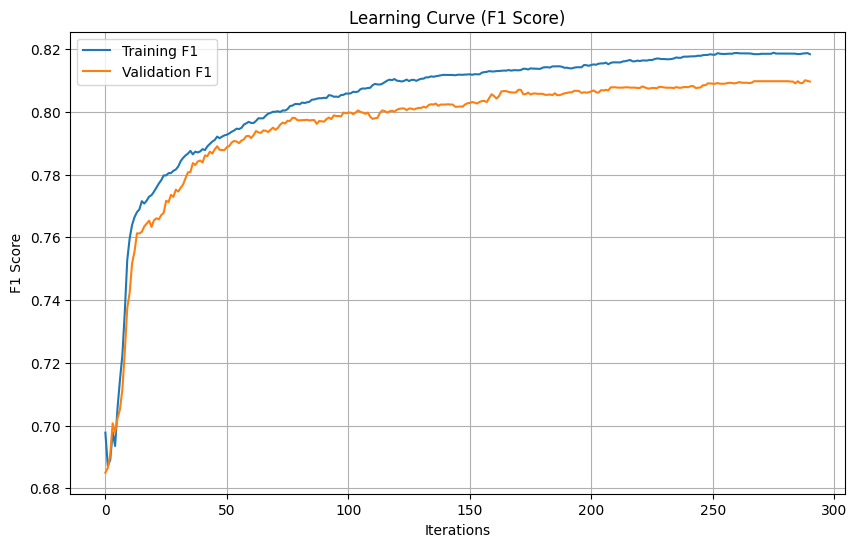

In [123]:
train_scores = cat_model.evals_result_["learn"]["F1"]
validation_scores = cat_model.evals_result_["validation"]["F1"]

# plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_scores, label="Training F1")
plt.plot(validation_scores, label="Validation F1")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.title("Learning Curve (F1 Score)")
plt.legend()
plt.grid(True)
plt.show()

It generalized reasonably well!!

## Model Evaluation

### Classification report:

In [129]:
cat_preds = cat_model.predict(X_test)

report = classification_report(y_test, cat_preds, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.97      0.90      0.93      7635
         Yes       0.51      0.82      0.63      1004

    accuracy                           0.89      8639
   macro avg       0.74      0.86      0.78      8639
weighted avg       0.92      0.89      0.90      8639



The improvements in F1-score were not outstanding but still notable. Overall accuracy dropped slightly, but the change is not significant. Recall for true positives—our primary objective—improved significantly, demonstrating better identification of potential subscribers. Precision, which measures how many predicted subscribers are actually correct, declined. However, we are prioritizing recall, which measures how many actual subscribers were successfully identified, to ensure we capture as many potential subscribers as possible. **It's okay to do some wrong calls!!**

### ROC curve:

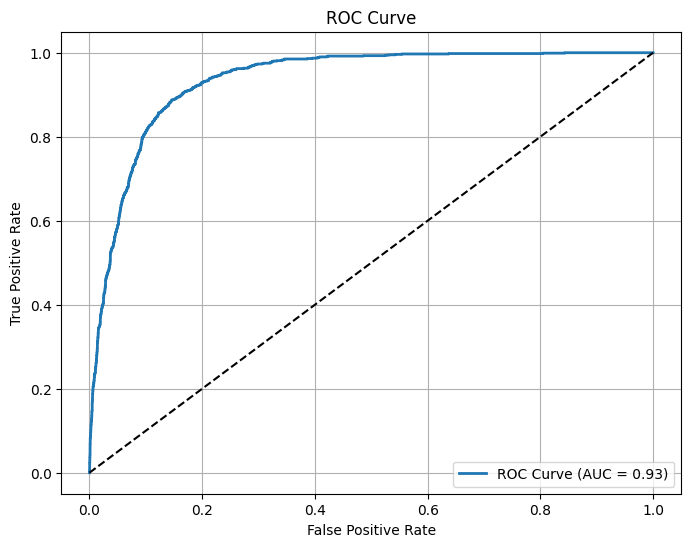

In [132]:
# prediction probabilities
cat_probs = cat_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cat_probs)

# ROC AUC score
auc_score = roc_auc_score(y_test, cat_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The AUC score is basically the same.

### Confusion Matrix

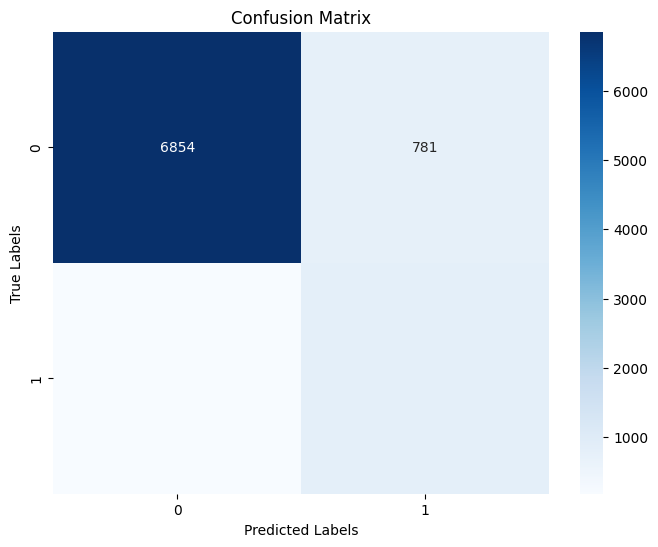

In [135]:
# make predictions
y_pred = cat_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

After hyperparameter tuning, the matrix shows an increase in identified subscribers, though some misclassifications remain.

## Feature selection:

Understanding what drives our model is essential. We use **two powerful methods**: **Permutation Importance**, which quickly highlights key features by measuring how performance drops when we shuffle them, and **SHAP Violin Plots**, which reveal not only which features matter but also how they influence predictions—whether positively or negatively. Together, these methods provide a clear and well-rounded view of our model’s decision-making process, helping us understand both *what* drives the model and *how* it makes its predictions.

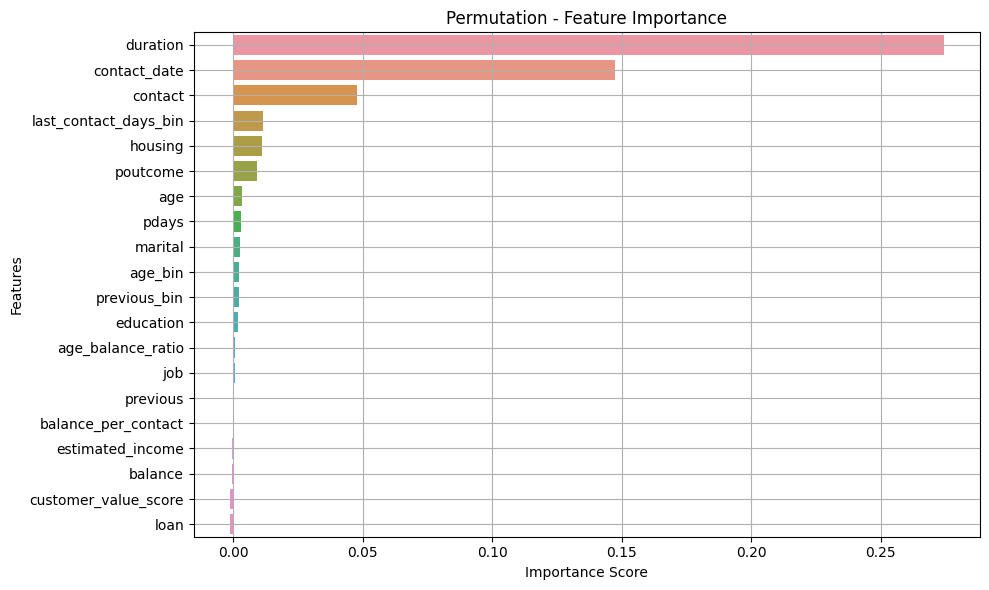

In [139]:
# permutation importance
perm_importance = permutation_importance(cat_model, X_test, y_test, scoring="f1", 
                                         n_repeats=10, random_state=42)

# to conver into df
perm_feature_scores = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
    }).sort_values(by="Importance", ascending=False)

# plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_feature_scores["Importance"], y=perm_feature_scores["Feature"])
plt.title("Permutation - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

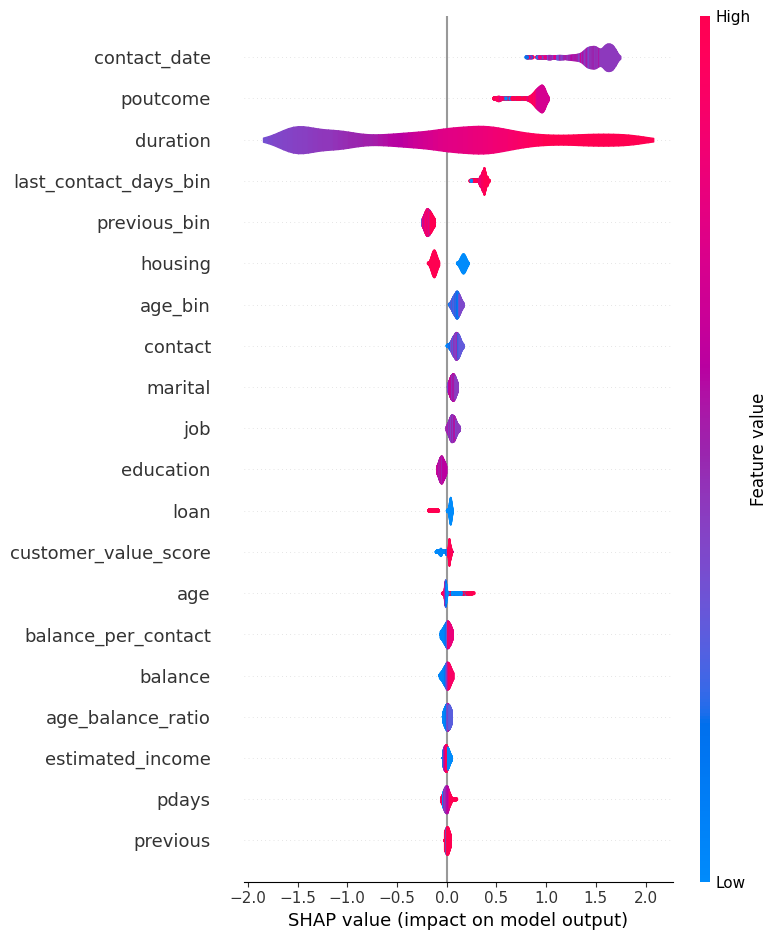

In [140]:
# to ensure that categorical features are encoded
X_test_encoded = X_test.copy()
for col in category_cols:
    X_test_encoded[col] = X_test_encoded[col].astype('category').cat.codes

# initialize SHAP explainer
explainer = shap.TreeExplainer(cat_model)

# calculate SHAP values
shap_values = explainer.shap_values(X_test_encoded)

# plot (violin plot)
shap.summary_plot(shap_values, X_test_encoded, plot_type="violin")

The analysis highlights "Duration" and "Contact_date" as the most impactful features, with "Poutcome" and "Contact" following after. SHAP shows that high "Duration" strongly boosts predictions, while "Contact_date" has mixed effects. On the other hand, features like "Previous" and "Age" contribute very little. We'll focus on the top features from SHAP and permutation importance, drop the less important ones, and retrain the model to improve performance and efficiency.

### We'll keep features with importance scores above 5% of the maximum, focusing on the most impactful ones:

In [143]:
perm_importance = pd.DataFrame({
    'feature': X_test.columns, 
    'perm_importance': perm_importance.importances_mean
})

# set threshold to 5% of the maximum importance
perm_threshold = 0.05 * perm_importance['perm_importance'].max()  # Keep features contributing >5%
perm_features = perm_importance[perm_importance['perm_importance'] > perm_threshold]['feature'].tolist()

# filter dataset based on selected features
X_train_filtered = X_train[perm_features]
X_test_filtered = X_test[perm_features]

# Print selected features
print("Selected Features Based on Permutation Importance (>5% threshold):")
print(perm_features)

Selected Features Based on Permutation Importance (>5% threshold):
['contact', 'duration', 'contact_date']


In [144]:
category_cols = ['contact_date', 'contact']

# initialize the tunned model
cat_model_filtered = CatBoostClassifier(**best_params, cat_features=category_cols)

# and retrain the model on the filtered dataset
cat_model_filtered.fit(X_train_filtered, y_train)

# lets make predictions
y_pred_filtered = cat_model_filtered.predict(X_test_filtered)

0:	learn: 0.6674528	total: 9.2ms	remaining: 2.67s
1:	learn: 0.6395048	total: 23.1ms	remaining: 3.34s
2:	learn: 0.6154384	total: 35.5ms	remaining: 3.41s
3:	learn: 0.5924577	total: 49.6ms	remaining: 3.56s
4:	learn: 0.5705254	total: 55.9ms	remaining: 3.2s
5:	learn: 0.5527032	total: 62.7ms	remaining: 2.98s
6:	learn: 0.5351165	total: 69.6ms	remaining: 2.83s
7:	learn: 0.5250573	total: 74ms	remaining: 2.62s
8:	learn: 0.5113232	total: 80.8ms	remaining: 2.53s
9:	learn: 0.4991767	total: 87.5ms	remaining: 2.46s
10:	learn: 0.4884927	total: 94.6ms	remaining: 2.41s
11:	learn: 0.4876927	total: 97.6ms	remaining: 2.27s
12:	learn: 0.4774353	total: 105ms	remaining: 2.25s
13:	learn: 0.4713837	total: 110ms	remaining: 2.18s
14:	learn: 0.4625197	total: 117ms	remaining: 2.16s
15:	learn: 0.4549249	total: 125ms	remaining: 2.15s
16:	learn: 0.4480129	total: 132ms	remaining: 2.13s
17:	learn: 0.4411260	total: 139ms	remaining: 2.11s
18:	learn: 0.4349763	total: 153ms	remaining: 2.18s
19:	learn: 0.4289968	total: 159ms

## Model Evaluation

### Classification report:

In [147]:
filtered_report = classification_report(y_test, y_pred_filtered, target_names=["No", "Yes"])
print(filtered_report)

              precision    recall  f1-score   support

          No       0.97      0.89      0.93      7635
         Yes       0.48      0.78      0.59      1004

    accuracy                           0.88      8639
   macro avg       0.72      0.83      0.76      8639
weighted avg       0.91      0.88      0.89      8639



**Slightly worst!** Did not improve at all with feature selection unfortunately.

### ROC curve:

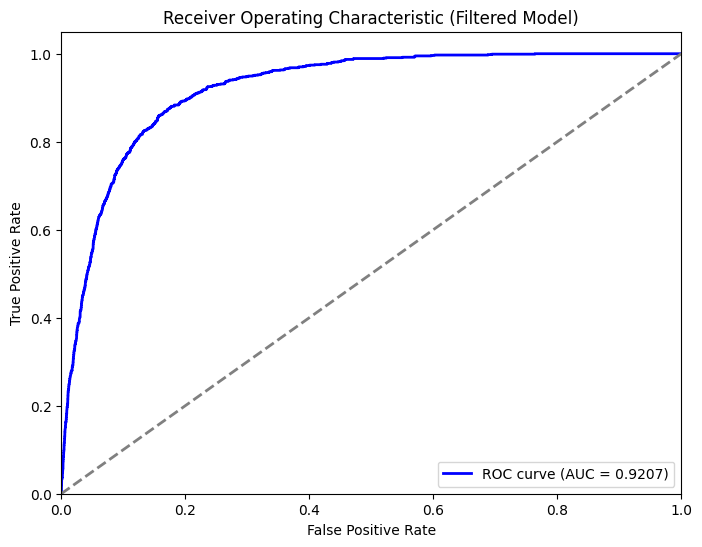

In [150]:
# get predicted probabilities for the filtered model
y_test_proba_filtered = cat_model_filtered.predict_proba(X_test_filtered)[:, 1]

# ROC AUC score
auc_score_filtered = roc_auc_score(y_test, y_test_proba_filtered)

# ROC curve
fpr_filtered, tpr_filtered, _ = roc_curve(y_test, y_test_proba_filtered)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_filtered, tpr_filtered, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score_filtered:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Filtered Model)')
plt.legend(loc="lower right")
plt.show()

Got worst as well!

### Confusion matrix:

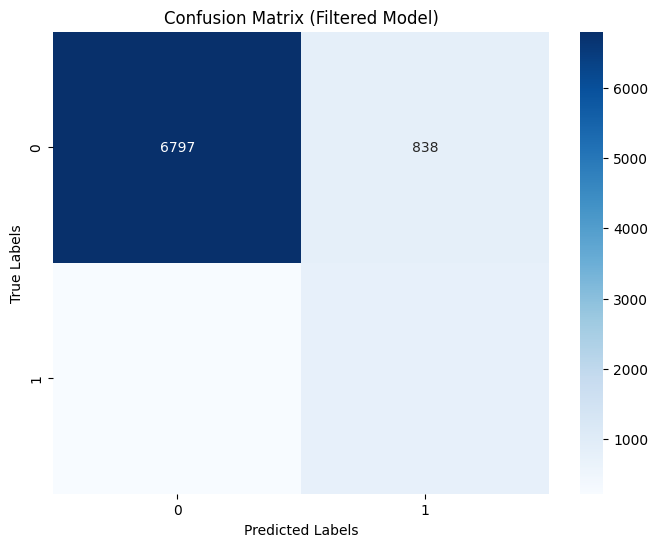

In [153]:
# make predictions
y_pred_filtered = cat_model_filtered.predict(X_test_filtered)

# confusion matrix (filtered)
cm_filtered = confusion_matrix(y_test, y_pred_filtered)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Filtered Model)')
plt.show()

# Summary of Results

After parameter tuning, our model achieves a better balance between the minority ("Yes") and majority ("No") classes. The **accuracy decreased slightly to 89%** from 91%, reflecting a small trade-off for improved handling of imbalanced classes. Precision for "Yes" is **51%**, meaning the model's predictions for subscribers include some false positives. However, recall for "Yes" improved significantly to **82%**, showing the model captures more true subscribers—critical for identifying valuable leads. For non-subscribers ("No"), the model maintains high precision (**97%**) and recall (**90%**). The AUC score of **0.94** confirms the model's strong overall ability to separate the classes.

Unfortunately, feature selection did not improve the model's performance. As a result, we consider the hyperparameter-tuned model without feature selection as our final model for comparison.